In [1]:
import pandas as pd
import pickle
import warnings

import logging

In [2]:
from pathlib import Path

from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps

from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

%cd Cell

[Errno 2] No such file or directory: 'Cell'
/opt/data/Cell


# Download data

In [4]:
id_df = pd.read_csv('id_L5_E.csv')
id_df.head()

,cell_specimen_id,ephys_session_id,transcriptomics_sample_id
0,601790961,601790945,PS0817E150S19
1,601808698,601808619,PS0817E150S26
2,602231708,602231628,PS0817E150S46
3,623813235,623813080,SMGE62SS113E150
4,626082009,626081013,SMGE62SS124E150


In [5]:
id_m = pd.read_csv('id_L5_M.csv')
id_m.head()

,cell_specimen_id,neuron_reconstruction_type,ephys_session_id,transcriptomics_sample_id
0,601790961,full,601790945,PS0817_E1-50_S19
1,601808698,full,601808619,PS0817_E1-50_S26
2,602231708,full,602231628,PS0817_E1-50_S46
3,626153003,full,626152964,SM-GE62S_S126_E1-50
4,639674270,full,639674215,SM-GE63H_S142_E1-50


## Get dandiset metadata

Use `dandi ls` command to fetch metadata in dandiset 000020.

In [227]:
dandi_ls=!dandi ls -r https://gui.dandiarchive.org/#/dandiset/000020

In [228]:
dandi_ls[21:40]

['- asset_id: 8c4711f7-f4b3-4c2c-a74f-694d972c3bb3',
 "  created: '2021-04-21T00:30:15.432590Z'",
 "  modified: '2021-05-18T13:12:40.583797Z'",
 '  path: sub-1001658958/sub-1001658958_ses-1003321768_icephys.nwb',
 '  size: 19842547',
 '- asset_id: 31e89567-ff9d-455f-9b64-95d6a127e4ae',
 "  created: '2021-04-21T00:30:16.463539Z'",
 "  modified: '2021-05-18T13:12:42.644341Z'",
 '  path: sub-1001658958/sub-1001658958_ses-1003336912_icephys.nwb',
 '  size: 22263517',
 '- asset_id: 31fb9678-d64c-492b-8477-2db5eae41bba',
 "  created: '2021-04-21T00:30:24.691227Z'",
 "  modified: '2021-05-18T13:12:42.653464Z'",
 '  path: sub-1001658958/sub-1001658958_ses-1003313230_icephys.nwb',
 '  size: 31666658',
 '- asset_id: 3008e218-3214-4b3d-baa5-6cf6728df450',
 "  created: '2021-04-21T00:30:41.809698Z'",
 "  modified: '2021-05-18T13:12:42.661518Z'",
 '  path: sub-601462926/sub-601462926_ses-602231628_icephys.nwb']

Tidy dandiset metadata:

In [4]:
def generate_dandi_res():
    res=dict()
    for row in dandi_ls[21:]:
        sp = row.split(': ')
        if len(sp)==2:
            k,v = sp
            k = k.strip('-').strip()
            v = v.strip("'").strip()
            if k=='asset_id' and res:
                yield res
                res = dict()
            res[k]=v
            if k=='path':
                ephys_id = v.split('_ses-')[-1].split('_')[0]
                res['ephys_session_id']=ephys_id
    yield res

In [230]:
gen = generate_dandi_res()
dandi_ls_df = pd.DataFrame(gen)

Generate each nwb downloading link from asset_id:

In [231]:
dandi_ls_df['nwb_download_link'] = dandi_ls_df['asset_id'].map(
    lambda id_: f'https://api.dandiarchive.org/api/dandisets/000020/versions/draft/assets/{id_}/download/'
)

In [232]:
dandi_ls_df['ephys_session_id'] = dandi_ls_df['ephys_session_id'].astype(int)
dandi_ls_df.head()

,asset_id,created,modified,path,ephys_session_id,size,nwb_download_link
0,8c4711f7-f4b3-4c2c-a74f-694d972c3bb3,2021-04-21T00:30:15.432590Z,2021-05-18T13:12:40.583797Z,sub-1001658958/sub-1001658958_ses-1003321768_i...,1003321768,19842547,https://api.dandiarchive.org/api/dandisets/000...
1,31e89567-ff9d-455f-9b64-95d6a127e4ae,2021-04-21T00:30:16.463539Z,2021-05-18T13:12:42.644341Z,sub-1001658958/sub-1001658958_ses-1003336912_i...,1003336912,22263517,https://api.dandiarchive.org/api/dandisets/000...
2,31fb9678-d64c-492b-8477-2db5eae41bba,2021-04-21T00:30:24.691227Z,2021-05-18T13:12:42.653464Z,sub-1001658958/sub-1001658958_ses-1003313230_i...,1003313230,31666658,https://api.dandiarchive.org/api/dandisets/000...
3,3008e218-3214-4b3d-baa5-6cf6728df450,2021-04-21T00:30:41.809698Z,2021-05-18T13:12:42.661518Z,sub-601462926/sub-601462926_ses-602231628_icep...,602231628,19310074,https://api.dandiarchive.org/api/dandisets/000...
4,96ab58ce-c7bf-4e40-adc1-61e6f7974706,2021-04-21T00:30:41.857307Z,2021-05-18T13:12:40.591086Z,sub-599387254/sub-599387254_ses-601506492_icep...,601506492,17881801,https://api.dandiarchive.org/api/dandisets/000...


In [234]:
dandi_ls_df.to_csv('dandiset_000020_metadata.csv')

In [6]:
# optinal use
dandi_ls_df=pd.read_csv('dandiset_000020_metadata.csv')

## Download NWB files
### Download files with full morphology

Filter cells with full morphology:

In [7]:
electro_df = id_m.merge(dandi_ls_df[['ephys_session_id', 'nwb_download_link', 'path']], how='left', on='ephys_session_id')
electro_df['path'] = electro_df['path'].map(lambda p: 'nwb/'+Path(p).name)
electro_df.head()

,cell_specimen_id,neuron_reconstruction_type,ephys_session_id,transcriptomics_sample_id,nwb_download_link,path
0,601790961,full,601790945,PS0817_E1-50_S19,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-601462951_ses-601790945_icephys.nwb
1,601808698,full,601808619,PS0817_E1-50_S26,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-601462951_ses-601808619_icephys.nwb
2,602231708,full,602231628,PS0817_E1-50_S46,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-601462926_ses-602231628_icephys.nwb
3,626153003,full,626152964,SM-GE62S_S126_E1-50,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-617297334_ses-626152964_icephys.nwb
4,639674270,full,639674215,SM-GE63H_S142_E1-50,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-639390385_ses-639674215_icephys.nwb


Batch downloading:

In [31]:
!mkdir nwb

In [ ]:
for row_id, row in tqdm(electro_df.iterrows(), total=electro_df.shape[0]):
    if not Path(row['path']).exists():
        !dandi download -o nwb -e skip {row['nwb_download_link']}
    else:
        continue

In [12]:
with open('to-download-20210712.txt', 'w') as f:
    for row_id, row in electro_df.iterrows():
        if not Path(row['path']).exists():
            f.write(row['nwb_download_link']+'\n')

In [18]:
electro_df['path'].map(lambda p: not Path(p).exists()).sum()

0

In [2]:
electro_df.to_csv('L5_Electro_metadata_with_morpho.csv')

In [7]:
# optional use
electro_df = pd.read_csv('L5_Electro_metadata_with_morpho.csv')

### Download files without full morphology

In [8]:
cond = ~id_df['cell_specimen_id'].isin(id_m['cell_specimen_id'])
id_nm = id_df[cond.values]
id_nm.head()

,cell_specimen_id,ephys_session_id,transcriptomics_sample_id
3,623813235,623813080,SMGE62SS113E150
4,626082009,626081013,SMGE62SS124E150
6,627883518,627883502,SMGE63VS099E150
7,636854912,636854897,SMGE63VS131E150
8,636856236,636856220,SMGE63VS132E150


In [9]:
electro_df_nm = id_nm.merge(dandi_ls_df[['ephys_session_id', 'nwb_download_link', 'path']], how='left', on='ephys_session_id')
electro_df_nm['path'] = electro_df_nm['path'].map(lambda p: 'nwb/'+Path(p).name)
electro_df_nm.head()

,cell_specimen_id,ephys_session_id,transcriptomics_sample_id,nwb_download_link,path
0,623813235,623813080,SMGE62SS113E150,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-617297324_ses-623813080_icephys.nwb
1,626082009,626081013,SMGE62SS124E150,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-617297334_ses-626081013_icephys.nwb
2,627883518,627883502,SMGE63VS099E150,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-617297348_ses-627883502_icephys.nwb
3,636854912,636854897,SMGE63VS131E150,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-626194690_ses-636854897_icephys.nwb
4,636856236,636856220,SMGE63VS132E150,https://api.dandiarchive.org/api/dandisets/000...,nwb/sub-626194690_ses-636856220_icephys.nwb


In [252]:
electro_df_nm.to_csv('L5_Electro_metadata_without_morpho.csv')

In [253]:
for row_id, row in tqdm(electro_df_nm.iterrows(), total=electro_df_nm.shape[0]):
    !dandi download {row['nwb_download_link']} -o nwb

  0%|          | 0/1019 [00:00<?, ?it/s]

2021-06-28 15:46:06,175 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-617297324_ses-623813080_icephys.nwb 16.9 MB  16.9 MB          100%    ok    done                   
Summary:                                16.9 MB  16.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 15:57:41,196 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628154603Z-8347.log


  0%|          | 1/1019 [11:39<197:50:15, 699.62s/it]

2021-06-28 15:57:46,177 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-617297334_ses-626081013_icephys.nwb 17.8 MB  17.8 MB          100%    ok    done                   
Summary:                                17.8 MB  17.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:14:49,514 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628155743Z-8362.log


  0%|          | 2/1019 [28:47<252:15:53, 892.97s/it]

2021-06-28 16:14:53,566 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-617297348_ses-627883502_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:28:24,260 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628161451Z-8377.log


  0%|          | 3/1019 [42:22<241:56:28, 857.27s/it]

2021-06-28 16:28:27,841 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-626194690_ses-636854897_icephys.nwb 19.5 MB  19.5 MB         100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 16:36:05,530 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628162826Z-8392.log


  0%|          | 4/1019 [50:03<197:37:14, 700.92s/it]

2021-06-28 16:36:09,229 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-626194690_ses-636856220_icephys.nwb 17.2 MB  17.2 MB          100%    ok    done                   
Summary:                                17.2 MB  17.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:36:19,386 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628163607Z-8399.log


  0%|          | 5/1019 [50:17<127:38:28, 453.16s/it]

2021-06-28 16:36:22,930 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-626194722_ses-637379889_icephys.nwb 19.1 MB  19.1 MB          100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:36:30,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628163621Z-8404.log


  1%|          | 6/1019 [50:29<85:14:08, 302.91s/it] 

2021-06-28 16:36:34,608 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-636828314_ses-637866126_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:36:42,259 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628163633Z-8409.log


  1%|          | 7/1019 [50:40<58:22:49, 207.68s/it]

2021-06-28 16:36:45,802 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-626194816_ses-638176282_icephys.nwb 19.0 MB  19.0 MB          100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:36:53,905 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628163644Z-8414.log


  1%|          | 8/1019 [50:52<40:47:58, 145.28s/it]

2021-06-28 16:36:57,625 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-637383917_ses-638356193_icephys.nwb 22.0 MB  22.0 MB          100%    ok    done                   
Summary:                                22.0 MB  22.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:39:10,127 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628163656Z-8419.log


  1%|          | 9/1019 [53:08<39:57:46, 142.44s/it]

2021-06-28 16:39:14,640 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-637383967_ses-638366259_icephys.nwb 17.8 MB  17.8 MB         100%    ok    done                   
Summary:                                17.8 MB  17.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 16:45:40,142 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628163912Z-8426.log


  1%|          | 10/1019 [59:38<61:20:34, 218.87s/it]

2021-06-28 16:45:43,542 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-637383977_ses-638782455_icephys.nwb 24.2 MB  24.2 MB         100%    ok    done                   
Summary:                                24.2 MB  24.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 16:49:17,484 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628164542Z-8435.log


  1%|          | 11/1019 [1:03:15<61:09:14, 218.41s/it]

2021-06-28 16:49:20,872 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-637383957_ses-639018100_icephys.nwb 18.3 MB  18.3 MB         100%    ok    done                   
Summary:                                18.3 MB  18.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 16:52:02,911 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628164919Z-8444.log


  1%|          | 12/1019 [1:06:01<56:34:53, 202.28s/it]

2021-06-28 16:52:06,197 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-637383987_ses-639018799_icephys.nwb 20.7 MB  20.7 MB         100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 16:57:11,434 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628165204Z-8453.log


  1%|▏         | 13/1019 [1:11:09<65:31:20, 234.47s/it]

2021-06-28 16:57:14,967 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-637383947_ses-639389976_icephys.nwb 19.4 MB  19.4 MB        100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 16:59:01,221 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628165713Z-8460.log


  1%|▏         | 14/1019 [1:12:59<54:56:28, 196.80s/it]

2021-06-28 16:59:05,773 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-639390395_ses-639671843_icephys.nwb 13.3 MB  13.3 MB          100%    ok    done                   
Summary:                                13.3 MB  13.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 16:59:28,466 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628165903Z-8467.log


  1%|▏         | 15/1019 [1:13:26<40:37:53, 145.69s/it]

2021-06-28 16:59:33,037 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-639390385_ses-639701642_icephys.nwb 13.4 MB  13.4 MB          100%    ok    done                   
Summary:                                13.4 MB  13.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:00:43,510 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628165930Z-8472.log


  2%|▏         | 16/1019 [1:14:41<34:40:00, 124.43s/it]

2021-06-28 17:00:46,766 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-639391169_ses-639808631_icephys.nwb 14.1 MB  14.1 MB        100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:02:20,545 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170045Z-8481.log


  2%|▏         | 17/1019 [1:16:18<32:20:22, 116.19s/it]

2021-06-28 17:02:23,684 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391169_ses-639850359_icephys.nwb 13.8 MB  13.8 MB         100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:02:30,794 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170222Z-8488.log


  2%|▏         | 18/1019 [1:16:29<23:27:28, 84.36s/it] 

2021-06-28 17:02:33,814 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-639391189_ses-639860852_icephys.nwb 13.0 MB  13.0 MB          100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:03:24,160 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170232Z-8493.log


  2%|▏         | 19/1019 [1:17:22<20:50:51, 75.05s/it]

2021-06-28 17:03:27,407 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-639391586_ses-640287004_icephys.nwb 13.7 MB  13.7 MB        100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:04:54,578 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170325Z-8498.log


  2%|▏         | 20/1019 [1:18:52<22:06:20, 79.66s/it]

2021-06-28 17:04:57,744 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391596_ses-640315794_icephys.nwb 12.8 MB  12.8 MB         100%    ok    done                   
Summary:                                12.8 MB  12.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:07:53,557 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170456Z-8507.log


  2%|▏         | 21/1019 [1:21:51<30:20:58, 109.48s/it]

2021-06-28 17:07:57,054 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391596_ses-640317026_icephys.nwb 11.9 MB  11.9 MB         100%    ok    done                   
Summary:                                11.9 MB  11.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:08:06,356 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170755Z-8516.log


  2%|▏         | 22/1019 [1:22:04<22:17:04, 80.47s/it] 

2021-06-28 17:08:09,667 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391815_ses-642103947_icephys.nwb 14.5 MB  14.5 MB         100%    ok    done                   
Summary:                                14.5 MB  14.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:08:18,379 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170808Z-8521.log


  2%|▏         | 23/1019 [1:22:16<16:34:51, 59.93s/it]

2021-06-28 17:08:21,809 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-639391815_ses-642110295_icephys.nwb 13.9 MB  13.9 MB          100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:09:00,421 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170820Z-8526.log


  2%|▏         | 24/1019 [1:22:58<15:04:51, 54.56s/it]

2021-06-28 17:09:03,995 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391815_ses-642166968_icephys.nwb 14.4 MB  14.4 MB         100%    ok    done                   
Summary:                                14.4 MB  14.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:09:11,812 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170902Z-8531.log


  2%|▏         | 25/1019 [1:23:10<11:29:09, 41.60s/it]

2021-06-28 17:09:14,979 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-639391825_ses-642227553_icephys.nwb 13.6 MB  13.6 MB          100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:09:25,223 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170913Z-8536.log


  3%|▎         | 26/1019 [1:23:23<9:08:28, 33.14s/it] 

2021-06-28 17:09:28,455 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391835_ses-642258959_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:09:34,921 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170927Z-8541.log


  3%|▎         | 27/1019 [1:23:33<7:11:41, 26.11s/it]

2021-06-28 17:09:38,066 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-639391835_ses-642266377_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:09:44,773 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170936Z-8546.log


  3%|▎         | 28/1019 [1:23:43<5:50:42, 21.23s/it]

2021-06-28 17:09:47,996 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-640279125_ses-642478942_icephys.nwb 14.1 MB  14.1 MB         100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:09:55,192 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170946Z-8553.log


  3%|▎         | 29/1019 [1:23:53<4:56:49, 17.99s/it]

2021-06-28 17:09:58,528 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-640279125_ses-642532579_icephys.nwb 13.1 MB  13.1 MB         100%    ok    done                   
Summary:                                13.1 MB  13.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:10:05,612 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628170957Z-8558.log


  3%|▎         | 30/1019 [1:24:04<4:19:17, 15.73s/it]

2021-06-28 17:10:09,062 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-642979428_ses-643646054_icephys.nwb 14.0 MB  14.0 MB         100%    ok    done                   
Summary:                                14.0 MB  14.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:10:15,834 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171007Z-8563.log


  3%|▎         | 31/1019 [1:24:14<3:51:38, 14.07s/it]

2021-06-28 17:10:19,061 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-642979261_ses-643648694_icephys.nwb 13.5 MB  13.5 MB          100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:10:28,715 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171017Z-8568.log


  3%|▎         | 32/1019 [1:24:27<3:45:34, 13.71s/it]

2021-06-28 17:10:31,921 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-642979261_ses-643649630_icephys.nwb 13.8 MB  13.8 MB         100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:10:41,044 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171030Z-8573.log


  3%|▎         | 33/1019 [1:24:39<3:38:27, 13.29s/it]

2021-06-28 17:10:44,116 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-642979203_ses-643697248_icephys.nwb 14.0 MB  14.0 MB          100%    ok    done                   
Summary:                                14.0 MB  14.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:12:14,124 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171042Z-8578.log


  3%|▎         | 34/1019 [1:26:12<10:11:06, 37.22s/it]

2021-06-28 17:12:17,131 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-642979333_ses-643727518_icephys.nwb 13.0 MB  13.0 MB         100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:12:24,471 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171215Z-8585.log


  3%|▎         | 35/1019 [1:26:22<7:58:18, 29.16s/it] 

2021-06-28 17:12:27,688 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-642979333_ses-643785113_icephys.nwb 12.7 MB  12.7 MB        100%    ok    done                   
Summary:                                12.7 MB  12.7 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:13:44,974 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171226Z-8590.log


  4%|▎         | 36/1019 [1:27:43<12:10:16, 44.57s/it]

2021-06-28 17:13:48,029 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-642979440_ses-643822780_icephys.nwb 12.8 MB  12.8 MB         100%    ok    done                   
Summary:                                12.8 MB  12.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:13:55,869 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171346Z-8597.log


  4%|▎         | 37/1019 [1:27:54<9:24:02, 34.46s/it] 

2021-06-28 17:13:59,073 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-643830358_ses-645000272_icephys.nwb 13.5 MB  13.5 MB         100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:14:05,956 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171357Z-8602.log


  4%|▎         | 38/1019 [1:28:04<7:24:02, 27.16s/it]

2021-06-28 17:14:09,123 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-643830358_ses-645016075_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:14:15,131 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171407Z-8607.log


  4%|▍         | 39/1019 [1:28:13<5:55:20, 21.76s/it]

2021-06-28 17:14:18,213 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-644988807_ses-645375817_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:14:25,317 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171416Z-8612.log


  4%|▍         | 40/1019 [1:28:23<4:58:21, 18.29s/it]

2021-06-28 17:14:28,575 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-645093249_ses-645436619_icephys.nwb 14.7 MB  14.7 MB         100%    ok    done                   
Summary:                                14.7 MB  14.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:14:35,084 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171427Z-8617.log


  4%|▍         | 41/1019 [1:28:33<4:16:22, 15.73s/it]

2021-06-28 17:14:38,364 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-644988797_ses-645436651_icephys.nwb 14.1 MB  14.1 MB          100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:15:36,274 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171436Z-8622.log


  4%|▍         | 42/1019 [1:29:34<7:58:14, 29.37s/it]

2021-06-28 17:15:40,126 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-645093249_ses-645441106_icephys.nwb 15.1 MB  15.1 MB         100%    ok    done                   
Summary:                                15.1 MB  15.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:15:48,183 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171538Z-8627.log


  4%|▍         | 43/1019 [1:29:46<6:32:33, 24.13s/it]

2021-06-28 17:15:51,822 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-644988797_ses-645443184_icephys.nwb 13.5 MB  13.5 MB          100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:16:43,511 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171550Z-8634.log


  4%|▍         | 44/1019 [1:30:41<9:04:12, 33.49s/it]

2021-06-28 17:16:46,900 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-645665011_ses-646764472_icephys.nwb 15.4 MB  15.4 MB         100%    ok    done                   
Summary:                                15.4 MB  15.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:16:53,631 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171645Z-8639.log


  4%|▍         | 45/1019 [1:30:52<7:09:54, 26.48s/it]

2021-06-28 17:16:57,437 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-645665144_ses-646995001_icephys.nwb 15.5 MB  15.5 MB          100%    ok    done                   
Summary:                                15.5 MB  15.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:17:10,301 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171655Z-8644.log


  5%|▍         | 46/1019 [1:31:08<6:21:56, 23.55s/it]

2021-06-28 17:17:13,778 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-645665021_ses-647102529_icephys.nwb 14.8 MB  14.8 MB          100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:17:39,334 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171712Z-8651.log


  5%|▍         | 47/1019 [1:31:37<6:47:57, 25.18s/it]

2021-06-28 17:17:42,833 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-645665021_ses-647103048_icephys.nwb 50.5 MB  50.5 MB          100%    ok    done                   
Summary:                                50.5 MB  50.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:18:35,821 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171741Z-8656.log


  5%|▍         | 48/1019 [1:32:34<9:19:34, 34.58s/it]

2021-06-28 17:18:39,505 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-645665042_ses-647105681_icephys.nwb 16.4 MB  16.4 MB        100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:19:57,241 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171838Z-8663.log


  5%|▍         | 49/1019 [1:33:55<13:06:07, 48.63s/it]

2021-06-28 17:20:00,666 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-645665062_ses-647842635_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:20:08,027 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628171959Z-8670.log


  5%|▍         | 50/1019 [1:34:06<10:02:01, 37.28s/it]

2021-06-28 17:20:11,394 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-647700042_ses-648330586_icephys.nwb 13.8 MB  13.8 MB        100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:21:34,695 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172010Z-8675.log


  5%|▌         | 51/1019 [1:35:33<14:00:20, 52.09s/it]

2021-06-28 17:21:39,342 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-648085025_ses-648544475_icephys.nwb 16.4 MB  16.4 MB         100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:21:49,053 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172136Z-8680.log


  5%|▌         | 52/1019 [1:35:47<10:57:04, 40.77s/it]

2021-06-28 17:21:52,588 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-648085025_ses-648549080_icephys.nwb 15.6 MB  15.6 MB         100%    ok    done                   
Summary:                                15.6 MB  15.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:21:59,312 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172151Z-8687.log


  5%|▌         | 53/1019 [1:35:57<8:29:03, 31.62s/it] 

2021-06-28 17:22:02,755 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-648085025_ses-648564573_icephys.nwb 15.3 MB  15.3 MB         100%    ok    done                   
Summary:                                15.3 MB  15.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:22:09,848 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172201Z-8692.log


  5%|▌         | 54/1019 [1:36:08<6:46:55, 25.30s/it]

2021-06-28 17:22:13,497 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-648085025_ses-648609489_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:22:20,888 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172212Z-8697.log


  5%|▌         | 55/1019 [1:36:19<5:37:37, 21.01s/it]

2021-06-28 17:22:24,097 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-648087076_ses-650129727_icephys.nwb 16.1 MB  16.1 MB        100%    ok    done                   
Summary:                                16.1 MB  16.1 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:23:40,047 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172222Z-8702.log


  5%|▌         | 56/1019 [1:37:38<10:17:08, 38.45s/it]

2021-06-28 17:23:43,138 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-650040525_ses-650177072_icephys.nwb 14.0 MB  14.0 MB          100%    ok    done                   
Summary:                                14.0 MB  14.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:24:11,499 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172341Z-8707.log


  6%|▌         | 57/1019 [1:38:09<9:42:50, 36.35s/it] 

2021-06-28 17:24:14,679 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-650040692_ses-650402628_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:25:44,298 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172413Z-8714.log


  6%|▌         | 58/1019 [1:39:42<14:13:28, 53.29s/it]

2021-06-28 17:25:47,338 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-650040513_ses-650487884_icephys.nwb 14.5 MB  14.5 MB         100%    ok    done                   
Summary:                                14.5 MB  14.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:25:56,560 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172546Z-8719.log


  6%|▌         | 59/1019 [1:39:54<10:55:46, 40.99s/it]

2021-06-28 17:26:00,008 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-650869035_ses-651763827_icephys.nwb 13.0 MB  13.0 MB          100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:26:32,560 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172558Z-8726.log


  6%|▌         | 60/1019 [1:40:30<10:31:10, 39.49s/it]

2021-06-28 17:26:35,902 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-650868825_ses-651969404_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:26:42,950 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172634Z-8731.log


  6%|▌         | 61/1019 [1:40:41<8:11:09, 30.76s/it] 

2021-06-28 17:26:46,358 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-650869065_ses-652764642_icephys.nwb 13.4 MB  13.4 MB          100%    ok    done                   
Summary:                                13.4 MB  13.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:26:58,242 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172644Z-8736.log


  6%|▌         | 62/1019 [1:40:56<6:56:34, 26.12s/it]

2021-06-28 17:27:02,061 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-650868815_ses-652920254_icephys.nwb 12.8 MB  12.8 MB         100%    ok    done                   
Summary:                                12.8 MB  12.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:27:08,967 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172700Z-8741.log


  6%|▌         | 63/1019 [1:41:07<5:42:38, 21.50s/it]

2021-06-28 17:27:12,461 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-650868815_ses-652920551_icephys.nwb 13.6 MB  13.6 MB          100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:27:42,283 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172710Z-8746.log


  6%|▋         | 64/1019 [1:41:40<6:38:38, 25.05s/it]

2021-06-28 17:27:46,318 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-652361194_ses-653195922_icephys.nwb 13.1 MB  13.1 MB        100%    ok    done                   
Summary:                                13.1 MB  13.1 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:29:48,493 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172744Z-8751.log


  6%|▋         | 65/1019 [1:43:46<14:40:41, 55.39s/it]

2021-06-28 17:29:51,764 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-652361194_ses-653196344_icephys.nwb 12.8 MB  12.8 MB         100%    ok    done                   
Summary:                                12.8 MB  12.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:29:58,334 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628172950Z-8758.log


  6%|▋         | 66/1019 [1:43:56<11:02:42, 41.72s/it]

2021-06-28 17:30:01,667 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-652361331_ses-653289786_icephys.nwb 14.1 MB  14.1 MB         100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:30:09,363 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173000Z-8765.log


  7%|▋         | 67/1019 [1:44:07<8:35:54, 32.52s/it] 

2021-06-28 17:30:12,588 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-652361331_ses-653326944_icephys.nwb 14.1 MB  14.1 MB         100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:30:19,025 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173011Z-8770.log


  7%|▋         | 68/1019 [1:44:17<6:46:46, 25.66s/it]

2021-06-28 17:30:22,124 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-652361174_ses-653744209_icephys.nwb 52.1 MB  52.1 MB          100%    ok    done                   
Summary:                                52.1 MB  52.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:30:32,921 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173020Z-8775.log


  7%|▋         | 69/1019 [1:44:31<5:50:26, 22.13s/it]

2021-06-28 17:30:35,930 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-652361291_ses-653832048_icephys.nwb 27.3 MB  27.3 MB          100%    ok    done                   
Summary:                                27.3 MB  27.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:30:45,002 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173034Z-8780.log


  7%|▋         | 70/1019 [1:44:43<5:02:22, 19.12s/it]

2021-06-28 17:30:48,140 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-653545820_ses-656147245_icephys.nwb 14.5 MB  14.5 MB         100%    ok    done                   
Summary:                                14.5 MB  14.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:30:55,942 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173046Z-8785.log


  7%|▋         | 71/1019 [1:44:54<4:23:14, 16.66s/it]

2021-06-28 17:30:58,979 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-653545830_ses-656427613_icephys.nwb 13.6 MB  13.6 MB          100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:31:11,876 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173057Z-8790.log


  7%|▋         | 72/1019 [1:45:10<4:19:33, 16.44s/it]

2021-06-28 17:31:14,943 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-653545733_ses-656449579_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:31:21,310 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173113Z-8795.log


  7%|▋         | 73/1019 [1:45:19<3:46:09, 14.34s/it]

2021-06-28 17:31:24,556 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656436926_ses-656705201_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:31:30,713 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173123Z-8800.log


  7%|▋         | 74/1019 [1:45:29<3:22:30, 12.86s/it]

2021-06-28 17:31:33,676 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656436866_ses-656718783_icephys.nwb 14.6 MB  14.6 MB         100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:31:40,793 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173132Z-8805.log


  7%|▋         | 75/1019 [1:45:39<3:09:09, 12.02s/it]

2021-06-28 17:31:43,759 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-656436893_ses-656896403_icephys.nwb 46.0 MB  46.0 MB          100%    ok    done                   
Summary:                                46.0 MB  46.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:31:56,100 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173142Z-8810.log


  7%|▋         | 76/1019 [1:45:54<3:24:32, 13.01s/it]

2021-06-28 17:31:59,273 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656436866_ses-656900221_icephys.nwb 14.4 MB  14.4 MB         100%    ok    done                   
Summary:                                14.4 MB  14.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:32:08,575 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173157Z-8817.log


  8%|▊         | 77/1019 [1:46:06<3:21:40, 12.85s/it]

2021-06-28 17:32:11,541 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656436795_ses-656948939_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:32:18,101 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173210Z-8822.log


  8%|▊         | 78/1019 [1:46:16<3:05:52, 11.85s/it]

2021-06-28 17:32:21,256 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-656436829_ses-656977460_icephys.nwb 49.6 MB  49.6 MB          100%    ok    done                   
Summary:                                49.6 MB  49.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:32:32,177 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173219Z-8827.log


  8%|▊         | 79/1019 [1:46:30<3:16:09, 12.52s/it]

2021-06-28 17:32:35,262 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656436829_ses-656977634_icephys.nwb 17.6 MB  17.6 MB         100%    ok    done                   
Summary:                                17.6 MB  17.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:32:41,956 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173233Z-8832.log


  8%|▊         | 80/1019 [1:46:40<3:03:13, 11.71s/it]

2021-06-28 17:32:45,228 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656854238_ses-657346133_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:32:52,580 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173243Z-8837.log


  8%|▊         | 81/1019 [1:46:50<2:57:46, 11.37s/it]

2021-06-28 17:32:55,640 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656841505_ses-657366300_icephys.nwb 15.7 MB  15.7 MB         100%    ok    done                   
Summary:                                15.7 MB  15.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:33:02,304 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173254Z-8842.log


  8%|▊         | 82/1019 [1:47:00<2:49:53, 10.88s/it]

2021-06-28 17:33:05,485 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-656841465_ses-657382488_icephys.nwb 13.8 MB  13.8 MB          100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:33:22,988 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173304Z-8847.log


  8%|▊         | 83/1019 [1:47:21<3:35:37, 13.82s/it]

2021-06-28 17:33:25,986 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656841535_ses-657660406_icephys.nwb 16.1 MB  16.1 MB         100%    ok    done                   
Summary:                                16.1 MB  16.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:33:33,246 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173324Z-8852.log


  8%|▊         | 84/1019 [1:47:31<3:18:39, 12.75s/it]

2021-06-28 17:33:36,249 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656841535_ses-657675772_icephys.nwb 14.5 MB  14.5 MB         100%    ok    done                   
Summary:                                14.5 MB  14.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:33:45,288 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173334Z-8857.log


  8%|▊         | 85/1019 [1:47:43<3:15:08, 12.54s/it]

2021-06-28 17:33:48,418 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-656841535_ses-657676250_icephys.nwb 48.3 MB  48.3 MB          100%    ok    done                   
Summary:                                48.3 MB  48.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:33:58,730 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173347Z-8862.log


  8%|▊         | 86/1019 [1:47:57<3:19:10, 12.81s/it]

2021-06-28 17:34:01,721 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-656841447_ses-657725615_icephys.nwb 12.6 MB  12.6 MB         100%    ok    done                   
Summary:                                12.6 MB  12.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:34:08,789 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173400Z-8869.log


  9%|▊         | 87/1019 [1:48:07<3:06:14, 11.99s/it]

2021-06-28 17:34:11,800 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-657069410_ses-657857413_icephys.nwb 14.6 MB  14.6 MB         100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:34:18,890 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173410Z-8874.log


  9%|▊         | 88/1019 [1:48:17<2:57:11, 11.42s/it]

2021-06-28 17:34:21,909 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-657069410_ses-657857851_icephys.nwb 56.0 MB  56.0 MB          100%    ok    done                   
Summary:                                56.0 MB  56.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:34:35,308 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173420Z-8879.log


  9%|▊         | 89/1019 [1:48:33<3:20:15, 12.92s/it]

2021-06-28 17:34:38,306 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-657069410_ses-657858990_icephys.nwb 58.0 MB  58.0 MB          100%    ok    done                   
Summary:                                58.0 MB  58.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:34:49,087 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173437Z-8884.log


  9%|▉         | 90/1019 [1:48:47<3:23:58, 13.17s/it]

2021-06-28 17:34:52,174 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-657498755_ses-657862061_icephys.nwb 49.1 MB  49.1 MB          100%    ok    done                   
Summary:                                49.1 MB  49.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:35:06,207 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173450Z-8889.log


  9%|▉         | 91/1019 [1:49:04<3:42:04, 14.36s/it]

2021-06-28 17:35:09,329 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-657609919_ses-657926775_icephys.nwb 15.9 MB  15.9 MB          100%    ok    done                   
Summary:                                15.9 MB  15.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:36:04,848 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173507Z-8894.log


  9%|▉         | 92/1019 [1:50:03<7:07:08, 27.65s/it]

2021-06-28 17:36:08,190 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-657609919_ses-657959093_icephys.nwb 51.7 MB  51.7 MB         100%    ok    done                   
Summary:                                51.7 MB  51.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:37:52,402 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173606Z-8901.log


  9%|▉         | 93/1019 [1:51:50<13:16:38, 51.62s/it]

2021-06-28 17:37:55,768 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-657069420_ses-657985225_icephys.nwb 13.8 MB  13.8 MB         100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:38:02,943 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173754Z-8906.log


  9%|▉         | 94/1019 [1:52:01<10:05:58, 39.31s/it]

2021-06-28 17:38:06,442 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-657610073_ses-658414884_icephys.nwb 13.2 MB  13.2 MB          100%    ok    done                   
Summary:                                13.2 MB  13.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:39:05,913 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173804Z-8913.log


  9%|▉         | 95/1019 [1:53:04<11:54:25, 46.39s/it]

2021-06-28 17:39:08,893 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-657610083_ses-658477679_icephys.nwb 14.6 MB  14.6 MB         100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:39:15,629 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173907Z-8918.log


  9%|▉         | 96/1019 [1:53:14<9:04:27, 35.39s/it] 

2021-06-28 17:39:18,668 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360582_ses-659280225_icephys.nwb 14.6 MB  14.6 MB         100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:39:25,058 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173917Z-8923.log


 10%|▉         | 97/1019 [1:53:23<7:04:08, 27.60s/it]

2021-06-28 17:39:28,250 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360542_ses-659389532_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:39:36,558 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173926Z-8928.log


 10%|▉         | 98/1019 [1:53:34<5:49:30, 22.77s/it]

2021-06-28 17:39:39,655 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360542_ses-659413451_icephys.nwb 14.9 MB  14.9 MB         100%    ok    done                   
Summary:                                14.9 MB  14.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:39:47,948 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173938Z-8933.log


 10%|▉         | 99/1019 [1:53:46<4:56:52, 19.36s/it]

2021-06-28 17:39:51,162 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360562_ses-659888674_icephys.nwb 14.9 MB  14.9 MB         100%    ok    done                   
Summary:                                14.9 MB  14.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:39:58,150 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173949Z-8938.log


 10%|▉         | 100/1019 [1:53:56<4:14:21, 16.61s/it]

2021-06-28 17:40:01,427 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360562_ses-659934206_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:40:08,821 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628173959Z-8945.log


 10%|▉         | 101/1019 [1:54:07<3:46:52, 14.83s/it]

2021-06-28 17:40:11,876 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-658360522_ses-660454432_icephys.nwb 13.8 MB  13.8 MB        100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:41:41,235 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174010Z-8950.log


 10%|█         | 102/1019 [1:55:39<9:42:18, 38.10s/it]

2021-06-28 17:41:44,362 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360606_ses-660717311_icephys.nwb 13.1 MB  13.1 MB         100%    ok    done                   
Summary:                                13.1 MB  13.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:43:33,287 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174142Z-8957.log


 10%|█         | 103/1019 [1:57:31<15:20:22, 60.29s/it]

2021-06-28 17:43:36,359 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-658360606_ses-660722500_icephys.nwb 13.8 MB  13.8 MB         100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:43:45,775 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174334Z-8966.log


 10%|█         | 104/1019 [1:57:44<11:40:45, 45.95s/it]

2021-06-28 17:43:48,973 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-658360606_ses-660722724_icephys.nwb 12.6 MB  12.6 MB          100%    ok    done                   
Summary:                                12.6 MB  12.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:44:19,466 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174347Z-8971.log


 10%|█         | 105/1019 [1:58:17<10:43:53, 42.27s/it]

2021-06-28 17:44:22,673 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-658360656_ses-660840702_icephys.nwb 14.1 MB  14.1 MB          100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:44:43,089 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174421Z-8978.log


 10%|█         | 106/1019 [1:58:41<9:18:04, 36.67s/it] 

2021-06-28 17:44:46,417 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-660204570_ses-661150905_icephys.nwb 13.0 MB  13.0 MB         100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:44:53,067 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174444Z-8983.log


 11%|█         | 107/1019 [1:58:51<7:15:45, 28.67s/it]

2021-06-28 17:44:56,070 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-660204595_ses-661354278_icephys.nwb 13.9 MB  13.9 MB          100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:45:07,970 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174454Z-8988.log


 11%|█         | 108/1019 [1:59:06<6:12:40, 24.55s/it]

2021-06-28 17:45:11,131 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-660204261_ses-661401139_icephys.nwb 14.2 MB  14.2 MB        100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                      1 done                 
                                                 100.00%                                             
2021-06-28 17:47:03,337 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174509Z-8995.log


 11%|█         | 109/1019 [2:01:01<13:05:27, 51.79s/it]

2021-06-28 17:47:06,743 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-660204283_ses-661495587_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:47:13,837 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174705Z-9002.log


 11%|█         | 110/1019 [2:01:12<9:56:58, 39.40s/it] 

2021-06-28 17:47:17,289 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-660204283_ses-661500873_icephys.nwb 13.3 MB  13.3 MB         100%    ok    done                   
Summary:                                13.3 MB  13.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:47:23,621 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174715Z-9009.log


 11%|█         | 111/1019 [2:01:22<7:41:49, 30.52s/it]

2021-06-28 17:47:26,895 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393316_ses-665129806_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:47:33,481 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174725Z-9014.log


 11%|█         | 112/1019 [2:01:31<6:07:37, 24.32s/it]

2021-06-28 17:47:36,791 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393304_ses-665276755_icephys.nwb 13.5 MB  13.5 MB         100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:47:42,861 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174735Z-9019.log


 11%|█         | 113/1019 [2:01:41<4:59:35, 19.84s/it]

2021-06-28 17:47:46,347 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393328_ses-665468562_icephys.nwb 15.9 MB  15.9 MB         100%    ok    done                   
Summary:                                15.9 MB  15.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:47:53,818 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174744Z-9024.log


 11%|█         | 114/1019 [2:01:52<4:19:03, 17.18s/it]

2021-06-28 17:47:57,303 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393328_ses-665478414_icephys.nwb 13.0 MB  13.0 MB         100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:48:06,471 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174755Z-9029.log


 11%|█▏        | 115/1019 [2:02:04<3:58:21, 15.82s/it]

2021-06-28 17:48:09,736 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393328_ses-665602098_icephys.nwb 13.8 MB  13.8 MB         100%    ok    done                   
Summary:                                13.8 MB  13.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:48:16,316 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174808Z-9036.log


 11%|█▏        | 116/1019 [2:02:14<3:31:02, 14.02s/it]

2021-06-28 17:48:19,697 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393340_ses-667163716_icephys.nwb 13.5 MB  13.5 MB         100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:48:28,403 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174818Z-9041.log


 11%|█▏        | 117/1019 [2:02:26<3:22:05, 13.44s/it]

2021-06-28 17:48:31,722 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-663393364_ses-667457853_icephys.nwb 14.3 MB  14.3 MB         100%    ok    done                   
Summary:                                14.3 MB  14.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:48:38,993 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174830Z-9046.log


 12%|█▏        | 118/1019 [2:02:37<3:09:03, 12.59s/it]

2021-06-28 17:48:42,388 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-663393364_ses-667471958_icephys.nwb 47.0 MB  47.0 MB          100%    ok    done                   
Summary:                                47.0 MB  47.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:48:53,862 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174841Z-9051.log


 12%|█▏        | 119/1019 [2:02:52<3:19:10, 13.28s/it]

2021-06-28 17:48:57,450 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-663393364_ses-667473069_icephys.nwb 57.9 MB  57.9 MB          100%    ok    done                   
Summary:                                57.9 MB  57.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:49:10,642 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174855Z-9056.log


 12%|█▏        | 120/1019 [2:03:09<3:34:40, 14.33s/it]

2021-06-28 17:49:14,022 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-666414024_ses-668249424_icephys.nwb 47.3 MB  47.3 MB          100%    ok    done                   
Summary:                                47.3 MB  47.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:49:27,725 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174912Z-9063.log


 12%|█▏        | 121/1019 [2:03:26<3:46:38, 15.14s/it]

2021-06-28 17:49:32,470 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-666414066_ses-668444294_icephys.nwb 15.4 MB  15.4 MB         100%    ok    done                   
Summary:                                15.4 MB  15.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:49:40,914 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174929Z-9068.log


 12%|█▏        | 122/1019 [2:03:39<3:37:38, 14.56s/it]

2021-06-28 17:49:44,010 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-666414056_ses-669166830_icephys.nwb 14.3 MB  14.3 MB          100%    ok    done                   
Summary:                                14.3 MB  14.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:50:03,153 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628174942Z-9073.log


 12%|█▏        | 123/1019 [2:04:01<4:11:56, 16.87s/it]

2021-06-28 17:50:06,569 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-668456834_ses-669806993_icephys.nwb 51.1 MB  51.1 MB          100%    ok    done                   
Summary:                                51.1 MB  51.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:50:20,524 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175005Z-9080.log


 12%|█▏        | 124/1019 [2:04:18<4:13:45, 17.01s/it]

2021-06-28 17:50:23,583 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-668456813_ses-669817496_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:50:30,896 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175022Z-9085.log


 12%|█▏        | 125/1019 [2:04:29<3:43:59, 15.03s/it]

2021-06-28 17:50:34,164 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-668456783_ses-670065707_icephys.nwb 48.8 MB  48.8 MB          100%    ok    done                   
Summary:                                48.8 MB  48.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:50:59,230 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175032Z-9090.log


 12%|█▏        | 126/1019 [2:04:57<4:42:54, 19.01s/it]

2021-06-28 17:51:02,427 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-668456884_ses-670698447_icephys.nwb 48.4 MB  48.4 MB          100%    ok    done                   
Summary:                                48.4 MB  48.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:51:14,229 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175101Z-9095.log


 12%|█▏        | 127/1019 [2:05:12<4:24:45, 17.81s/it]

2021-06-28 17:51:17,361 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-668456803_ses-671547680_icephys.nwb 15.1 MB  15.1 MB         100%    ok    done                   
Summary:                                15.1 MB  15.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:51:24,991 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175115Z-9102.log


 13%|█▎        | 128/1019 [2:05:23<3:53:03, 15.69s/it]

2021-06-28 17:51:28,061 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-670689966_ses-672318776_icephys.nwb 16.3 MB  16.3 MB         100%    ok    done                   
Summary:                                16.3 MB  16.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:51:36,311 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175126Z-9107.log


 13%|█▎        | 129/1019 [2:05:34<3:33:20, 14.38s/it]

2021-06-28 17:51:39,418 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689966_ses-672345993_icephys.nwb 17.0 MB  17.0 MB          100%    ok    done                   
Summary:                                17.0 MB  17.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:51:47,311 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175138Z-9112.log


 13%|█▎        | 130/1019 [2:05:45<3:18:02, 13.37s/it]

2021-06-28 17:51:50,382 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-670689966_ses-672392098_icephys.nwb 15.0 MB  15.0 MB         100%    ok    done                   
Summary:                                15.0 MB  15.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:51:57,530 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175149Z-9117.log


 13%|█▎        | 131/1019 [2:05:55<3:03:58, 12.43s/it]

2021-06-28 17:52:00,575 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-670689966_ses-672444794_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:52:07,783 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175159Z-9122.log


 13%|█▎        | 132/1019 [2:06:06<2:54:01, 11.77s/it]

2021-06-28 17:52:10,747 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689966_ses-672493968_icephys.nwb 55.5 MB  55.5 MB          100%    ok    done                   
Summary:                                55.5 MB  55.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:52:50,951 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175209Z-9129.log


 13%|█▎        | 133/1019 [2:06:49<5:13:00, 21.20s/it]

2021-06-28 17:52:53,990 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689759_ses-672811936_icephys.nwb 15.4 MB  15.4 MB          100%    ok    done                   
Summary:                                15.4 MB  15.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:53:08,432 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175252Z-9134.log


 13%|█▎        | 134/1019 [2:07:06<4:56:02, 20.07s/it]

2021-06-28 17:53:11,580 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689759_ses-672822977_icephys.nwb 14.0 MB  14.0 MB          100%    ok    done                   
Summary:                                14.0 MB  14.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:53:30,122 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175310Z-9139.log


 13%|█▎        | 135/1019 [2:07:28<5:02:53, 20.56s/it]

2021-06-28 17:53:33,194 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689759_ses-672839632_icephys.nwb 54.6 MB  54.6 MB          100%    ok    done                   
Summary:                                54.6 MB  54.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:53:48,867 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175331Z-9144.log


 13%|█▎        | 136/1019 [2:07:47<4:54:34, 20.02s/it]

2021-06-28 17:53:51,906 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-670689759_ses-672918159_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:53:57,878 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175350Z-9149.log


 13%|█▎        | 137/1019 [2:07:56<4:05:40, 16.71s/it]

2021-06-28 17:54:00,994 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689918_ses-673082501_icephys.nwb 49.2 MB  49.2 MB          100%    ok    done                   
Summary:                                49.2 MB  49.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:54:21,451 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175359Z-9154.log


 14%|█▎        | 138/1019 [2:08:19<4:35:35, 18.77s/it]

2021-06-28 17:54:24,568 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689918_ses-673103509_icephys.nwb 14.2 MB  14.2 MB          100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:54:47,570 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175423Z-9161.log


 14%|█▎        | 139/1019 [2:08:45<5:07:37, 20.97s/it]

2021-06-28 17:54:51,719 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-670689897_ses-673753609_icephys.nwb 48.4 MB  48.4 MB          100%    ok    done                   
Summary:                                48.4 MB  48.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:55:01,444 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175449Z-9166.log


 14%|█▎        | 140/1019 [2:08:59<4:36:08, 18.85s/it]

2021-06-28 17:55:04,525 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134008_ses-674142701_icephys.nwb 13.4 MB  13.4 MB          100%    ok    done                   
Summary:                                13.4 MB  13.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:55:35,848 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175503Z-9171.log


 14%|█▍        | 141/1019 [2:09:34<5:44:07, 23.52s/it]

2021-06-28 17:55:38,942 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134052_ses-674144537_icephys.nwb 15.6 MB  15.6 MB          100%    ok    done                   
Summary:                                15.6 MB  15.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:55:57,111 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175537Z-9176.log


 14%|█▍        | 142/1019 [2:09:55<5:33:50, 22.84s/it]

2021-06-28 17:56:00,590 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134052_ses-674221306_icephys.nwb 48.9 MB  48.9 MB          100%    ok    done                   
Summary:                                48.9 MB  48.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:56:11,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175559Z-9181.log


 14%|█▍        | 143/1019 [2:10:10<4:57:59, 20.41s/it]

2021-06-28 17:56:15,241 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-673134072_ses-674247708_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:56:22,168 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175613Z-9188.log


 14%|█▍        | 144/1019 [2:10:20<4:13:32, 17.39s/it]

2021-06-28 17:56:25,615 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134018_ses-674419678_icephys.nwb 47.4 MB  47.4 MB          100%    ok    done                   
Summary:                                47.4 MB  47.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:56:36,118 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175624Z-9193.log


 14%|█▍        | 145/1019 [2:10:34<3:58:15, 16.36s/it]

2021-06-28 17:56:39,879 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-673134018_ses-674419997_icephys.nwb 14.5 MB  14.5 MB         100%    ok    done                   
Summary:                                14.5 MB  14.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 17:56:49,816 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175638Z-9198.log


 14%|█▍        | 146/1019 [2:10:48<3:46:22, 15.56s/it]

2021-06-28 17:56:53,708 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134018_ses-674482423_icephys.nwb 13.7 MB  13.7 MB          100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:57:08,155 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175652Z-9203.log


 14%|█▍        | 147/1019 [2:11:06<3:58:11, 16.39s/it]

2021-06-28 17:57:11,554 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134018_ses-674537053_icephys.nwb 56.3 MB  56.3 MB          100%    ok    done                   
Summary:                                56.3 MB  56.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:57:22,699 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175710Z-9208.log


 15%|█▍        | 148/1019 [2:11:21<3:49:54, 15.84s/it]

2021-06-28 17:57:26,028 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134082_ses-674566699_icephys.nwb 14.6 MB  14.6 MB          100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:57:48,819 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175724Z-9215.log


 15%|█▍        | 149/1019 [2:11:47<4:34:21, 18.92s/it]

2021-06-28 17:57:52,171 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-673134113_ses-675903984_icephys.nwb 54.3 MB  54.3 MB          100%    ok    done                   
Summary:                                54.3 MB  54.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:58:05,063 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175750Z-9220.log


 15%|█▍        | 150/1019 [2:12:03<4:22:54, 18.15s/it]

2021-06-28 17:58:08,670 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-676523116_ses-676889612_icephys.nwb 55.0 MB  55.0 MB          100%    ok    done                   
Summary:                                55.0 MB  55.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:58:24,040 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175807Z-9227.log


 15%|█▍        | 151/1019 [2:12:22<4:25:43, 18.37s/it]

2021-06-28 17:58:27,539 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-676523116_ses-676930810_icephys.nwb 48.4 MB  48.4 MB          100%    ok    done                   
Summary:                                48.4 MB  48.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:58:40,161 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175826Z-9232.log


 15%|█▍        | 152/1019 [2:12:38<4:15:37, 17.69s/it]

2021-06-28 17:58:43,537 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-676523116_ses-677077532_icephys.nwb 54.9 MB  54.9 MB          100%    ok    done                   
Summary:                                54.9 MB  54.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:58:54,571 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175842Z-9237.log


 15%|█▌        | 153/1019 [2:12:53<4:01:11, 16.71s/it]

2021-06-28 17:58:57,897 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-677961492_ses-678605191_icephys.nwb 54.4 MB  54.4 MB          100%    ok    done                   
Summary:                                54.4 MB  54.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 17:59:37,263 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175856Z-9242.log


 15%|█▌        | 154/1019 [2:13:35<5:53:12, 24.50s/it]

2021-06-28 17:59:40,749 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-677961492_ses-678626735_icephys.nwb 57.5 MB  57.5 MB          100%    ok    done                   
Summary:                                57.5 MB  57.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:00:13,893 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628175939Z-9247.log


 15%|█▌        | 155/1019 [2:14:12<6:45:08, 28.13s/it]

2021-06-28 18:00:18,098 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-677959339_ses-678641697_icephys.nwb 48.4 MB  48.4 MB          100%    ok    done                   
Summary:                                48.4 MB  48.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:00:29,387 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180015Z-9254.log


 15%|█▌        | 156/1019 [2:14:27<5:50:09, 24.34s/it]

2021-06-28 18:00:32,336 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-677855172_ses-679226109_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:00:39,401 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180031Z-9259.log


 15%|█▌        | 157/1019 [2:14:37<4:47:59, 20.05s/it]

2021-06-28 18:00:42,566 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-677854952_ses-679512902_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:00:49,080 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180041Z-9264.log


 16%|█▌        | 158/1019 [2:14:47<4:03:03, 16.94s/it]

2021-06-28 18:00:52,148 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-677855275_ses-679619991_icephys.nwb 56.2 MB  56.2 MB          100%    ok    done                   
Summary:                                56.2 MB  56.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:01:19,933 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180050Z-9269.log


 16%|█▌        | 159/1019 [2:15:18<5:02:37, 21.11s/it]

2021-06-28 18:01:23,082 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-679742038_ses-679920055_icephys.nwb 49.4 MB  49.4 MB          100%    ok    done                   
Summary:                                49.4 MB  49.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:01:35,317 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180121Z-9274.log


 16%|█▌        | 160/1019 [2:15:33<4:37:41, 19.40s/it]

2021-06-28 18:01:38,513 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-679829560_ses-680121492_icephys.nwb 50.2 MB  50.2 MB          100%    ok    done                   
Summary:                                50.2 MB  50.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:01:48,754 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180137Z-9279.log


 16%|█▌        | 161/1019 [2:15:47<4:11:41, 17.60s/it]

2021-06-28 18:01:51,725 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-677346941_ses-680804382_icephys.nwb 77.0 MB  77.0 MB          100%    ok    done                   
Summary:                                77.0 MB  77.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:02:16,850 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180150Z-9284.log


 16%|█▌        | 162/1019 [2:16:15<4:56:28, 20.76s/it]

2021-06-28 18:02:20,027 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-680614572_ses-680956286_icephys.nwb 15.1 MB  15.1 MB         100%    ok    done                   
Summary:                                15.1 MB  15.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:02:28,316 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180218Z-9291.log


 16%|█▌        | 163/1019 [2:16:26<4:16:20, 17.97s/it]

2021-06-28 18:02:31,541 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-680614572_ses-680983584_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:02:39,444 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180230Z-9296.log


 16%|█▌        | 164/1019 [2:16:37<3:46:43, 15.91s/it]

2021-06-28 18:02:42,483 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-679618611_ses-681649724_icephys.nwb 16.8 MB  16.8 MB         100%    ok    done                   
Summary:                                16.8 MB  16.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:02:49,158 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180241Z-9301.log


 16%|█▌        | 165/1019 [2:16:47<3:20:01, 14.05s/it]

2021-06-28 18:02:52,363 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831309_ses-681847483_icephys.nwb 49.7 MB  49.7 MB          100%    ok    done                   
Summary:                                49.7 MB  49.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:03:04,009 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180250Z-9306.log


 16%|█▋        | 166/1019 [2:17:02<3:23:11, 14.29s/it]

2021-06-28 18:03:07,124 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-680831329_ses-682151174_icephys.nwb 16.6 MB  16.6 MB         100%    ok    done                   
Summary:                                16.6 MB  16.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:03:14,356 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180305Z-9311.log


 16%|█▋        | 167/1019 [2:17:12<3:06:09, 13.11s/it]

2021-06-28 18:03:17,503 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831329_ses-682176548_icephys.nwb 47.1 MB  47.1 MB          100%    ok    done                   
Summary:                                47.1 MB  47.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:03:30,249 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180316Z-9316.log


 16%|█▋        | 168/1019 [2:17:28<3:17:45, 13.94s/it]

2021-06-28 18:03:33,318 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831329_ses-682223581_icephys.nwb 27.8 MB  27.8 MB          100%    ok    done                   
Summary:                                27.8 MB  27.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:03:40,966 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180332Z-9323.log


 17%|█▋        | 169/1019 [2:17:39<3:03:53, 12.98s/it]

2021-06-28 18:03:44,159 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683446657_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:03:51,585 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180342Z-9328.log


 17%|█▋        | 170/1019 [2:17:49<2:53:34, 12.27s/it]

2021-06-28 18:03:54,736 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683606942_icephys.nwb 58.2 MB  58.2 MB          100%    ok    done                   
Summary:                                58.2 MB  58.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:04:10,015 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180353Z-9333.log


 17%|█▋        | 171/1019 [2:18:08<3:19:39, 14.13s/it]

2021-06-28 18:04:13,142 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683782665_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:04:19,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180411Z-9340.log


 17%|█▋        | 172/1019 [2:18:17<2:59:43, 12.73s/it]

2021-06-28 18:04:22,632 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683811118_icephys.nwb 48.6 MB  48.6 MB          100%    ok    done                   
Summary:                                48.6 MB  48.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:04:41,905 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180421Z-9345.log


 17%|█▋        | 173/1019 [2:18:40<3:40:22, 15.63s/it]

2021-06-28 18:04:44,924 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683839935_icephys.nwb 49.4 MB  49.4 MB          100%    ok    done                   
Summary:                                49.4 MB  49.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:05:23,720 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180443Z-9350.log


 17%|█▋        | 174/1019 [2:19:22<5:30:41, 23.48s/it]

2021-06-28 18:05:27,480 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680823130_ses-683859636_icephys.nwb 30.1 MB  30.1 MB          100%    ok    done                   
Summary:                                30.1 MB  30.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:05:35,906 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180525Z-9357.log


 17%|█▋        | 175/1019 [2:19:34<4:42:44, 20.10s/it]

2021-06-28 18:05:39,012 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683870701_icephys.nwb 48.2 MB  48.2 MB          100%    ok    done                   
Summary:                                48.2 MB  48.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:05:54,117 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180537Z-9362.log


 17%|█▋        | 176/1019 [2:19:52<4:34:23, 19.53s/it]

2021-06-28 18:05:57,530 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680823130_ses-683958549_icephys.nwb 15.6 MB  15.6 MB          100%    ok    done                   
Summary:                                15.6 MB  15.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:06:15,766 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180556Z-9367.log


 17%|█▋        | 177/1019 [2:20:14<4:43:00, 20.17s/it]

2021-06-28 18:06:18,961 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-680831348_ses-683975821_icephys.nwb 50.2 MB  50.2 MB          100%    ok    done                   
Summary:                                50.2 MB  50.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:06:29,047 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180617Z-9374.log


 17%|█▋        | 178/1019 [2:20:27<4:13:51, 18.11s/it]

2021-06-28 18:06:32,508 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365442_ses-684857016_icephys.nwb 15.4 MB  15.4 MB         100%    ok    done                   
Summary:                                15.4 MB  15.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:06:39,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180631Z-9379.log


 18%|█▊        | 179/1019 [2:20:38<3:42:40, 15.91s/it]

2021-06-28 18:06:43,137 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365473_ses-685314341_icephys.nwb 15.1 MB  15.1 MB         100%    ok    done                   
Summary:                                15.1 MB  15.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:06:50,053 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180641Z-9384.log


 18%|█▊        | 180/1019 [2:20:48<3:18:31, 14.20s/it]

2021-06-28 18:06:53,445 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365442_ses-685347979_icephys.nwb 56.0 MB  56.0 MB          100%    ok    done                   
Summary:                                56.0 MB  56.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:07:05,673 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180651Z-9389.log


 18%|█▊        | 181/1019 [2:21:04<3:24:26, 14.64s/it]

2021-06-28 18:07:09,191 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365620_ses-685476928_icephys.nwb 56.6 MB  56.6 MB          100%    ok    done                   
Summary:                                56.6 MB  56.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:07:20,492 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180707Z-9394.log


 18%|█▊        | 182/1019 [2:21:18<3:24:51, 14.69s/it]

2021-06-28 18:07:23,902 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365560_ses-685656132_icephys.nwb 56.2 MB  56.2 MB          100%    ok    done                   
Summary:                                56.2 MB  56.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:07:36,561 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180722Z-9399.log


 18%|█▊        | 183/1019 [2:21:34<3:30:22, 15.10s/it]

2021-06-28 18:07:40,212 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365560_ses-685682418_icephys.nwb 57.3 MB  57.3 MB          100%    ok    done                   
Summary:                                57.3 MB  57.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:07:50,863 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180738Z-9404.log


 18%|█▊        | 184/1019 [2:21:49<3:26:44, 14.86s/it]

2021-06-28 18:07:54,263 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365560_ses-685707352_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:08:01,097 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180752Z-9409.log


 18%|█▊        | 185/1019 [2:21:59<3:07:15, 13.47s/it]

2021-06-28 18:08:04,455 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365560_ses-685742420_icephys.nwb 57.8 MB  57.8 MB          100%    ok    done                   
Summary:                                57.8 MB  57.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:08:15,795 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180803Z-9414.log


 18%|█▊        | 186/1019 [2:22:14<3:12:05, 13.84s/it]

2021-06-28 18:08:19,235 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-684664075_ses-685762595_icephys.nwb 13.6 MB  13.6 MB          100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:08:31,514 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180817Z-9421.log


 18%|█▊        | 187/1019 [2:22:29<3:19:41, 14.40s/it]

2021-06-28 18:08:34,874 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365580_ses-685762860_icephys.nwb 20.8 MB  20.8 MB          100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:08:42,947 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180833Z-9426.log


 18%|█▊        | 188/1019 [2:22:41<3:07:08, 13.51s/it]

2021-06-28 18:08:46,386 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365655_ses-686074892_icephys.nwb 16.7 MB  16.7 MB         100%    ok    done                   
Summary:                                16.7 MB  16.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:10:56,521 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628180844Z-9431.log


 19%|█▊        | 189/1019 [2:24:54<11:25:04, 49.52s/it]

2021-06-28 18:10:59,667 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365750_ses-687104265_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:11:08,260 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181058Z-9438.log


 19%|█▊        | 190/1019 [2:25:06<8:47:39, 38.19s/it] 

2021-06-28 18:11:11,615 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365774_ses-688057710_icephys.nwb 55.2 MB  55.2 MB          100%    ok    done                   
Summary:                                55.2 MB  55.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:11:23,659 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181110Z-9443.log


 19%|█▊        | 191/1019 [2:25:22<7:12:41, 31.35s/it]

2021-06-28 18:11:26,612 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365774_ses-688086222_icephys.nwb 14.6 MB  14.6 MB         100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:11:34,165 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181125Z-9448.log


 19%|█▉        | 192/1019 [2:25:32<5:45:54, 25.10s/it]

2021-06-28 18:11:37,198 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365796_ses-688130325_icephys.nwb 46.5 MB  46.5 MB          100%    ok    done                   
Summary:                                46.5 MB  46.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:11:52,778 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181135Z-9453.log


 19%|█▉        | 193/1019 [2:25:51<5:18:44, 23.15s/it]

2021-06-28 18:11:55,795 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365774_ses-688133040_icephys.nwb 61.4 MB  61.4 MB          100%    ok    done                   
Summary:                                61.4 MB  61.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:12:07,746 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181154Z-9458.log


 19%|█▉        | 194/1019 [2:26:06<4:44:38, 20.70s/it]

2021-06-28 18:12:10,678 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365819_ses-688382353_icephys.nwb 15.2 MB  15.2 MB         100%    ok    done                   
Summary:                                15.2 MB  15.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:12:17,405 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181209Z-9463.log


 19%|█▉        | 195/1019 [2:26:15<3:58:43, 17.38s/it]

2021-06-28 18:12:20,500 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365830_ses-688897268_icephys.nwb 16.7 MB  16.7 MB         100%    ok    done                   
Summary:                                16.7 MB  16.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:12:27,711 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181219Z-9470.log


 19%|█▉        | 196/1019 [2:26:26<3:29:21, 15.26s/it]

2021-06-28 18:12:30,763 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-682365830_ses-689016966_icephys.nwb 62.4 MB  62.4 MB          100%    ok    done                   
Summary:                                62.4 MB  62.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:12:41,477 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181229Z-9475.log


 19%|█▉        | 197/1019 [2:26:39<3:22:56, 14.81s/it]

2021-06-28 18:12:44,632 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-689436770_ses-689678259_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:12:52,156 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181243Z-9480.log


 19%|█▉        | 198/1019 [2:26:50<3:05:43, 13.57s/it]

2021-06-28 18:12:55,262 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-682365875_ses-689704875_icephys.nwb 14.9 MB  14.9 MB         100%    ok    done                   
Summary:                                14.9 MB  14.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:13:01,407 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181253Z-9485.log


 20%|█▉        | 199/1019 [2:26:59<2:47:48, 12.28s/it]

2021-06-28 18:13:04,463 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-689437163_ses-689776342_icephys.nwb 48.3 MB  48.3 MB          100%    ok    done                   
Summary:                                48.3 MB  48.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:13:17,853 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181303Z-9490.log


 20%|█▉        | 200/1019 [2:27:16<3:04:39, 13.53s/it]

2021-06-28 18:13:20,829 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-689437163_ses-689797581_icephys.nwb 48.2 MB  48.2 MB          100%    ok    done                   
Summary:                                48.2 MB  48.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:13:31,157 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181319Z-9495.log


 20%|█▉        | 201/1019 [2:27:29<3:03:34, 13.46s/it]

2021-06-28 18:13:34,321 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-689437173_ses-689816223_icephys.nwb 49.2 MB  49.2 MB          100%    ok    done                   
Summary:                                49.2 MB  49.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:13:43,884 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181333Z-9500.log


 20%|█▉        | 202/1019 [2:27:42<3:00:13, 13.24s/it]

2021-06-28 18:13:46,970 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-689440847_ses-692068398_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:13:53,631 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181345Z-9505.log


 20%|█▉        | 203/1019 [2:27:52<2:45:47, 12.19s/it]

2021-06-28 18:13:56,754 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-689440971_ses-692309925_icephys.nwb 14.1 MB  14.1 MB         100%    ok    done                   
Summary:                                14.1 MB  14.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:14:04,783 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181355Z-9510.log


 20%|██        | 204/1019 [2:28:03<2:41:19, 11.88s/it]

2021-06-28 18:14:07,869 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-690919641_ses-694335527_icephys.nwb 46.6 MB  46.6 MB          100%    ok    done                   
Summary:                                46.6 MB  46.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:14:17,059 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181406Z-9515.log


 20%|██        | 205/1019 [2:28:15<2:42:59, 12.01s/it]

2021-06-28 18:14:20,271 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-690919651_ses-694412906_icephys.nwb 19.0 MB  19.0 MB          100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:14:34,722 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181418Z-9522.log


 20%|██        | 206/1019 [2:28:33<3:05:31, 13.69s/it]

2021-06-28 18:14:37,796 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-693264805_ses-694860564_icephys.nwb 16.4 MB  16.4 MB         100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:14:46,129 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181436Z-9527.log


 20%|██        | 207/1019 [2:28:44<2:56:07, 13.01s/it]

2021-06-28 18:14:49,488 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-693264805_ses-694898738_icephys.nwb 13.5 MB  13.5 MB         100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:14:57,670 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181448Z-9532.log


 20%|██        | 208/1019 [2:28:56<2:49:49, 12.56s/it]

2021-06-28 18:15:00,815 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-693123099_ses-695289019_icephys.nwb 16.2 MB  16.2 MB         100%    ok    done                   
Summary:                                16.2 MB  16.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:15:08,308 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181459Z-9537.log


 21%|██        | 209/1019 [2:29:06<2:41:55, 11.99s/it]

2021-06-28 18:15:11,754 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-693351923_ses-695432532_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:15:18,017 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181510Z-9542.log


 21%|██        | 210/1019 [2:29:16<2:32:27, 11.31s/it]

2021-06-28 18:15:21,090 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-693123059_ses-695949126_icephys.nwb 17.0 MB  17.0 MB         100%    ok    done                   
Summary:                                17.0 MB  17.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:15:27,967 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181519Z-9547.log


 21%|██        | 211/1019 [2:29:26<2:26:45, 10.90s/it]

2021-06-28 18:15:31,049 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-693123059_ses-696030379_icephys.nwb 45.4 MB  45.4 MB          100%    ok    done                   
Summary:                                45.4 MB  45.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:15:40,908 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181529Z-9552.log


 21%|██        | 212/1019 [2:29:39<2:34:55, 11.52s/it]

2021-06-28 18:15:44,441 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-693123059_ses-696080959_icephys.nwb 45.9 MB  45.9 MB          100%    ok    done                   
Summary:                                45.9 MB  45.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:15:57,974 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181543Z-9557.log


 21%|██        | 213/1019 [2:29:56<2:57:08, 13.19s/it]

2021-06-28 18:16:01,675 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-693264825_ses-696136767_icephys.nwb 46.3 MB  46.3 MB          100%    ok    done                   
Summary:                                46.3 MB  46.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:16:12,733 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181600Z-9562.log


 21%|██        | 214/1019 [2:30:11<3:03:09, 13.65s/it]

2021-06-28 18:16:16,106 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-693123220_ses-697328453_icephys.nwb 46.5 MB  46.5 MB          100%    ok    done                   
Summary:                                46.5 MB  46.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:16:27,692 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181614Z-9569.log


 21%|██        | 215/1019 [2:30:26<3:08:08, 14.04s/it]

2021-06-28 18:16:31,760 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-696533163_ses-697580856_icephys.nwb 71.7 MB  71.7 MB          100%    ok    done                   
Summary:                                71.7 MB  71.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:16:47,360 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181630Z-9576.log


 21%|██        | 216/1019 [2:30:45<3:30:44, 15.75s/it]

2021-06-28 18:16:50,689 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-696533243_ses-697798884_icephys.nwb 16.4 MB  16.4 MB         100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:16:57,862 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181649Z-9581.log


 21%|██▏       | 217/1019 [2:30:56<3:09:13, 14.16s/it]

2021-06-28 18:17:01,295 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-696533193_ses-697804296_icephys.nwb 46.5 MB  46.5 MB          100%    ok    done                   
Summary:                                46.5 MB  46.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:17:13,285 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181659Z-9586.log


 21%|██▏       | 218/1019 [2:31:11<3:14:04, 14.54s/it]

2021-06-28 18:17:16,751 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-696533193_ses-697810214_icephys.nwb 47.7 MB  47.7 MB          100%    ok    done                   
Summary:                                47.7 MB  47.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:17:28,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181715Z-9591.log


 21%|██▏       | 219/1019 [2:31:27<3:18:00, 14.85s/it]

2021-06-28 18:17:32,660 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-696533253_ses-697999112_icephys.nwb 31.8 MB  31.8 MB          100%    ok    done                   
Summary:                                31.8 MB  31.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:17:43,185 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181731Z-9596.log


 22%|██▏       | 220/1019 [2:31:41<3:15:43, 14.70s/it]

2021-06-28 18:17:46,667 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-696533213_ses-698614672_icephys.nwb 49.3 MB  49.3 MB          100%    ok    done                   
Summary:                                49.3 MB  49.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:18:10,224 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181745Z-9601.log


 22%|██▏       | 221/1019 [2:32:08<4:04:40, 18.40s/it]

2021-06-28 18:18:13,752 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-696533173_ses-698725182_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:18:21,140 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181812Z-9608.log


 22%|██▏       | 222/1019 [2:32:19<3:34:30, 16.15s/it]

2021-06-28 18:18:24,618 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-696533183_ses-699805146_icephys.nwb 47.2 MB  47.2 MB          100%    ok    done                   
Summary:                                47.2 MB  47.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:18:36,286 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181823Z-9615.log


 22%|██▏       | 223/1019 [2:32:34<3:30:17, 15.85s/it]

2021-06-28 18:18:39,723 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-699347605_ses-700161733_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:18:47,255 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181838Z-9620.log


 22%|██▏       | 224/1019 [2:32:45<3:10:37, 14.39s/it]

2021-06-28 18:18:50,733 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-699347605_ses-700193649_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:18:58,577 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181849Z-9625.log


 22%|██▏       | 225/1019 [2:32:56<2:58:08, 13.46s/it]

2021-06-28 18:19:01,994 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-700086487_ses-701072667_icephys.nwb 14.0 MB  14.0 MB         100%    ok    done                   
Summary:                                14.0 MB  14.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:19:08,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181900Z-9630.log


 22%|██▏       | 226/1019 [2:33:07<2:45:20, 12.51s/it]

2021-06-28 18:19:12,263 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-700086487_ses-701073368_icephys.nwb 45.7 MB  45.7 MB          100%    ok    done                   
Summary:                                45.7 MB  45.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:19:28,979 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181910Z-9635.log


 22%|██▏       | 227/1019 [2:33:27<3:15:22, 14.80s/it]

2021-06-28 18:19:32,358 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-700086487_ses-701077433_icephys.nwb 46.0 MB  46.0 MB          100%    ok    done                   
Summary:                                46.0 MB  46.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:19:43,593 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181930Z-9640.log


 22%|██▏       | 228/1019 [2:33:42<3:14:14, 14.73s/it]

2021-06-28 18:19:46,768 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-700086520_ses-701630129_icephys.nwb 15.3 MB  15.3 MB         100%    ok    done                   
Summary:                                15.3 MB  15.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:19:53,768 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181945Z-9645.log


 22%|██▏       | 229/1019 [2:33:52<2:56:04, 13.37s/it]

2021-06-28 18:19:57,247 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-700086539_ses-701750678_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:20:04,743 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628181955Z-9650.log


 23%|██▎       | 230/1019 [2:34:03<2:46:18, 12.65s/it]

2021-06-28 18:20:08,026 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-699357433_ses-702061956_icephys.nwb 48.9 MB  48.9 MB          100%    ok    done                   
Summary:                                48.9 MB  48.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:20:20,399 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182006Z-9655.log


 23%|██▎       | 231/1019 [2:34:18<2:57:55, 13.55s/it]

2021-06-28 18:20:23,537 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-699357433_ses-702082496_icephys.nwb 47.0 MB  47.0 MB          100%    ok    done                   
Summary:                                47.0 MB  47.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:20:35,907 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182022Z-9664.log


 23%|██▎       | 232/1019 [2:34:34<3:05:35, 14.15s/it]

2021-06-28 18:20:39,051 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146912_ses-703154211_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:20:45,976 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182037Z-9669.log


 23%|██▎       | 233/1019 [2:34:44<2:49:10, 12.91s/it]

2021-06-28 18:20:48,977 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146912_ses-703201053_icephys.nwb 15.2 MB  15.2 MB          100%    ok    done                   
Summary:                                15.2 MB  15.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:21:10,585 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182047Z-9674.log


 23%|██▎       | 234/1019 [2:35:08<3:34:47, 16.42s/it]

2021-06-28 18:21:14,769 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146912_ses-703219442_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:21:29,313 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182112Z-9679.log


 23%|██▎       | 235/1019 [2:35:27<3:43:36, 17.11s/it]

2021-06-28 18:21:32,382 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146912_ses-703238855_icephys.nwb 18.1 MB  18.1 MB          100%    ok    done                   
Summary:                                18.1 MB  18.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:21:40,237 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182131Z-9684.log


 23%|██▎       | 236/1019 [2:35:38<3:19:06, 15.26s/it]

2021-06-28 18:21:43,280 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146922_ses-703267340_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:21:51,798 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182141Z-9689.log


 23%|██▎       | 237/1019 [2:35:50<3:04:22, 14.15s/it]

2021-06-28 18:21:54,896 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146922_ses-703274621_icephys.nwb 16.4 MB  16.4 MB         100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:22:02,465 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182153Z-9694.log


 23%|██▎       | 238/1019 [2:36:00<2:50:32, 13.10s/it]

2021-06-28 18:22:05,465 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146922_ses-703274710_icephys.nwb 14.3 MB  14.3 MB         100%    ok    done                   
Summary:                                14.3 MB  14.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:22:12,665 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182204Z-9699.log


 23%|██▎       | 239/1019 [2:36:11<2:39:03, 12.24s/it]

2021-06-28 18:22:15,839 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146922_ses-703275487_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:22:26,901 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182214Z-9704.log


 24%|██▎       | 240/1019 [2:36:25<2:46:40, 12.84s/it]

2021-06-28 18:22:29,952 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146892_ses-703276873_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:22:35,988 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182228Z-9711.log


 24%|██▎       | 241/1019 [2:36:34<2:31:52, 11.71s/it]

2021-06-28 18:22:38,927 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146922_ses-703286422_icephys.nwb 16.8 MB  16.8 MB         100%    ok    done                   
Summary:                                16.8 MB  16.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:22:45,643 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182237Z-9716.log


 24%|██▎       | 242/1019 [2:36:44<2:23:38, 11.09s/it]

2021-06-28 18:22:48,722 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146932_ses-703511851_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:22:59,922 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182247Z-9721.log


 24%|██▍       | 243/1019 [2:36:58<2:35:55, 12.06s/it]

2021-06-28 18:23:02,975 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146942_ses-703992235_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:23:09,197 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182301Z-9726.log


 24%|██▍       | 244/1019 [2:37:07<2:24:50, 11.21s/it]

2021-06-28 18:23:12,284 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146942_ses-704070711_icephys.nwb 15.5 MB  15.5 MB          100%    ok    done                   
Summary:                                15.5 MB  15.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:23:46,150 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182310Z-9731.log


 24%|██▍       | 245/1019 [2:37:44<4:04:14, 18.93s/it]

2021-06-28 18:23:49,235 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146942_ses-704077514_icephys.nwb 48.7 MB  48.7 MB          100%    ok    done                   
Summary:                                48.7 MB  48.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:23:59,413 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182347Z-9736.log


 24%|██▍       | 246/1019 [2:37:57<3:42:00, 17.23s/it]

2021-06-28 18:24:02,660 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701147002_ses-704280001_icephys.nwb 13.4 MB  13.4 MB         100%    ok    done                   
Summary:                                13.4 MB  13.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:24:09,107 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182401Z-9741.log


 24%|██▍       | 247/1019 [2:38:07<3:12:37, 14.97s/it]

2021-06-28 18:24:12,233 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146952_ses-704444523_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:24:19,126 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182410Z-9746.log


 24%|██▍       | 248/1019 [2:38:17<2:53:19, 13.49s/it]

2021-06-28 18:24:22,289 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146952_ses-704462469_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:24:29,554 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182420Z-9751.log


 24%|██▍       | 249/1019 [2:38:27<2:41:17, 12.57s/it]

2021-06-28 18:24:32,543 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146952_ses-704499652_icephys.nwb 46.8 MB  46.8 MB          100%    ok    done                   
Summary:                                46.8 MB  46.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:24:42,001 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182431Z-9758.log


 25%|██▍       | 250/1019 [2:38:40<2:40:38, 12.53s/it]

2021-06-28 18:24:45,060 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-701146952_ses-704531118_icephys.nwb 58.4 MB  58.4 MB          100%    ok    done                   
Summary:                                58.4 MB  58.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:24:59,386 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182443Z-9763.log


 25%|██▍       | 251/1019 [2:38:57<2:59:00, 13.98s/it]

2021-06-28 18:25:02,461 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-701146992_ses-704745201_icephys.nwb 14.6 MB  14.6 MB         100%    ok    done                   
Summary:                                14.6 MB  14.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:25:09,098 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182501Z-9768.log


 25%|██▍       | 252/1019 [2:39:07<2:42:25, 12.71s/it]

2021-06-28 18:25:12,086 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285805_ses-705220200_icephys.nwb 15.8 MB  15.8 MB          100%    ok    done                   
Summary:                                15.8 MB  15.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:25:20,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182510Z-9773.log


 25%|██▍       | 253/1019 [2:39:19<2:37:47, 12.36s/it]

2021-06-28 18:25:23,614 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705616794_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:25:31,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182522Z-9778.log


 25%|██▍       | 254/1019 [2:39:30<2:32:23, 11.95s/it]

2021-06-28 18:25:34,756 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705624581_icephys.nwb 17.0 MB  17.0 MB          100%    ok    done                   
Summary:                                17.0 MB  17.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:25:42,546 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182533Z-9783.log


 25%|██▌       | 255/1019 [2:39:40<2:28:07, 11.63s/it]

2021-06-28 18:25:45,729 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705657214_icephys.nwb 13.2 MB  13.2 MB         100%    ok    done                   
Summary:                                13.2 MB  13.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:25:52,056 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182544Z-9788.log


 25%|██▌       | 256/1019 [2:39:50<2:19:52, 11.00s/it]

2021-06-28 18:25:55,413 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705710423_icephys.nwb 45.5 MB  45.5 MB          100%    ok    done                   
Summary:                                45.5 MB  45.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:26:06,827 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182554Z-9793.log


 25%|██▌       | 257/1019 [2:40:05<2:34:05, 12.13s/it]

2021-06-28 18:26:10,193 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705765378_icephys.nwb 45.3 MB  45.3 MB          100%    ok    done                   
Summary:                                45.3 MB  45.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:26:25,967 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182608Z-9798.log


 25%|██▌       | 258/1019 [2:40:24<3:00:45, 14.25s/it]

2021-06-28 18:26:29,749 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705853201_icephys.nwb 55.3 MB  55.3 MB          100%    ok    done                   
Summary:                                55.3 MB  55.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:26:55,616 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182628Z-9805.log


 25%|██▌       | 259/1019 [2:40:54<3:58:49, 18.85s/it]

2021-06-28 18:26:58,817 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705853410_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:27:06,400 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182657Z-9810.log


 26%|██▌       | 260/1019 [2:41:04<3:27:51, 16.43s/it]

2021-06-28 18:27:09,812 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-703285893_ses-705855217_icephys.nwb 13.1 MB  13.1 MB         100%    ok    done                   
Summary:                                13.1 MB  13.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:27:16,421 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182708Z-9815.log


 26%|██▌       | 261/1019 [2:41:14<3:03:18, 14.51s/it]

2021-06-28 18:27:19,759 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285825_ses-705889490_icephys.nwb 47.2 MB  47.2 MB          100%    ok    done                   
Summary:                                47.2 MB  47.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:27:30,746 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182718Z-9820.log


 26%|██▌       | 262/1019 [2:41:29<3:02:21, 14.45s/it]

2021-06-28 18:27:34,097 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285835_ses-706159083_icephys.nwb 47.3 MB  47.3 MB          100%    ok    done                   
Summary:                                47.3 MB  47.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:27:46,503 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182732Z-9825.log


 26%|██▌       | 263/1019 [2:41:44<3:07:04, 14.85s/it]

2021-06-28 18:27:49,855 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285835_ses-706221582_icephys.nwb 48.5 MB  48.5 MB          100%    ok    done                   
Summary:                                48.5 MB  48.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:28:03,187 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182748Z-9830.log


 26%|██▌       | 264/1019 [2:42:01<3:13:44, 15.40s/it]

2021-06-28 18:28:06,561 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285835_ses-706469975_icephys.nwb 44.6 MB  44.6 MB          100%    ok    done                   
Summary:                                44.6 MB  44.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:28:20,245 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182805Z-9835.log


 26%|██▌       | 265/1019 [2:42:18<3:19:44, 15.90s/it]

2021-06-28 18:28:23,593 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285845_ses-707297029_icephys.nwb 44.1 MB  44.1 MB          100%    ok    done                   
Summary:                                44.1 MB  44.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:28:34,262 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182822Z-9842.log


 26%|██▌       | 266/1019 [2:42:32<3:12:25, 15.33s/it]

2021-06-28 18:28:37,547 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285845_ses-707333269_icephys.nwb 19.1 MB  19.1 MB          100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:29:03,414 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182836Z-9849.log


 26%|██▌       | 267/1019 [2:43:01<4:04:06, 19.48s/it]

2021-06-28 18:29:06,829 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-703285845_ses-707397228_icephys.nwb 16.6 MB  16.6 MB         100%    ok    done                   
Summary:                                16.6 MB  16.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:29:15,243 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182905Z-9854.log


 26%|██▋       | 268/1019 [2:43:13<3:35:05, 17.18s/it]

2021-06-28 18:29:18,673 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-705968814_ses-707622187_icephys.nwb 16.1 MB  16.1 MB         100%    ok    done                   
Summary:                                16.1 MB  16.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:29:27,123 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182917Z-9859.log


 26%|██▋       | 269/1019 [2:43:25<3:14:54, 15.59s/it]

2021-06-28 18:29:30,479 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-705968846_ses-707666447_icephys.nwb 13.9 MB  13.9 MB         100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:29:37,487 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182929Z-9864.log


 26%|██▋       | 270/1019 [2:43:35<2:55:18, 14.04s/it]

2021-06-28 18:29:40,821 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285845_ses-708228984_icephys.nwb 46.5 MB  46.5 MB          100%    ok    done                   
Summary:                                46.5 MB  46.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:29:53,824 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182939Z-9869.log


 27%|██▋       | 271/1019 [2:43:52<3:03:20, 14.71s/it]

2021-06-28 18:29:57,070 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-703285845_ses-708236739_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:30:12,183 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628182955Z-9874.log


 27%|██▋       | 272/1019 [2:44:10<3:16:45, 15.80s/it]

2021-06-28 18:30:15,404 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968928_ses-708289455_icephys.nwb 46.9 MB  46.9 MB          100%    ok    done                   
Summary:                                46.9 MB  46.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:30:27,140 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183014Z-9879.log


 27%|██▋       | 273/1019 [2:44:25<3:13:17, 15.55s/it]

2021-06-28 18:30:30,638 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968856_ses-708505969_icephys.nwb 16.8 MB  16.8 MB          100%    ok    done                   
Summary:                                16.8 MB  16.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:30:40,241 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183029Z-9886.log


 27%|██▋       | 274/1019 [2:44:38<3:03:59, 14.82s/it]

2021-06-28 18:30:43,343 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968856_ses-708545262_icephys.nwb 46.6 MB  46.6 MB          100%    ok    done                   
Summary:                                46.6 MB  46.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:30:54,845 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183041Z-9893.log


 27%|██▋       | 275/1019 [2:44:53<3:02:52, 14.75s/it]

2021-06-28 18:30:57,956 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968886_ses-708696291_icephys.nwb 47.6 MB  47.6 MB          100%    ok    done                   
Summary:                                47.6 MB  47.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:31:09,442 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183056Z-9898.log


 27%|██▋       | 276/1019 [2:45:07<3:02:05, 14.70s/it]

2021-06-28 18:31:12,502 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968856_ses-708699898_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:31:20,971 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183111Z-9903.log


 27%|██▋       | 277/1019 [2:45:19<2:50:06, 13.76s/it]

2021-06-28 18:31:24,157 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968886_ses-708791985_icephys.nwb 46.7 MB  46.7 MB          100%    ok    done                   
Summary:                                46.7 MB  46.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:31:35,807 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183122Z-9908.log


 27%|██▋       | 278/1019 [2:45:34<2:53:48, 14.07s/it]

2021-06-28 18:31:38,883 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968886_ses-708818939_icephys.nwb 47.4 MB  47.4 MB          100%    ok    done                   
Summary:                                47.4 MB  47.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:31:50,268 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183137Z-9913.log


 27%|██▋       | 279/1019 [2:45:48<2:55:01, 14.19s/it]

2021-06-28 18:31:53,377 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968866_ses-709186167_icephys.nwb 46.2 MB  46.2 MB          100%    ok    done                   
Summary:                                46.2 MB  46.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:32:04,912 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183152Z-9918.log


 27%|██▋       | 280/1019 [2:46:03<2:56:35, 14.34s/it]

2021-06-28 18:32:07,956 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968830_ses-709231981_icephys.nwb 47.7 MB  47.7 MB          100%    ok    done                   
Summary:                                47.7 MB  47.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:32:19,439 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183206Z-9923.log


 28%|██▊       | 281/1019 [2:46:17<2:56:54, 14.38s/it]

2021-06-28 18:32:22,649 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968866_ses-709323468_icephys.nwb 48.7 MB  48.7 MB          100%    ok    done                   
Summary:                                48.7 MB  48.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:32:36,115 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183221Z-9928.log


 28%|██▊       | 282/1019 [2:46:34<3:05:08, 15.07s/it]

2021-06-28 18:32:41,594 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968866_ses-709328806_icephys.nwb 46.5 MB  46.5 MB          100%    ok    done                   
Summary:                                46.5 MB  46.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:32:52,800 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183237Z-9935.log


 28%|██▊       | 283/1019 [2:46:51<3:10:48, 15.55s/it]

2021-06-28 18:32:55,919 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968866_ses-709331805_icephys.nwb 47.6 MB  47.6 MB          100%    ok    done                   
Summary:                                47.6 MB  47.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:33:07,847 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183254Z-9940.log


 28%|██▊       | 284/1019 [2:47:06<3:08:40, 15.40s/it]

2021-06-28 18:33:10,909 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968866_ses-709363155_icephys.nwb 48.8 MB  48.8 MB          100%    ok    done                   
Summary:                                48.8 MB  48.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:33:23,278 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183309Z-9945.log


 28%|██▊       | 285/1019 [2:47:21<3:08:37, 15.42s/it]

2021-06-28 18:33:26,322 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-705968896_ses-709453206_icephys.nwb 16.7 MB  16.7 MB         100%    ok    done                   
Summary:                                16.7 MB  16.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:33:33,811 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183325Z-9950.log


 28%|██▊       | 286/1019 [2:47:32<2:50:20, 13.94s/it]

2021-06-28 18:33:36,866 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968896_ses-709454075_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:33:48,860 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183335Z-9955.log


 28%|██▊       | 287/1019 [2:47:47<2:54:09, 14.28s/it]

2021-06-28 18:33:51,864 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968896_ses-709459325_icephys.nwb 47.3 MB  47.3 MB          100%    ok    done                   
Summary:                                47.3 MB  47.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:34:13,641 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183350Z-9960.log


 28%|██▊       | 288/1019 [2:48:12<3:32:25, 17.44s/it]

2021-06-28 18:34:17,032 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-705968950_ses-710114097_icephys.nwb 18.5 MB  18.5 MB          100%    ok    done                   
Summary:                                18.5 MB  18.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:34:24,948 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183415Z-9965.log


 28%|██▊       | 289/1019 [2:48:23<3:09:46, 15.60s/it]

2021-06-28 18:34:28,025 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710168752_ses-710336570_icephys.nwb 13.3 MB  13.3 MB         100%    ok    done                   
Summary:                                13.3 MB  13.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:34:34,501 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183426Z-9972.log


 28%|██▊       | 290/1019 [2:48:32<2:47:25, 13.78s/it]

2021-06-28 18:34:37,619 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710168752_ses-710344970_icephys.nwb 46.5 MB  46.5 MB          100%    ok    done                   
Summary:                                46.5 MB  46.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:34:49,852 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183436Z-9979.log


 29%|██▊       | 291/1019 [2:48:48<2:52:54, 14.25s/it]

2021-06-28 18:34:52,939 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710168752_ses-710345090_icephys.nwb 49.8 MB  49.8 MB          100%    ok    done                   
Summary:                                49.8 MB  49.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:35:05,094 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183451Z-9984.log


 29%|██▊       | 292/1019 [2:49:03<2:56:19, 14.55s/it]

2021-06-28 18:35:08,122 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710168752_ses-710353144_icephys.nwb 62.1 MB  62.1 MB          100%    ok    done                   
Summary:                                62.1 MB  62.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:35:21,732 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183506Z-9989.log


 29%|██▉       | 293/1019 [2:49:20<3:03:35, 15.17s/it]

2021-06-28 18:35:24,823 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710168752_ses-710362878_icephys.nwb 48.3 MB  48.3 MB          100%    ok    done                   
Summary:                                48.3 MB  48.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:35:37,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183523Z-9994.log


 29%|██▉       | 294/1019 [2:49:35<3:05:40, 15.37s/it]

2021-06-28 18:35:40,857 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327092_ses-710738433_icephys.nwb 44.9 MB  44.9 MB          100%    ok    done                   
Summary:                                44.9 MB  44.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:35:52,384 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183539Z-9999.log


 29%|██▉       | 295/1019 [2:49:50<3:03:34, 15.21s/it]

2021-06-28 18:35:55,763 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327092_ses-710755473_icephys.nwb 45.1 MB  45.1 MB          100%    ok    done                   
Summary:                                45.1 MB  45.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:38:06,640 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183554Z-10004.log


 29%|██▉       | 296/1019 [2:52:05<10:13:35, 50.92s/it]

2021-06-28 18:38:09,917 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327102_ses-710884122_icephys.nwb 18.6 MB  18.6 MB          100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:38:17,293 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183808Z-10011.log


 29%|██▉       | 297/1019 [2:52:15<7:47:27, 38.85s/it] 

2021-06-28 18:38:20,821 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327102_ses-710912781_icephys.nwb 21.0 MB  21.0 MB          100%    ok    done                   
Summary:                                21.0 MB  21.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:38:27,975 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183819Z-10016.log


 29%|██▉       | 298/1019 [2:52:26<6:05:18, 30.40s/it]

2021-06-28 18:38:31,401 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710327122_ses-711201882_icephys.nwb 17.6 MB  17.6 MB         100%    ok    done                   
Summary:                                17.6 MB  17.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:38:38,331 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183830Z-10021.log


 29%|██▉       | 299/1019 [2:52:36<4:52:37, 24.38s/it]

2021-06-28 18:38:41,689 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710327122_ses-711245020_icephys.nwb 19.6 MB  19.6 MB         100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:38:48,549 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183840Z-10028.log


 29%|██▉       | 300/1019 [2:52:46<4:01:14, 20.13s/it]

2021-06-28 18:38:51,922 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327122_ses-711260585_icephys.nwb 62.5 MB  62.5 MB          100%    ok    done                   
Summary:                                62.5 MB  62.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:39:21,582 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183850Z-10033.log


 30%|██▉       | 301/1019 [2:53:19<4:47:08, 24.00s/it]

2021-06-28 18:39:24,530 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327122_ses-711338738_icephys.nwb 50.6 MB  50.6 MB          100%    ok    done                   
Summary:                                50.6 MB  50.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:39:48,586 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183923Z-10038.log


 30%|██▉       | 302/1019 [2:53:46<4:57:32, 24.90s/it]

2021-06-28 18:39:51,585 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710328048_ses-711369353_icephys.nwb 14.4 MB  14.4 MB         100%    ok    done                   
Summary:                                14.4 MB  14.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:39:58,514 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628183950Z-10043.log


 30%|██▉       | 303/1019 [2:53:56<4:03:33, 20.41s/it]

2021-06-28 18:40:01,538 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327144_ses-711838404_icephys.nwb 44.3 MB  44.3 MB          100%    ok    done                   
Summary:                                44.3 MB  44.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:40:10,842 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184000Z-10048.log


 30%|██▉       | 304/1019 [2:54:09<3:34:17, 17.98s/it]

2021-06-28 18:40:13,937 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327144_ses-711923072_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:40:24,054 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184012Z-10053.log


 30%|██▉       | 305/1019 [2:54:22<3:16:58, 16.55s/it]

2021-06-28 18:40:27,179 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710328078_ses-711989615_icephys.nwb 61.7 MB  61.7 MB          100%    ok    done                   
Summary:                                61.7 MB  61.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:40:38,205 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184025Z-10058.log


 30%|███       | 306/1019 [2:54:36<3:08:09, 15.83s/it]

2021-06-28 18:40:41,202 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710328078_ses-712037399_icephys.nwb 23.7 MB  23.7 MB          100%    ok    done                   
Summary:                                23.7 MB  23.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:40:48,570 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184039Z-10065.log


 30%|███       | 307/1019 [2:54:46<2:48:23, 14.19s/it]

2021-06-28 18:40:51,558 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710327154_ses-712133902_icephys.nwb 14.4 MB  14.4 MB         100%    ok    done                   
Summary:                                14.4 MB  14.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:40:58,301 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184050Z-10070.log


 30%|███       | 308/1019 [2:54:56<2:32:22, 12.86s/it]

2021-06-28 18:41:01,503 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710327166_ses-712150083_icephys.nwb 15.3 MB  15.3 MB         100%    ok    done                   
Summary:                                15.3 MB  15.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:41:08,122 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184100Z-10075.log


 30%|███       | 309/1019 [2:55:06<2:21:19, 11.94s/it]

2021-06-28 18:41:11,107 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327154_ses-712156869_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:41:48,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184109Z-10080.log


 30%|███       | 310/1019 [2:55:47<4:02:25, 20.52s/it]

2021-06-28 18:41:51,602 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-710327176_ses-713180991_icephys.nwb 46.6 MB  46.6 MB          100%    ok    done                   
Summary:                                46.6 MB  46.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:42:01,579 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184150Z-10085.log


 31%|███       | 311/1019 [2:55:59<3:35:14, 18.24s/it]

2021-06-28 18:42:04,616 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-710327176_ses-713336416_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:42:10,843 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184203Z-10090.log


 31%|███       | 312/1019 [2:56:09<3:03:13, 15.55s/it]

2021-06-28 18:42:13,862 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-712195461_ses-713722905_icephys.nwb 15.6 MB  15.6 MB         100%    ok    done                   
Summary:                                15.6 MB  15.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:42:20,741 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184212Z-10095.log


 31%|███       | 313/1019 [2:56:19<2:43:02, 13.86s/it]

2021-06-28 18:42:23,777 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195501_ses-713797440_icephys.nwb 46.7 MB  46.7 MB          100%    ok    done                   
Summary:                                46.7 MB  46.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:42:32,782 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184222Z-10100.log


 31%|███       | 314/1019 [2:56:31<2:36:24, 13.31s/it]

2021-06-28 18:42:35,775 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195461_ses-713957447_icephys.nwb 46.3 MB  46.3 MB          100%    ok    done                   
Summary:                                46.3 MB  46.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:42:45,073 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184234Z-10105.log


 31%|███       | 315/1019 [2:56:43<2:32:33, 13.00s/it]

2021-06-28 18:42:48,198 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195501_ses-714040453_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:42:55,599 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184246Z-10112.log


 31%|███       | 316/1019 [2:56:53<2:23:38, 12.26s/it]

2021-06-28 18:42:58,602 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195772_ses-714106376_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:43:06,192 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184257Z-10117.log


 31%|███       | 317/1019 [2:57:04<2:17:35, 11.76s/it]

2021-06-28 18:43:09,251 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-712195471_ses-714461920_icephys.nwb 16.5 MB  16.5 MB         100%    ok    done                   
Summary:                                16.5 MB  16.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:43:16,304 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184307Z-10122.log


 31%|███       | 318/1019 [2:57:14<2:11:39, 11.27s/it]

2021-06-28 18:43:19,361 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-712452501_ses-714673836_icephys.nwb 14.4 MB  14.4 MB         100%    ok    done                   
Summary:                                14.4 MB  14.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:43:27,128 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184318Z-10127.log


 31%|███▏      | 319/1019 [2:57:25<2:09:53, 11.13s/it]

2021-06-28 18:43:30,186 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712452501_ses-714722176_icephys.nwb 44.6 MB  44.6 MB          100%    ok    done                   
Summary:                                44.6 MB  44.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:43:41,647 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184328Z-10132.log


 31%|███▏      | 320/1019 [2:57:40<2:21:32, 12.15s/it]

2021-06-28 18:43:44,681 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712452501_ses-714722206_icephys.nwb 19.0 MB  19.0 MB          100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:43:52,565 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184343Z-10137.log


 32%|███▏      | 321/1019 [2:57:50<2:17:02, 11.78s/it]

2021-06-28 18:43:55,707 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712452501_ses-714732149_icephys.nwb 46.4 MB  46.4 MB          100%    ok    done                   
Summary:                                46.4 MB  46.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:44:09,875 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184354Z-10142.log


 32%|███▏      | 322/1019 [2:58:08<2:36:06, 13.44s/it]

2021-06-28 18:44:13,059 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195521_ses-714976513_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:44:20,829 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184411Z-10147.log


 32%|███▏      | 323/1019 [2:58:19<2:27:17, 12.70s/it]

2021-06-28 18:44:24,207 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-712195521_ses-715056420_icephys.nwb 14.2 MB  14.2 MB         100%    ok    done                   
Summary:                                14.2 MB  14.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:44:31,470 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184422Z-10152.log


 32%|███▏      | 324/1019 [2:58:29<2:19:53, 12.08s/it]

2021-06-28 18:44:34,759 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195521_ses-715092804_icephys.nwb 45.7 MB  45.7 MB          100%    ok    done                   
Summary:                                45.7 MB  45.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:44:46,708 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184433Z-10157.log


 32%|███▏      | 325/1019 [2:58:45<2:30:41, 13.03s/it]

2021-06-28 18:44:49,815 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-712195792_ses-715148270_icephys.nwb 17.3 MB  17.3 MB         100%    ok    done                   
Summary:                                17.3 MB  17.3 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:44:57,048 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184448Z-10164.log


 32%|███▏      | 326/1019 [2:58:55<2:21:06, 12.22s/it]

2021-06-28 18:45:00,248 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195792_ses-715156081_icephys.nwb 48.1 MB  48.1 MB          100%    ok    done                   
Summary:                                48.1 MB  48.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:45:11,976 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184458Z-10169.log


 32%|███▏      | 327/1019 [2:59:10<2:30:24, 13.04s/it]

2021-06-28 18:45:15,201 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195521_ses-715158759_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:45:30,943 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184513Z-10176.log


 32%|███▏      | 328/1019 [2:59:29<2:50:39, 14.82s/it]

2021-06-28 18:45:34,362 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195521_ses-715163638_icephys.nwb 49.1 MB  49.1 MB          100%    ok    done                   
Summary:                                49.1 MB  49.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:45:46,297 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184532Z-10181.log


 32%|███▏      | 329/1019 [2:59:44<2:52:07, 14.97s/it]

2021-06-28 18:45:49,422 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-712195491_ses-716008496_icephys.nwb 13.4 MB  13.4 MB         100%    ok    done                   
Summary:                                13.4 MB  13.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:45:57,108 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184548Z-10186.log


 32%|███▏      | 330/1019 [2:59:55<2:37:39, 13.73s/it]

2021-06-28 18:46:00,580 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712195531_ses-716307457_icephys.nwb 48.3 MB  48.3 MB          100%    ok    done                   
Summary:                                48.3 MB  48.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:46:13,837 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184559Z-10191.log


 32%|███▏      | 331/1019 [3:00:12<2:47:43, 14.63s/it]

2021-06-28 18:46:17,130 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-712452512_ses-716330547_icephys.nwb 46.3 MB  46.3 MB          100%    ok    done                   
Summary:                                46.3 MB  46.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:46:29,881 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184615Z-10196.log


 33%|███▎      | 332/1019 [3:00:28<2:52:23, 15.06s/it]

2021-06-28 18:46:33,246 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-714724486_ses-716477560_icephys.nwb 43.2 MB  43.2 MB          100%    ok    done                   
Summary:                                43.2 MB  43.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:46:44,636 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184631Z-10201.log


 33%|███▎      | 333/1019 [3:00:43<2:51:07, 14.97s/it]

2021-06-28 18:46:47,934 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-714724486_ses-716527089_icephys.nwb 49.2 MB  49.2 MB          100%    ok    done                   
Summary:                                49.2 MB  49.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:46:59,857 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184646Z-10208.log


 33%|███▎      | 334/1019 [3:00:58<2:51:40, 15.04s/it]

2021-06-28 18:47:03,407 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716273732_ses-716591427_icephys.nwb 18.9 MB  18.9 MB          100%    ok    done                   
Summary:                                18.9 MB  18.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:47:10,544 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184701Z-10213.log


 33%|███▎      | 335/1019 [3:01:08<2:36:32, 13.73s/it]

2021-06-28 18:47:13,954 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-714724486_ses-716729243_icephys.nwb 15.1 MB  15.1 MB         100%    ok    done                   
Summary:                                15.1 MB  15.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:47:20,501 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184712Z-10218.log


 33%|███▎      | 336/1019 [3:01:18<2:23:38, 12.62s/it]

2021-06-28 18:47:23,973 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716595500_ses-716842718_icephys.nwb 47.7 MB  47.7 MB          100%    ok    done                   
Summary:                                47.7 MB  47.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:47:34,530 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184722Z-10223.log


 33%|███▎      | 337/1019 [3:01:32<2:28:01, 13.02s/it]

2021-06-28 18:47:37,871 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716595500_ses-716859226_icephys.nwb 46.4 MB  46.4 MB          100%    ok    done                   
Summary:                                46.4 MB  46.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:47:48,654 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184736Z-10228.log


 33%|███▎      | 338/1019 [3:01:47<2:31:39, 13.36s/it]

2021-06-28 18:47:52,149 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716595510_ses-717472024_icephys.nwb 47.3 MB  47.3 MB          100%    ok    done                   
Summary:                                47.3 MB  47.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:48:03,666 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184750Z-10233.log


 33%|███▎      | 339/1019 [3:02:02<2:36:58, 13.85s/it]

2021-06-28 18:48:07,088 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716595510_ses-717545891_icephys.nwb 48.0 MB  48.0 MB          100%    ok    done                   
Summary:                                48.0 MB  48.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:48:17,588 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184805Z-10238.log


 33%|███▎      | 340/1019 [3:02:16<2:36:56, 13.87s/it]

2021-06-28 18:48:20,898 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-714724565_ses-717738308_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:48:28,148 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184819Z-10243.log


 33%|███▎      | 341/1019 [3:02:26<2:25:33, 12.88s/it]

2021-06-28 18:48:31,603 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-714724565_ses-717770570_icephys.nwb 13.0 MB  13.0 MB         100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:48:38,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184830Z-10248.log


 34%|███▎      | 342/1019 [3:02:37<2:17:20, 12.17s/it]

2021-06-28 18:48:41,993 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716842978_ses-718128796_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:49:17,677 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184840Z-10253.log


 34%|███▎      | 343/1019 [3:03:16<3:47:51, 20.22s/it]

2021-06-28 18:49:20,972 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716842978_ses-718165668_icephys.nwb 16.2 MB  16.2 MB         100%    ok    done                   
Summary:                                16.2 MB  16.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:49:27,984 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184919Z-10260.log


 34%|███▍      | 344/1019 [3:03:26<3:14:01, 17.25s/it]

2021-06-28 18:49:31,474 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716842978_ses-718177266_icephys.nwb 15.7 MB  15.7 MB         100%    ok    done                   
Summary:                                15.7 MB  15.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:49:39,768 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184930Z-10265.log


 34%|███▍      | 345/1019 [3:03:38<2:55:18, 15.61s/it]

2021-06-28 18:49:42,978 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716842978_ses-718195517_icephys.nwb 15.4 MB  15.4 MB         100%    ok    done                   
Summary:                                15.4 MB  15.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:49:49,975 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184941Z-10270.log


 34%|███▍      | 346/1019 [3:03:48<2:36:51, 13.98s/it]

2021-06-28 18:49:53,163 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718196068_icephys.nwb 47.1 MB  47.1 MB          100%    ok    done                   
Summary:                                47.1 MB  47.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:50:08,359 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628184951Z-10275.log


 34%|███▍      | 347/1019 [3:04:06<2:51:26, 15.31s/it]

2021-06-28 18:50:11,678 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718205888_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:50:22,036 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185010Z-10280.log


 34%|███▍      | 348/1019 [3:04:20<2:45:39, 14.81s/it]

2021-06-28 18:50:25,160 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718217148_icephys.nwb 44.9 MB  44.9 MB          100%    ok    done                   
Summary:                                44.9 MB  44.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:50:36,520 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185023Z-10285.log


 34%|███▍      | 349/1019 [3:04:34<2:44:19, 14.71s/it]

2021-06-28 18:50:39,723 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716842998_ses-718246968_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:50:47,499 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185038Z-10290.log


 34%|███▍      | 350/1019 [3:04:45<2:31:37, 13.60s/it]

2021-06-28 18:50:50,918 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718254968_icephys.nwb 16.8 MB  16.8 MB         100%    ok    done                   
Summary:                                16.8 MB  16.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:50:57,753 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185049Z-10297.log


 34%|███▍      | 351/1019 [3:04:56<2:20:10, 12.59s/it]

2021-06-28 18:51:00,897 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718264497_icephys.nwb 15.9 MB  15.9 MB         100%    ok    done                   
Summary:                                15.9 MB  15.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:51:08,376 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185059Z-10302.log


 35%|███▍      | 352/1019 [3:05:06<2:13:24, 12.00s/it]

2021-06-28 18:51:11,514 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718476666_icephys.nwb 18.1 MB  18.1 MB         100%    ok    done                   
Summary:                                18.1 MB  18.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:51:18,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185110Z-10307.log


 35%|███▍      | 353/1019 [3:05:16<2:07:02, 11.45s/it]

2021-06-28 18:51:21,576 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843159_ses-718492307_icephys.nwb 16.4 MB  16.4 MB         100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:51:28,262 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185120Z-10312.log


 35%|███▍      | 354/1019 [3:05:26<2:01:09, 10.93s/it]

2021-06-28 18:51:31,387 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843008_ses-718552566_icephys.nwb 47.6 MB  47.6 MB          100%    ok    done                   
Summary:                                47.6 MB  47.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:51:41,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185130Z-10317.log


 35%|███▍      | 355/1019 [3:05:39<2:08:42, 11.63s/it]

2021-06-28 18:51:44,678 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843008_ses-718570668_icephys.nwb 47.5 MB  47.5 MB          100%    ok    done                   
Summary:                                47.5 MB  47.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:51:56,116 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185143Z-10322.log


 35%|███▍      | 356/1019 [3:05:54<2:18:21, 12.52s/it]

2021-06-28 18:51:59,251 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843008_ses-718594865_icephys.nwb 15.2 MB  15.2 MB         100%    ok    done                   
Summary:                                15.2 MB  15.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:52:05,796 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185157Z-10327.log


 35%|███▌      | 357/1019 [3:06:04<2:08:44, 11.67s/it]

2021-06-28 18:52:08,763 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843008_ses-718600991_icephys.nwb 15.7 MB  15.7 MB         100%    ok    done                   
Summary:                                15.7 MB  15.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:52:15,252 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185207Z-10332.log


 35%|███▌      | 358/1019 [3:06:13<2:01:13, 11.00s/it]

2021-06-28 18:52:18,498 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843008_ses-718611632_icephys.nwb 15.5 MB  15.5 MB         100%    ok    done                   
Summary:                                15.5 MB  15.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:52:26,049 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185217Z-10337.log


 35%|███▌      | 359/1019 [3:06:24<2:00:20, 10.94s/it]

2021-06-28 18:52:29,381 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843169_ses-718634614_icephys.nwb 46.8 MB  46.8 MB          100%    ok    done                   
Summary:                                46.8 MB  46.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:52:40,013 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185227Z-10342.log


 35%|███▌      | 360/1019 [3:06:38<2:10:12, 11.85s/it]

2021-06-28 18:52:43,140 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843169_ses-718645389_icephys.nwb 20.6 MB  20.6 MB          100%    ok    done                   
Summary:                                20.6 MB  20.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:52:50,416 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185241Z-10347.log


 35%|███▌      | 361/1019 [3:06:48<2:05:12, 11.42s/it]

2021-06-28 18:52:53,590 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-716843169_ses-718649767_icephys.nwb 45.0 MB  45.0 MB          100%    ok    done                   
Summary:                                45.0 MB  45.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:53:03,941 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185252Z-10354.log


 36%|███▌      | 362/1019 [3:07:02<2:11:57, 12.05s/it]

2021-06-28 18:53:07,035 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843028_ses-718654441_icephys.nwb 16.4 MB  16.4 MB         100%    ok    done                   
Summary:                                16.4 MB  16.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:53:14,875 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185305Z-10359.log


 36%|███▌      | 363/1019 [3:07:13<2:08:01, 11.71s/it]

2021-06-28 18:53:17,990 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-716843169_ses-718759529_icephys.nwb 17.7 MB  17.7 MB         100%    ok    done                   
Summary:                                17.7 MB  17.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:53:26,380 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185316Z-10364.log


 36%|███▌      | 364/1019 [3:07:24<2:07:11, 11.65s/it]

2021-06-28 18:53:29,872 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-717036602_ses-718798874_icephys.nwb 16.0 MB  16.0 MB          100%    ok    done                   
Summary:                                16.0 MB  16.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:53:38,651 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185328Z-10369.log


 36%|███▌      | 365/1019 [3:07:37<2:09:05, 11.84s/it]

2021-06-28 18:53:41,597 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-717036622_ses-718869899_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:53:48,901 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185340Z-10374.log


 36%|███▌      | 366/1019 [3:07:47<2:03:37, 11.36s/it]

2021-06-28 18:53:51,980 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-717036622_ses-718873073_icephys.nwb 18.3 MB  18.3 MB          100%    ok    done                   
Summary:                                18.3 MB  18.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:54:00,170 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185350Z-10379.log


 36%|███▌      | 367/1019 [3:07:58<2:03:07, 11.33s/it]

2021-06-28 18:54:03,262 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-717036602_ses-719107942_icephys.nwb 16.9 MB  16.9 MB          100%    ok    done                   
Summary:                                16.9 MB  16.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:54:15,740 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185401Z-10384.log


 36%|███▌      | 368/1019 [3:08:14<2:16:44, 12.60s/it]

2021-06-28 18:54:18,742 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718570265_ses-719917991_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:54:31,475 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185417Z-10389.log


 36%|███▌      | 369/1019 [3:08:29<2:26:39, 13.54s/it]

2021-06-28 18:54:34,588 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922709_ses-720288746_icephys.nwb 47.0 MB  47.0 MB          100%    ok    done                   
Summary:                                47.0 MB  47.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:54:46,019 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185433Z-10394.log


 36%|███▋      | 370/1019 [3:08:44<2:29:52, 13.86s/it]

2021-06-28 18:54:49,042 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-719348857_ses-720310509_icephys.nwb 47.5 MB  47.5 MB          100%    ok    done                   
Summary:                                47.5 MB  47.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:54:59,049 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185447Z-10399.log


 36%|███▋      | 371/1019 [3:08:57<2:26:49, 13.60s/it]

2021-06-28 18:55:02,310 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922958_ses-720323961_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:55:14,039 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185500Z-10406.log


 37%|███▋      | 372/1019 [3:09:12<2:31:10, 14.02s/it]

2021-06-28 18:55:17,135 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922709_ses-720352715_icephys.nwb 44.3 MB  44.3 MB          100%    ok    done                   
Summary:                                44.3 MB  44.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:55:27,053 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185515Z-10411.log


 37%|███▋      | 373/1019 [3:09:25<2:27:38, 13.71s/it]

2021-06-28 18:55:30,079 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-718922629_ses-720375460_icephys.nwb 13.6 MB  13.6 MB         100%    ok    done                   
Summary:                                13.6 MB  13.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:55:36,560 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185528Z-10416.log


 37%|███▋      | 374/1019 [3:09:34<2:13:52, 12.45s/it]

2021-06-28 18:55:39,622 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720529359_icephys.nwb 44.9 MB  44.9 MB          100%    ok    done                   
Summary:                                44.9 MB  44.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:55:49,539 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185538Z-10421.log


 37%|███▋      | 375/1019 [3:09:47<2:15:21, 12.61s/it]

2021-06-28 18:55:52,893 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720545115_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:56:02,691 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185551Z-10426.log


 37%|███▋      | 376/1019 [3:10:01<2:16:53, 12.77s/it]

2021-06-28 18:56:06,064 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720580116_icephys.nwb 46.7 MB  46.7 MB          100%    ok    done                   
Summary:                                46.7 MB  46.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:56:16,563 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185604Z-10431.log


 37%|███▋      | 377/1019 [3:10:14<2:20:14, 13.11s/it]

2021-06-28 18:56:20,082 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720658016_icephys.nwb 46.9 MB  46.9 MB          100%    ok    done                   
Summary:                                46.9 MB  46.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:56:29,850 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185618Z-10438.log


 37%|███▋      | 378/1019 [3:10:28<2:20:36, 13.16s/it]

2021-06-28 18:56:33,342 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720681598_icephys.nwb 49.2 MB  49.2 MB          100%    ok    done                   
Summary:                                49.2 MB  49.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:56:43,523 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185631Z-10443.log


 37%|███▋      | 379/1019 [3:10:41<2:22:01, 13.31s/it]

2021-06-28 18:56:46,763 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720692631_icephys.nwb 21.3 MB  21.3 MB          100%    ok    done                   
Summary:                                21.3 MB  21.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:56:54,482 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185645Z-10448.log


 37%|███▋      | 380/1019 [3:10:52<2:14:26, 12.62s/it]

2021-06-28 18:56:57,957 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720694978_icephys.nwb 45.0 MB  45.0 MB          100%    ok    done                   
Summary:                                45.0 MB  45.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:57:07,769 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185656Z-10455.log


 37%|███▋      | 381/1019 [3:11:06<2:16:10, 12.81s/it]

2021-06-28 18:57:11,067 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-718922968_ses-720744929_icephys.nwb 13.5 MB  13.5 MB         100%    ok    done                   
Summary:                                13.5 MB  13.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 18:57:18,197 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185709Z-10460.log


 37%|███▋      | 382/1019 [3:11:16<2:08:22, 12.09s/it]

2021-06-28 18:57:21,583 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922689_ses-720752335_icephys.nwb 48.2 MB  48.2 MB          100%    ok    done                   
Summary:                                48.2 MB  48.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:57:33,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185720Z-10465.log


 38%|███▊      | 383/1019 [3:11:31<2:18:36, 13.08s/it]

2021-06-28 18:57:37,004 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922669_ses-720754543_icephys.nwb 46.6 MB  46.6 MB          100%    ok    done                   
Summary:                                46.6 MB  46.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:57:47,816 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185735Z-10470.log


 38%|███▊      | 384/1019 [3:11:46<2:22:05, 13.43s/it]

2021-06-28 18:57:51,232 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922679_ses-722771659_icephys.nwb 42.8 MB  42.8 MB          100%    ok    done                   
Summary:                                42.8 MB  42.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:58:01,932 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185749Z-10475.log


 38%|███▊      | 385/1019 [3:12:00<2:24:21, 13.66s/it]

2021-06-28 18:58:05,437 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922679_ses-722831727_icephys.nwb 18.6 MB  18.6 MB          100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:58:12,924 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185804Z-10480.log


 38%|███▊      | 386/1019 [3:12:11<2:15:23, 12.83s/it]

2021-06-28 18:58:16,318 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922679_ses-722883691_icephys.nwb 48.0 MB  48.0 MB          100%    ok    done                   
Summary:                                48.0 MB  48.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:58:26,352 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185814Z-10485.log


 38%|███▊      | 387/1019 [3:12:24<2:17:02, 13.01s/it]

2021-06-28 18:58:29,786 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922659_ses-722891543_icephys.nwb 49.0 MB  49.0 MB          100%    ok    done                   
Summary:                                49.0 MB  49.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:58:40,309 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185828Z-10490.log


 38%|███▊      | 388/1019 [3:12:38<2:19:50, 13.30s/it]

2021-06-28 18:58:43,696 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723632114_icephys.nwb 46.4 MB  46.4 MB          100%    ok    done                   
Summary:                                46.4 MB  46.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:58:53,764 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185842Z-10495.log


 38%|███▊      | 389/1019 [3:12:52<2:20:09, 13.35s/it]

2021-06-28 18:58:57,388 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723731213_icephys.nwb 47.0 MB  47.0 MB          100%    ok    done                   
Summary:                                47.0 MB  47.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:59:08,855 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185855Z-10500.log


 38%|███▊      | 390/1019 [3:13:07<2:25:26, 13.87s/it]

2021-06-28 18:59:12,293 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723750456_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:59:22,041 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185910Z-10507.log


 38%|███▊      | 391/1019 [3:13:20<2:23:01, 13.67s/it]

2021-06-28 18:59:25,556 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723754519_icephys.nwb 47.7 MB  47.7 MB          100%    ok    done                   
Summary:                                47.7 MB  47.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:59:36,254 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185924Z-10512.log


 38%|███▊      | 392/1019 [3:13:34<2:24:25, 13.82s/it]

2021-06-28 18:59:39,686 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723947617_icephys.nwb 46.4 MB  46.4 MB          100%    ok    done                   
Summary:                                46.4 MB  46.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 18:59:50,482 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185938Z-10517.log


 39%|███▊      | 393/1019 [3:13:48<2:25:37, 13.96s/it]

2021-06-28 18:59:53,875 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723955741_icephys.nwb 46.9 MB  46.9 MB          100%    ok    done                   
Summary:                                46.9 MB  46.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:00:04,084 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628185952Z-10522.log


 39%|███▊      | 394/1019 [3:14:02<2:24:05, 13.83s/it]

2021-06-28 19:00:07,138 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974378_ses-723967860_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:00:17,685 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190005Z-10527.log


 39%|███▉      | 395/1019 [3:14:16<2:23:08, 13.76s/it]

2021-06-28 19:00:20,748 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974328_ses-724023456_icephys.nwb 46.3 MB  46.3 MB          100%    ok    done                   
Summary:                                46.3 MB  46.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:00:31,311 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190019Z-10532.log


 39%|███▉      | 396/1019 [3:14:29<2:22:28, 13.72s/it]

2021-06-28 19:00:36,887 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922733_ses-724162007_icephys.nwb 46.3 MB  46.3 MB          100%    ok    done                   
Summary:                                46.3 MB  46.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:00:46,689 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190033Z-10537.log


 39%|███▉      | 397/1019 [3:14:45<2:27:27, 14.22s/it]

2021-06-28 19:00:49,625 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-718922733_ses-724193515_icephys.nwb 46.8 MB  46.8 MB          100%    ok    done                   
Summary:                                46.8 MB  46.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:00:59,150 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190048Z-10542.log


 39%|███▉      | 398/1019 [3:14:57<2:21:49, 13.70s/it]

2021-06-28 19:01:02,407 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974390_ses-724583668_icephys.nwb 48.6 MB  48.6 MB          100%    ok    done                   
Summary:                                48.6 MB  48.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:01:13,203 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190101Z-10549.log


 39%|███▉      | 399/1019 [3:15:11<2:22:33, 13.80s/it]

2021-06-28 19:01:16,313 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-721974390_ses-724603547_icephys.nwb 13.0 MB  13.0 MB         100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:01:22,625 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190114Z-10554.log


 39%|███▉      | 400/1019 [3:15:21<2:08:46, 12.48s/it]

2021-06-28 19:01:25,609 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974390_ses-724633658_icephys.nwb 48.3 MB  48.3 MB          100%    ok    done                   
Summary:                                48.3 MB  48.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:01:36,505 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190124Z-10559.log


 39%|███▉      | 401/1019 [3:15:34<2:12:53, 12.90s/it]

2021-06-28 19:01:39,612 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-721974390_ses-724633963_icephys.nwb 13.0 MB  13.0 MB         100%    ok    done                   
Summary:                                13.0 MB  13.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:01:46,328 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190138Z-10564.log


 39%|███▉      | 402/1019 [3:15:44<2:03:11, 11.98s/it]

2021-06-28 19:01:49,573 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974338_ses-724775299_icephys.nwb 14.7 MB  14.7 MB          100%    ok    done                   
Summary:                                14.7 MB  14.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:02:08,405 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190148Z-10569.log


 40%|███▉      | 403/1019 [3:16:06<2:34:03, 15.01s/it]

2021-06-28 19:02:11,497 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974698_ses-724775413_icephys.nwb 19.1 MB  19.1 MB          100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:02:20,097 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190210Z-10574.log


 40%|███▉      | 404/1019 [3:16:18<2:23:39, 14.02s/it]

2021-06-28 19:02:23,208 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-721974338_ses-724789946_icephys.nwb 14.5 MB  14.5 MB         100%    ok    done                   
Summary:                                14.5 MB  14.5 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:02:29,858 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190221Z-10579.log


 40%|███▉      | 405/1019 [3:16:28<2:10:21, 12.74s/it]

2021-06-28 19:02:33,257 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974368_ses-724799951_icephys.nwb 48.7 MB  48.7 MB          100%    ok    done                   
Summary:                                48.7 MB  48.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:02:43,358 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190231Z-10584.log


 40%|███▉      | 406/1019 [3:16:41<2:12:26, 12.96s/it]

2021-06-28 19:02:46,475 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974368_ses-724805503_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:02:56,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190245Z-10589.log


 40%|███▉      | 407/1019 [3:16:55<2:13:18, 13.07s/it]

2021-06-28 19:02:59,757 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-721974688_ses-726339354_icephys.nwb 16.0 MB  16.0 MB         100%    ok    done                   
Summary:                                16.0 MB  16.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:03:06,905 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190258Z-10594.log


 40%|████      | 408/1019 [3:17:05<2:04:26, 12.22s/it]

2021-06-28 19:03:09,940 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974688_ses-726357241_icephys.nwb 46.3 MB  46.3 MB          100%    ok    done                   
Summary:                                46.3 MB  46.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:03:22,207 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190308Z-10601.log


 40%|████      | 409/1019 [3:17:20<2:13:39, 13.15s/it]

2021-06-28 19:03:25,216 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-721974688_ses-726357341_icephys.nwb 44.9 MB  44.9 MB          100%    ok    done                   
Summary:                                44.9 MB  44.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:03:35,533 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190323Z-10606.log


 40%|████      | 410/1019 [3:17:33<2:13:57, 13.20s/it]

2021-06-28 19:03:38,519 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623712_ses-727068391_icephys.nwb 15.4 MB  15.4 MB         100%    ok    done                   
Summary:                                15.4 MB  15.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:03:45,848 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190337Z-10611.log


 40%|████      | 411/1019 [3:17:44<2:04:58, 12.33s/it]

2021-06-28 19:03:48,817 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623712_ses-727114396_icephys.nwb 12.9 MB  12.9 MB         100%    ok    done                   
Summary:                                12.9 MB  12.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:03:56,528 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190347Z-10616.log


 40%|████      | 412/1019 [3:17:54<1:59:48, 11.84s/it]

2021-06-28 19:03:59,545 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623755_ses-727154984_icephys.nwb 17.9 MB  17.9 MB         100%    ok    done                   
Summary:                                17.9 MB  17.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:04:07,959 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190358Z-10621.log


 41%|████      | 413/1019 [3:18:06<1:58:20, 11.72s/it]

2021-06-28 19:04:10,875 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623755_ses-727166098_icephys.nwb 18.5 MB  18.5 MB          100%    ok    done                   
Summary:                                18.5 MB  18.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:04:18,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190409Z-10626.log


 41%|████      | 414/1019 [3:18:17<1:55:03, 11.41s/it]

2021-06-28 19:04:21,582 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724625943_ses-727172261_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:04:28,987 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190420Z-10631.log


 41%|████      | 415/1019 [3:18:27<1:51:36, 11.09s/it]

2021-06-28 19:04:32,085 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724625943_ses-727238168_icephys.nwb 47.2 MB  47.2 MB          100%    ok    done                   
Summary:                                47.2 MB  47.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:04:44,980 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190430Z-10636.log


 41%|████      | 416/1019 [3:18:43<2:06:16, 12.56s/it]

2021-06-28 19:04:48,117 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724625943_ses-727279087_icephys.nwb 50.7 MB  50.7 MB          100%    ok    done                   
Summary:                                50.7 MB  50.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:04:59,664 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190446Z-10641.log


 41%|████      | 417/1019 [3:18:58<2:12:22, 13.19s/it]

2021-06-28 19:05:02,705 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724625943_ses-727351071_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:05:13,568 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190501Z-10646.log


 41%|████      | 418/1019 [3:19:11<2:14:17, 13.41s/it]

2021-06-28 19:05:16,982 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623755_ses-727352755_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:05:27,380 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190515Z-10653.log


 41%|████      | 419/1019 [3:19:25<2:15:15, 13.53s/it]

2021-06-28 19:05:30,394 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724625943_ses-727363089_icephys.nwb 47.6 MB  47.6 MB          100%    ok    done                   
Summary:                                47.6 MB  47.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:05:41,145 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190529Z-10658.log


 41%|████      | 420/1019 [3:19:39<2:15:47, 13.60s/it]

2021-06-28 19:05:44,133 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623755_ses-727370519_icephys.nwb 16.6 MB  16.6 MB         100%    ok    done                   
Summary:                                16.6 MB  16.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:05:51,214 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190542Z-10663.log


 41%|████▏     | 421/1019 [3:19:49<2:05:01, 12.54s/it]

2021-06-28 19:05:54,840 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623755_ses-727388110_icephys.nwb 47.1 MB  47.1 MB          100%    ok    done                   
Summary:                                47.1 MB  47.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:06:15,138 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190553Z-10668.log


 41%|████▏     | 422/1019 [3:20:13<2:38:46, 15.96s/it]

2021-06-28 19:06:18,605 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623723_ses-727823808_icephys.nwb 46.4 MB  46.4 MB          100%    ok    done                   
Summary:                                46.4 MB  46.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:06:29,467 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190617Z-10673.log


 42%|████▏     | 423/1019 [3:20:27<2:33:40, 15.47s/it]

2021-06-28 19:06:32,878 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623745_ses-728077464_icephys.nwb 13.2 MB  13.2 MB         100%    ok    done                   
Summary:                                13.2 MB  13.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:06:39,442 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190631Z-10678.log


 42%|████▏     | 424/1019 [3:20:37<2:17:03, 13.82s/it]

2021-06-28 19:06:42,686 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623745_ses-728150496_icephys.nwb 14.8 MB  14.8 MB         100%    ok    done                   
Summary:                                14.8 MB  14.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:06:49,222 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190641Z-10683.log


 42%|████▏     | 425/1019 [3:20:47<2:04:50, 12.61s/it]

2021-06-28 19:06:52,646 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623734_ses-728477507_icephys.nwb 47.5 MB  47.5 MB          100%    ok    done                   
Summary:                                47.5 MB  47.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:07:03,396 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190651Z-10688.log


 42%|████▏     | 426/1019 [3:21:01<2:09:15, 13.08s/it]

2021-06-28 19:07:07,152 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623734_ses-728532596_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:07:14,977 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190705Z-10693.log


 42%|████▏     | 427/1019 [3:21:13<2:04:37, 12.63s/it]

2021-06-28 19:07:18,253 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724623777_ses-728733049_icephys.nwb 27.9 MB  27.9 MB          100%    ok    done                   
Summary:                                27.9 MB  27.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:07:26,726 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190716Z-10702.log


 42%|████▏     | 428/1019 [3:21:25<2:01:47, 12.36s/it]

2021-06-28 19:07:30,212 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623777_ses-728775638_icephys.nwb 16.2 MB  16.2 MB         100%    ok    done                   
Summary:                                16.2 MB  16.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:07:36,725 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190728Z-10707.log


 42%|████▏     | 429/1019 [3:21:35<1:54:35, 11.65s/it]

2021-06-28 19:07:40,039 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-724625970_ses-728785817_icephys.nwb 46.2 MB  46.2 MB          100%    ok    done                   
Summary:                                46.2 MB  46.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:07:51,636 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190738Z-10712.log


 42%|████▏     | 430/1019 [3:21:50<2:04:01, 12.63s/it]

2021-06-28 19:07:54,967 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724625970_ses-728792074_icephys.nwb 13.7 MB  13.7 MB         100%    ok    done                   
Summary:                                13.7 MB  13.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:08:02,267 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190753Z-10717.log


 42%|████▏     | 431/1019 [3:22:00<1:57:54, 12.03s/it]

2021-06-28 19:08:05,666 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-724623777_ses-728800353_icephys.nwb 15.9 MB  15.9 MB         100%    ok    done                   
Summary:                                15.9 MB  15.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:08:12,961 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190804Z-10722.log


 42%|████▏     | 432/1019 [3:22:11<1:53:47, 11.63s/it]

2021-06-28 19:08:16,375 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-728913614_ses-729189788_icephys.nwb 16.7 MB  16.7 MB         100%    ok    done                   
Summary:                                16.7 MB  16.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:08:23,148 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190814Z-10727.log


 42%|████▏     | 433/1019 [3:22:21<1:49:20, 11.19s/it]

2021-06-28 19:08:26,694 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-728913614_ses-729232956_icephys.nwb 47.7 MB  47.7 MB          100%    ok    done                   
Summary:                                47.7 MB  47.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:08:50,468 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190825Z-10732.log


 43%|████▎     | 434/1019 [3:22:48<2:36:34, 16.06s/it]

2021-06-28 19:08:53,828 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-728913614_ses-729270414_icephys.nwb 49.0 MB  49.0 MB          100%    ok    done                   
Summary:                                49.0 MB  49.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:09:07,431 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190852Z-10737.log


 43%|████▎     | 435/1019 [3:23:05<2:38:42, 16.31s/it]

2021-06-28 19:09:10,814 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-728913614_ses-729316316_icephys.nwb 46.6 MB  46.6 MB          100%    ok    done                   
Summary:                                46.6 MB  46.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:09:22,923 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190909Z-10744.log


 43%|████▎     | 436/1019 [3:23:21<2:36:08, 16.07s/it]

2021-06-28 19:09:26,497 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-728913614_ses-729368801_icephys.nwb 31.0 MB  31.0 MB          100%    ok    done                   
Summary:                                31.0 MB  31.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:09:39,280 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190925Z-10749.log


 43%|████▎     | 437/1019 [3:23:37<2:36:40, 16.15s/it]

2021-06-28 19:09:42,710 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-728913624_ses-729415384_icephys.nwb 45.8 MB  45.8 MB          100%    ok    done                   
Summary:                                45.8 MB  45.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:09:52,723 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190941Z-10754.log


 43%|████▎     | 438/1019 [3:23:51<2:28:25, 15.33s/it]

2021-06-28 19:09:55,731 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-728913624_ses-729429840_icephys.nwb 16.0 MB  16.0 MB         100%    ok    done                   
Summary:                                16.0 MB  16.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:10:02,788 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628190954Z-10759.log


 43%|████▎     | 439/1019 [3:24:01<2:12:55, 13.75s/it]

2021-06-28 19:10:06,057 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-729725832_ses-730878813_icephys.nwb 14.7 MB  14.7 MB         100%    ok    done                   
Summary:                                14.7 MB  14.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:10:12,583 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191004Z-10764.log


 43%|████▎     | 440/1019 [3:24:10<2:01:13, 12.56s/it]

2021-06-28 19:10:15,517 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731829_ses-731300178_icephys.nwb 50.1 MB  50.1 MB          100%    ok    done                   
Summary:                                50.1 MB  50.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:10:27,112 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191014Z-10769.log


 43%|████▎     | 441/1019 [3:24:25<2:06:44, 13.16s/it]

2021-06-28 19:10:30,238 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731829_ses-731675000_icephys.nwb 44.7 MB  44.7 MB          100%    ok    done                   
Summary:                                44.7 MB  44.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:10:41,172 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191028Z-10774.log


 43%|████▎     | 442/1019 [3:24:39<2:09:04, 13.42s/it]

2021-06-28 19:10:44,200 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-729729908_ses-731704555_icephys.nwb 16.7 MB  16.7 MB         100%    ok    done                   
Summary:                                16.7 MB  16.7 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:10:52,366 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191042Z-10779.log


 43%|████▎     | 443/1019 [3:24:50<2:02:26, 12.75s/it]

2021-06-28 19:10:55,529 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-729729908_ses-731817105_icephys.nwb 16.1 MB  16.1 MB         100%    ok    done                   
Summary:                                16.1 MB  16.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:11:02,760 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191054Z-10784.log


 44%|████▎     | 444/1019 [3:25:01<1:55:28, 12.05s/it]

2021-06-28 19:11:05,799 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729729908_ses-731830456_icephys.nwb 19.1 MB  19.1 MB          100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:11:13,215 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191104Z-10789.log


 44%|████▎     | 445/1019 [3:25:11<1:50:43, 11.57s/it]

2021-06-28 19:11:16,522 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729729920_ses-732764684_icephys.nwb 17.2 MB  17.2 MB          100%    ok    done                   
Summary:                                17.2 MB  17.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:11:27,689 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191115Z-10796.log


 44%|████▍     | 446/1019 [3:25:26<1:58:49, 12.44s/it]

2021-06-28 19:11:30,730 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729729920_ses-732773325_icephys.nwb 13.9 MB  13.9 MB          100%    ok    done                   
Summary:                                13.9 MB  13.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:11:40,111 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191129Z-10801.log


 44%|████▍     | 447/1019 [3:25:38<1:58:32, 12.43s/it]

2021-06-28 19:11:43,181 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-729729920_ses-732783661_icephys.nwb 15.9 MB  15.9 MB         100%    ok    done                   
Summary:                                15.9 MB  15.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:11:50,480 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191141Z-10806.log


 44%|████▍     | 448/1019 [3:25:48<1:52:25, 11.81s/it]

2021-06-28 19:11:53,610 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731722_ses-733333165_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:12:01,303 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191152Z-10811.log


 44%|████▍     | 449/1019 [3:25:59<1:49:26, 11.52s/it]

2021-06-28 19:12:04,508 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731705_ses-733375352_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:12:12,043 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191203Z-10816.log


 44%|████▍     | 450/1019 [3:26:10<1:46:58, 11.28s/it]

2021-06-28 19:12:15,063 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731705_ses-733483234_icephys.nwb 19.3 MB  19.3 MB          100%    ok    done                   
Summary:                                19.3 MB  19.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:12:22,772 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191213Z-10821.log


 44%|████▍     | 451/1019 [3:26:21<1:45:14, 11.12s/it]

2021-06-28 19:12:25,886 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729729930_ses-733619781_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:12:33,786 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191224Z-10826.log


 44%|████▍     | 452/1019 [3:26:32<1:44:46, 11.09s/it]

2021-06-28 19:12:36,911 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731676_ses-734691553_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:12:44,483 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191235Z-10831.log


 44%|████▍     | 453/1019 [3:26:42<1:43:29, 10.97s/it]

2021-06-28 19:12:47,659 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731676_ses-734747147_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:12:55,375 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191246Z-10836.log


 45%|████▍     | 454/1019 [3:26:53<1:43:04, 10.95s/it]

2021-06-28 19:12:58,544 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731676_ses-734802353_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:13:05,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191257Z-10841.log


 45%|████▍     | 455/1019 [3:27:03<1:40:45, 10.72s/it]

2021-06-28 19:13:08,531 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-729731676_ses-735167358_icephys.nwb 24.6 MB  24.6 MB          100%    ok    done                   
Summary:                                24.6 MB  24.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:13:17,408 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191307Z-10846.log


 45%|████▍     | 456/1019 [3:27:15<1:43:43, 11.05s/it]

2021-06-28 19:13:20,541 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732239826_ses-736247770_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:13:27,944 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191319Z-10855.log


 45%|████▍     | 457/1019 [3:27:26<1:42:09, 10.91s/it]

2021-06-28 19:13:31,045 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732239826_ses-736282114_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:13:38,442 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191329Z-10860.log


 45%|████▍     | 458/1019 [3:27:36<1:40:45, 10.78s/it]

2021-06-28 19:13:41,503 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732239936_ses-736499125_icephys.nwb 21.9 MB  21.9 MB          100%    ok    done                   
Summary:                                21.9 MB  21.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:13:49,137 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191340Z-10865.log


 45%|████▌     | 459/1019 [3:27:47<1:40:20, 10.75s/it]

2021-06-28 19:13:52,178 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732239870_ses-738453603_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:13:59,288 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191350Z-10870.log


 45%|████▌     | 460/1019 [3:27:57<1:38:29, 10.57s/it]

2021-06-28 19:14:02,378 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-732239924_ses-738753481_icephys.nwb 19.1 MB  19.1 MB         100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:14:09,181 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191401Z-10875.log


 45%|████▌     | 461/1019 [3:28:07<1:36:28, 10.37s/it]

2021-06-28 19:14:12,199 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732240501_ses-738778084_icephys.nwb 23.3 MB  23.3 MB          100%    ok    done                   
Summary:                                23.3 MB  23.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:14:20,172 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191410Z-10880.log


 45%|████▌     | 462/1019 [3:28:18<1:37:58, 10.55s/it]

2021-06-28 19:14:29,156 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732240501_ses-738783640_icephys.nwb 18.1 MB  18.1 MB          100%    ok    done                   
Summary:                                18.1 MB  18.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:14:47,599 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191421Z-10885.log


 45%|████▌     | 463/1019 [3:28:46<2:24:43, 15.62s/it]

2021-06-28 19:14:50,680 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379173_ses-739578447_icephys.nwb 23.7 MB  23.7 MB          100%    ok    done                   
Summary:                                23.7 MB  23.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:14:58,141 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191449Z-10890.log


 46%|████▌     | 464/1019 [3:28:56<2:10:22, 14.09s/it]

2021-06-28 19:15:01,178 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732240469_ses-739718518_icephys.nwb 18.5 MB  18.5 MB          100%    ok    done                   
Summary:                                18.5 MB  18.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:15:09,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191459Z-10895.log


 46%|████▌     | 465/1019 [3:29:08<2:02:59, 13.32s/it]

2021-06-28 19:15:12,687 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732240469_ses-739770383_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:15:19,931 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191511Z-10900.log


 46%|████▌     | 466/1019 [3:29:18<1:54:21, 12.41s/it]

2021-06-28 19:15:22,954 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732240469_ses-739828813_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:15:30,664 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191521Z-10907.log


 46%|████▌     | 467/1019 [3:29:29<1:49:31, 11.90s/it]

2021-06-28 19:15:33,788 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-732240469_ses-739843123_icephys.nwb 33.4 MB  33.4 MB          100%    ok    done                   
Summary:                                33.4 MB  33.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:15:43,991 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191532Z-10912.log


 46%|████▌     | 468/1019 [3:29:42<1:53:31, 12.36s/it]

2021-06-28 19:15:47,809 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379049_ses-740109868_icephys.nwb 26.1 MB  26.1 MB          100%    ok    done                   
Summary:                                26.1 MB  26.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:15:56,365 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191546Z-10917.log


 46%|████▌     | 469/1019 [3:29:54<1:53:06, 12.34s/it]

2021-06-28 19:15:59,795 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379049_ses-740134719_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:16:07,694 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191558Z-10922.log


 46%|████▌     | 470/1019 [3:30:06<1:50:08, 12.04s/it]

2021-06-28 19:16:10,914 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-737379049_ses-740164921_icephys.nwb 18.4 MB  18.4 MB         100%    ok    done                   
Summary:                                18.4 MB  18.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:16:17,963 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191609Z-10927.log


 46%|████▌     | 471/1019 [3:30:16<1:45:07, 11.51s/it]

2021-06-28 19:16:21,263 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379049_ses-740187389_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:16:28,764 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191619Z-10932.log


 46%|████▋     | 472/1019 [3:30:27<1:42:58, 11.30s/it]

2021-06-28 19:16:32,522 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379049_ses-740202844_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:16:40,871 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191631Z-10937.log


 46%|████▋     | 473/1019 [3:30:39<1:44:59, 11.54s/it]

2021-06-28 19:16:44,358 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379189_ses-740329135_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:16:51,738 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191642Z-10942.log


 47%|████▋     | 474/1019 [3:30:50<1:42:58, 11.34s/it]

2021-06-28 19:16:55,034 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737835559_ses-740377841_icephys.nwb 21.3 MB  21.3 MB          100%    ok    done                   
Summary:                                21.3 MB  21.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:17:16,658 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191653Z-10947.log


 47%|████▋     | 475/1019 [3:31:15<2:19:46, 15.42s/it]

2021-06-28 19:17:20,261 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737835559_ses-740404486_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:17:27,587 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191718Z-10954.log


 47%|████▋     | 476/1019 [3:31:26<2:07:17, 14.06s/it]

2021-06-28 19:17:31,023 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379073_ses-740673472_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:18:22,289 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191729Z-10959.log


 47%|████▋     | 477/1019 [3:32:20<3:57:10, 26.26s/it]

2021-06-28 19:18:25,751 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379073_ses-740731687_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:18:33,645 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191824Z-10964.log


 47%|████▋     | 478/1019 [3:32:32<3:16:26, 21.79s/it]

2021-06-28 19:18:37,028 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379073_ses-740853884_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:18:44,497 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191835Z-10969.log


 47%|████▋     | 479/1019 [3:32:42<2:46:33, 18.51s/it]

2021-06-28 19:18:47,739 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379319_ses-740865639_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:18:55,286 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191846Z-10974.log


 47%|████▋     | 480/1019 [3:32:53<2:25:25, 16.19s/it]

2021-06-28 19:18:58,699 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379214_ses-740868095_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:19:05,693 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191857Z-10979.log


 47%|████▋     | 481/1019 [3:33:04<2:09:37, 14.46s/it]

2021-06-28 19:19:09,034 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741090568_icephys.nwb 21.9 MB  21.9 MB          100%    ok    done                   
Summary:                                21.9 MB  21.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:19:17,035 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191907Z-10984.log


 47%|████▋     | 482/1019 [3:33:15<2:01:02, 13.52s/it]

2021-06-28 19:19:20,777 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741097956_icephys.nwb 35.7 MB  35.7 MB          100%    ok    done                   
Summary:                                35.7 MB  35.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:19:29,020 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191919Z-10989.log


 47%|████▋     | 483/1019 [3:33:27<1:56:43, 13.07s/it]

2021-06-28 19:19:32,576 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741109863_icephys.nwb 20.1 MB  20.1 MB         100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:19:39,305 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191931Z-10996.log


 47%|████▋     | 484/1019 [3:33:37<1:49:00, 12.23s/it]

2021-06-28 19:19:42,802 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741136821_icephys.nwb 36.5 MB  36.5 MB          100%    ok    done                   
Summary:                                36.5 MB  36.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:19:51,959 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191941Z-11001.log


 48%|████▊     | 485/1019 [3:33:50<1:50:02, 12.36s/it]

2021-06-28 19:19:55,544 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741140065_icephys.nwb 19.1 MB  19.1 MB          100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:20:03,358 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628191954Z-11006.log


 48%|████▊     | 486/1019 [3:34:01<1:47:11, 12.07s/it]

2021-06-28 19:20:06,776 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741151331_icephys.nwb 20.6 MB  20.6 MB          100%    ok    done                   
Summary:                                20.6 MB  20.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:20:13,674 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192005Z-11011.log


 48%|████▊     | 487/1019 [3:34:12<1:42:18, 11.54s/it]

2021-06-28 19:20:17,010 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741170382_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:20:23,802 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192015Z-11016.log


 48%|████▊     | 488/1019 [3:34:22<1:38:21, 11.11s/it]

2021-06-28 19:20:27,335 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741175383_icephys.nwb 44.9 MB  44.9 MB          100%    ok    done                   
Summary:                                44.9 MB  44.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:20:36,594 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192025Z-11021.log


 48%|████▊     | 489/1019 [3:34:35<1:42:37, 11.62s/it]

2021-06-28 19:20:39,883 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741175577_icephys.nwb 35.1 MB  35.1 MB          100%    ok    done                   
Summary:                                35.1 MB  35.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:20:48,307 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192038Z-11026.log


 48%|████▊     | 490/1019 [3:34:46<1:42:41, 11.65s/it]

2021-06-28 19:20:51,772 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379242_ses-741191435_icephys.nwb 29.0 MB  29.0 MB          100%    ok    done                   
Summary:                                29.0 MB  29.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:20:59,607 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192050Z-11031.log


 48%|████▊     | 491/1019 [3:34:58<1:41:35, 11.54s/it]

2021-06-28 19:21:03,082 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379098_ses-741198566_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:21:10,757 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192101Z-11036.log


 48%|████▊     | 492/1019 [3:35:09<1:40:22, 11.43s/it]

2021-06-28 19:21:14,065 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379338_ses-741230065_icephys.nwb 21.2 MB  21.2 MB          100%    ok    done                   
Summary:                                21.2 MB  21.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:21:21,228 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192112Z-11041.log


 48%|████▊     | 493/1019 [3:35:19<1:37:39, 11.14s/it]

2021-06-28 19:21:24,809 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379338_ses-741269194_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:21:32,224 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192123Z-11048.log


 48%|████▊     | 494/1019 [3:35:30<1:37:04, 11.09s/it]

2021-06-28 19:21:35,713 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379338_ses-741318341_icephys.nwb 25.9 MB  25.9 MB          100%    ok    done                   
Summary:                                25.9 MB  25.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:21:44,137 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192134Z-11053.log


 49%|████▊     | 495/1019 [3:35:42<1:38:59, 11.34s/it]

2021-06-28 19:21:47,230 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741742483_icephys.nwb 18.6 MB  18.6 MB          100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:21:56,633 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192145Z-11058.log


 49%|████▊     | 496/1019 [3:35:55<1:41:49, 11.68s/it]

2021-06-28 19:21:59,747 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741766481_icephys.nwb 28.2 MB  28.2 MB          100%    ok    done                   
Summary:                                28.2 MB  28.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:22:09,685 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192158Z-11063.log


 49%|████▉     | 497/1019 [3:36:08<1:45:15, 12.10s/it]

2021-06-28 19:22:12,611 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741816024_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:22:19,488 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192211Z-11068.log


 49%|████▉     | 498/1019 [3:36:17<1:39:02, 11.41s/it]

2021-06-28 19:22:22,689 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741834824_icephys.nwb 33.0 MB  33.0 MB          100%    ok    done                   
Summary:                                33.0 MB  33.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:22:30,750 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192221Z-11073.log


 49%|████▉     | 499/1019 [3:36:29<1:38:29, 11.36s/it]

2021-06-28 19:22:33,886 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379362_ses-741835216_icephys.nwb 22.7 MB  22.7 MB          100%    ok    done                   
Summary:                                22.7 MB  22.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:23:13,609 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192232Z-11078.log


 49%|████▉     | 500/1019 [3:37:12<2:59:59, 20.81s/it]

2021-06-28 19:23:16,597 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741835481_icephys.nwb 18.2 MB  18.2 MB          100%    ok    done                   
Summary:                                18.2 MB  18.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:23:25,164 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192315Z-11083.log


 49%|████▉     | 501/1019 [3:37:23<2:35:52, 18.06s/it]

2021-06-28 19:23:28,273 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741908390_icephys.nwb 25.0 MB  25.0 MB          100%    ok    done                   
Summary:                                25.0 MB  25.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:23:39,666 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192326Z-11090.log


 49%|████▉     | 502/1019 [3:37:38<2:26:12, 16.97s/it]

2021-06-28 19:23:42,685 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741960616_icephys.nwb 36.0 MB  36.0 MB          100%    ok    done                   
Summary:                                36.0 MB  36.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:24:04,733 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192341Z-11095.log


 49%|████▉     | 503/1019 [3:38:03<2:46:49, 19.40s/it]

2021-06-28 19:24:07,780 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-741988253_icephys.nwb 36.2 MB  36.2 MB          100%    ok    done                   
Summary:                                36.2 MB  36.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:24:17,389 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192406Z-11100.log


 49%|████▉     | 504/1019 [3:38:15<2:29:08, 17.38s/it]

2021-06-28 19:24:20,576 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-737379123_ses-742008199_icephys.nwb 38.4 MB  38.4 MB          100%    ok    done                   
Summary:                                38.4 MB  38.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:24:29,918 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192419Z-11105.log


 50%|████▉     | 505/1019 [3:38:28<2:16:27, 15.93s/it]

2021-06-28 19:24:33,011 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369766_ses-742656516_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:24:40,478 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192431Z-11110.log


 50%|████▉     | 506/1019 [3:38:38<2:02:22, 14.31s/it]

2021-06-28 19:24:43,503 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369830_ses-742955723_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:24:50,629 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192442Z-11115.log


 50%|████▉     | 507/1019 [3:38:49<1:51:28, 13.06s/it]

2021-06-28 19:24:53,710 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369772_ses-742969687_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:25:00,700 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192452Z-11120.log


 50%|████▉     | 508/1019 [3:38:59<1:43:37, 12.17s/it]

2021-06-28 19:25:03,786 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370161_ses-743049470_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:25:10,998 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192502Z-11125.log


 50%|████▉     | 509/1019 [3:39:09<1:38:39, 11.61s/it]

2021-06-28 19:25:14,033 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370161_ses-743077244_icephys.nwb 39.4 MB  39.4 MB          100%    ok    done                   
Summary:                                39.4 MB  39.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:25:22,733 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192512Z-11130.log


 50%|█████     | 510/1019 [3:39:21<1:38:46, 11.64s/it]

2021-06-28 19:25:25,711 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369784_ses-743374829_icephys.nwb 38.2 MB  38.2 MB          100%    ok    done                   
Summary:                                38.2 MB  38.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:25:37,164 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192524Z-11135.log


 50%|█████     | 511/1019 [3:39:35<1:45:40, 12.48s/it]

2021-06-28 19:25:40,309 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743495618_icephys.nwb 20.8 MB  20.8 MB          100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:25:47,337 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192538Z-11142.log


 50%|█████     | 512/1019 [3:39:45<1:39:35, 11.79s/it]

2021-06-28 19:25:50,590 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743547785_icephys.nwb 19.0 MB  19.0 MB         100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:25:57,640 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192549Z-11147.log


 50%|█████     | 513/1019 [3:39:56<1:35:41, 11.35s/it]

2021-06-28 19:26:00,938 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370173_ses-743655578_icephys.nwb 22.2 MB  22.2 MB          100%    ok    done                   
Summary:                                22.2 MB  22.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:26:07,997 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192559Z-11152.log


 50%|█████     | 514/1019 [3:40:06<1:33:01, 11.05s/it]

2021-06-28 19:26:11,258 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743660376_icephys.nwb 31.1 MB  31.1 MB          100%    ok    done                   
Summary:                                31.1 MB  31.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:26:19,248 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192609Z-11157.log


 51%|█████     | 515/1019 [3:40:17<1:33:19, 11.11s/it]

2021-06-28 19:26:22,715 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370173_ses-743664654_icephys.nwb 19.3 MB  19.3 MB          100%    ok    done                   
Summary:                                19.3 MB  19.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:26:30,187 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192621Z-11162.log


 51%|█████     | 516/1019 [3:40:28<1:32:41, 11.06s/it]

2021-06-28 19:26:33,610 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743731026_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:26:40,591 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192632Z-11167.log


 51%|█████     | 517/1019 [3:40:39<1:30:53, 10.86s/it]

2021-06-28 19:26:43,775 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370173_ses-743754558_icephys.nwb 26.4 MB  26.4 MB          100%    ok    done                   
Summary:                                26.4 MB  26.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:26:51,236 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192642Z-11172.log


 51%|█████     | 518/1019 [3:40:49<1:30:08, 10.80s/it]

2021-06-28 19:26:54,654 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743781949_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:27:01,815 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192653Z-11177.log


 51%|█████     | 519/1019 [3:41:00<1:29:25, 10.73s/it]

2021-06-28 19:27:05,138 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743803810_icephys.nwb 25.0 MB  25.0 MB          100%    ok    done                   
Summary:                                25.0 MB  25.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:27:12,519 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192703Z-11182.log


 51%|█████     | 520/1019 [3:41:10<1:29:11, 10.72s/it]

2021-06-28 19:27:15,807 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369840_ses-743805034_icephys.nwb 19.0 MB  19.0 MB          100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:27:22,831 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192714Z-11187.log


 51%|█████     | 521/1019 [3:41:21<1:27:58, 10.60s/it]

2021-06-28 19:27:26,190 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740369796_ses-744282998_icephys.nwb 32.2 MB  32.2 MB          100%    ok    done                   
Summary:                                32.2 MB  32.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:27:34,516 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192724Z-11192.log


 51%|█████     | 522/1019 [3:41:32<1:30:32, 10.93s/it]

2021-06-28 19:27:38,096 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370185_ses-744416692_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:27:45,400 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192736Z-11199.log


 51%|█████▏    | 523/1019 [3:41:43<1:30:12, 10.91s/it]

2021-06-28 19:27:48,689 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370185_ses-744458493_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:27:56,229 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192747Z-11204.log


 51%|█████▏    | 524/1019 [3:41:54<1:29:49, 10.89s/it]

2021-06-28 19:27:59,635 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370195_ses-745063315_icephys.nwb 35.0 MB  35.0 MB          100%    ok    done                   
Summary:                                35.0 MB  35.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:28:08,257 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192758Z-11209.log


 52%|█████▏    | 525/1019 [3:42:06<1:32:28, 11.23s/it]

2021-06-28 19:28:11,563 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370195_ses-745083163_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:28:18,580 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192810Z-11214.log


 52%|█████▏    | 526/1019 [3:42:17<1:30:02, 10.96s/it]

2021-06-28 19:28:21,888 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370195_ses-745088841_icephys.nwb 30.4 MB  30.4 MB          100%    ok    done                   
Summary:                                30.4 MB  30.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:28:30,099 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192820Z-11219.log


 52%|█████▏    | 527/1019 [3:42:28<1:31:14, 11.13s/it]

2021-06-28 19:28:33,600 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-740370195_ses-745094283_icephys.nwb 27.4 MB  27.4 MB          100%    ok    done                   
Summary:                                27.4 MB  27.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:28:41,253 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192832Z-11224.log


 52%|█████▏    | 528/1019 [3:42:39<1:31:08, 11.14s/it]

2021-06-28 19:28:44,645 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050389_ses-745565695_icephys.nwb 25.1 MB  25.1 MB          100%    ok    done                   
Summary:                                25.1 MB  25.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:28:52,002 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192843Z-11229.log


 52%|█████▏    | 529/1019 [3:42:50<1:30:00, 11.02s/it]

2021-06-28 19:28:55,385 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050389_ses-745584461_icephys.nwb 24.8 MB  24.8 MB          100%    ok    done                   
Summary:                                24.8 MB  24.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:29:02,763 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192854Z-11234.log


 52%|█████▏    | 530/1019 [3:43:01<1:29:09, 10.94s/it]

2021-06-28 19:29:06,316 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050389_ses-745607835_icephys.nwb 20.6 MB  20.6 MB          100%    ok    done                   
Summary:                                20.6 MB  20.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:29:24,995 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192904Z-11239.log


 52%|█████▏    | 531/1019 [3:43:23<1:56:32, 14.33s/it]

2021-06-28 19:29:28,276 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050319_ses-745632709_icephys.nwb 26.0 MB  26.0 MB          100%    ok    done                   
Summary:                                26.0 MB  26.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:29:36,001 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192926Z-11244.log


 52%|█████▏    | 532/1019 [3:43:34<1:48:11, 13.33s/it]

2021-06-28 19:29:39,109 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050689_ses-745637548_icephys.nwb 18.6 MB  18.6 MB          100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:29:47,532 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192937Z-11251.log


 52%|█████▏    | 533/1019 [3:43:45<1:43:34, 12.79s/it]

2021-06-28 19:29:50,813 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050319_ses-745657546_icephys.nwb 18.1 MB  18.1 MB          100%    ok    done                   
Summary:                                18.1 MB  18.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:30:26,597 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628192949Z-11256.log


 52%|█████▏    | 534/1019 [3:44:25<2:47:06, 20.67s/it]

2021-06-28 19:30:29,697 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050366_ses-746177738_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:30:37,477 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193028Z-11261.log


 53%|█████▎    | 535/1019 [3:44:35<2:23:03, 17.73s/it]

2021-06-28 19:30:40,504 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746206274_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:30:49,127 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193039Z-11266.log


 53%|█████▎    | 536/1019 [3:44:47<2:08:02, 15.91s/it]

2021-06-28 19:30:52,367 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746224381_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:30:59,719 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193051Z-11271.log


 53%|█████▎    | 537/1019 [3:44:58<1:54:58, 14.31s/it]

2021-06-28 19:31:02,882 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746228079_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:31:21,232 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193101Z-11276.log


 53%|█████▎    | 538/1019 [3:45:19<2:12:02, 16.47s/it]

2021-06-28 19:31:26,346 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746230880_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:31:33,534 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193122Z-11281.log


 53%|█████▎    | 539/1019 [3:45:31<2:01:46, 15.22s/it]

2021-06-28 19:31:36,650 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746256255_icephys.nwb 40.3 MB  40.3 MB          100%    ok    done                   
Summary:                                40.3 MB  40.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:31:47,518 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193135Z-11288.log


 53%|█████▎    | 540/1019 [3:45:45<1:58:33, 14.85s/it]

2021-06-28 19:31:50,682 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746257001_icephys.nwb 22.0 MB  22.0 MB          100%    ok    done                   
Summary:                                22.0 MB  22.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:32:00,249 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193149Z-11293.log


 53%|█████▎    | 541/1019 [3:45:58<1:53:14, 14.21s/it]

2021-06-28 19:32:03,422 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050332_ses-746257673_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:32:11,568 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193202Z-11298.log


 53%|█████▎    | 542/1019 [3:46:09<1:46:05, 13.35s/it]

2021-06-28 19:32:14,553 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746261966_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:32:22,493 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193213Z-11305.log


 53%|█████▎    | 543/1019 [3:46:20<1:40:06, 12.62s/it]

2021-06-28 19:32:25,577 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050716_ses-746265325_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:32:33,416 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193224Z-11310.log


 53%|█████▎    | 544/1019 [3:46:31<1:35:51, 12.11s/it]

2021-06-28 19:32:36,495 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050413_ses-746748630_icephys.nwb 21.2 MB  21.2 MB          100%    ok    done                   
Summary:                                21.2 MB  21.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:32:43,983 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193235Z-11315.log


 53%|█████▎    | 545/1019 [3:46:42<1:32:03, 11.65s/it]

2021-06-28 19:32:47,019 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050344_ses-746782957_icephys.nwb 25.8 MB  25.8 MB          100%    ok    done                   
Summary:                                25.8 MB  25.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:32:54,713 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193245Z-11320.log


 54%|█████▎    | 546/1019 [3:46:53<1:29:37, 11.37s/it]

2021-06-28 19:32:57,780 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050413_ses-746792979_icephys.nwb 25.4 MB  25.4 MB          100%    ok    done                   
Summary:                                25.4 MB  25.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:33:05,902 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193256Z-11325.log


 54%|█████▎    | 547/1019 [3:47:04<1:29:02, 11.32s/it]

2021-06-28 19:33:09,227 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050344_ses-746909709_icephys.nwb 18.5 MB  18.5 MB          100%    ok    done                   
Summary:                                18.5 MB  18.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:33:18,327 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193307Z-11330.log


 54%|█████▍    | 548/1019 [3:47:16<1:31:28, 11.65s/it]

2021-06-28 19:33:21,676 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220133_ses-746999196_icephys.nwb 19.4 MB  19.4 MB          100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:33:40,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193320Z-11335.log


 54%|█████▍    | 549/1019 [3:47:39<1:56:21, 14.85s/it]

2021-06-28 19:33:43,901 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050742_ses-747014079_icephys.nwb 33.0 MB  33.0 MB          100%    ok    done                   
Summary:                                33.0 MB  33.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:33:54,052 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193342Z-11342.log


 54%|█████▍    | 550/1019 [3:47:52<1:52:42, 14.42s/it]

2021-06-28 19:33:58,056 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220133_ses-747014200_icephys.nwb 19.4 MB  19.4 MB          100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:34:07,819 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193356Z-11347.log


 54%|█████▍    | 551/1019 [3:48:06<1:50:56, 14.22s/it]

2021-06-28 19:34:13,884 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220133_ses-747025377_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:34:22,518 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193411Z-11352.log


 54%|█████▍    | 552/1019 [3:48:20<1:51:47, 14.36s/it]

2021-06-28 19:34:25,805 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050742_ses-747028480_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:34:33,349 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193424Z-11357.log


 54%|█████▍    | 553/1019 [3:48:31<1:43:18, 13.30s/it]

2021-06-28 19:34:36,370 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220133_ses-747047320_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:34:43,745 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193435Z-11362.log


 54%|█████▍    | 554/1019 [3:48:42<1:36:48, 12.49s/it]

2021-06-28 19:34:47,252 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220133_ses-747050679_icephys.nwb 18.9 MB  18.9 MB          100%    ok    done                   
Summary:                                18.9 MB  18.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:34:54,245 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193445Z-11367.log


 54%|█████▍    | 555/1019 [3:48:52<1:31:29, 11.83s/it]

2021-06-28 19:34:57,304 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220061_ses-750161904_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:35:04,226 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193455Z-11372.log


 55%|█████▍    | 556/1019 [3:49:02<1:27:01, 11.28s/it]

2021-06-28 19:35:07,462 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220061_ses-750189136_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:35:14,850 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193506Z-11377.log


 55%|█████▍    | 557/1019 [3:49:13<1:25:22, 11.09s/it]

2021-06-28 19:35:17,922 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050742_ses-750233439_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:35:25,429 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193516Z-11382.log


 55%|█████▍    | 558/1019 [3:49:23<1:23:57, 10.93s/it]

2021-06-28 19:35:28,707 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220061_ses-750241324_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:35:36,433 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193527Z-11387.log


 55%|█████▍    | 559/1019 [3:49:34<1:23:58, 10.95s/it]

2021-06-28 19:35:39,840 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220061_ses-750241840_icephys.nwb 21.7 MB  21.7 MB          100%    ok    done                   
Summary:                                21.7 MB  21.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:35:48,351 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193538Z-11394.log


 55%|█████▍    | 560/1019 [3:49:46<1:25:59, 11.24s/it]

2021-06-28 19:35:51,618 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-743050742_ses-750242122_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:35:59,201 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193550Z-11399.log


 55%|█████▌    | 561/1019 [3:49:57<1:24:57, 11.13s/it]

2021-06-28 19:36:02,744 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220061_ses-750331651_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:36:10,316 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193601Z-11404.log


 55%|█████▌    | 562/1019 [3:50:08<1:24:44, 11.13s/it]

2021-06-28 19:36:13,759 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220101_ses-750405288_icephys.nwb 20.6 MB  20.6 MB          100%    ok    done                   
Summary:                                20.6 MB  20.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:36:21,207 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193612Z-11409.log


 55%|█████▌    | 563/1019 [3:50:19<1:24:01, 11.06s/it]

2021-06-28 19:36:24,721 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750415341_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:36:43,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193623Z-11414.log


 55%|█████▌    | 564/1019 [3:50:42<1:50:12, 14.53s/it]

2021-06-28 19:36:47,231 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220101_ses-750436853_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:36:54,458 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193645Z-11419.log


 55%|█████▌    | 565/1019 [3:50:52<1:41:01, 13.35s/it]

2021-06-28 19:36:57,823 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750440866_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:37:06,238 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193656Z-11424.log


 56%|█████▌    | 566/1019 [3:51:04<1:37:17, 12.89s/it]

2021-06-28 19:37:09,770 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750440944_icephys.nwb 19.4 MB  19.4 MB          100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:37:17,261 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193708Z-11429.log


 56%|█████▌    | 567/1019 [3:51:15<1:32:49, 12.32s/it]

2021-06-28 19:37:20,688 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750446008_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:37:28,790 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193719Z-11434.log


 56%|█████▌    | 568/1019 [3:51:27<1:30:50, 12.09s/it]

2021-06-28 19:37:32,172 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750461784_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:37:39,980 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193730Z-11439.log


 56%|█████▌    | 569/1019 [3:51:38<1:28:43, 11.83s/it]

2021-06-28 19:37:43,656 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750461815_icephys.nwb 20.8 MB  20.8 MB          100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:37:57,609 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193742Z-11446.log


 56%|█████▌    | 570/1019 [3:51:56<1:41:25, 13.55s/it]

2021-06-28 19:38:00,996 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750462303_icephys.nwb 19.0 MB  19.0 MB          100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:38:08,187 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193759Z-11451.log


 56%|█████▌    | 571/1019 [3:52:06<1:34:33, 12.66s/it]

2021-06-28 19:38:11,556 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750464868_icephys.nwb 24.0 MB  24.0 MB          100%    ok    done                   
Summary:                                24.0 MB  24.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:38:25,603 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193810Z-11456.log


 56%|█████▌    | 572/1019 [3:52:24<1:44:57, 14.09s/it]

2021-06-28 19:38:29,034 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750465223_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:38:36,119 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193827Z-11461.log


 56%|█████▌    | 573/1019 [3:52:34<1:36:45, 13.02s/it]

2021-06-28 19:38:39,547 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750465506_icephys.nwb 31.5 MB  31.5 MB          100%    ok    done                   
Summary:                                31.5 MB  31.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:38:47,478 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193838Z-11466.log


 56%|█████▋    | 574/1019 [3:52:45<1:32:50, 12.52s/it]

2021-06-28 19:38:50,861 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750467036_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:38:58,361 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193849Z-11471.log


 56%|█████▋    | 575/1019 [3:52:56<1:29:00, 12.03s/it]

2021-06-28 19:39:01,714 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750472510_icephys.nwb 18.6 MB  18.6 MB         100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:39:08,597 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193900Z-11476.log


 57%|█████▋    | 576/1019 [3:53:07<1:24:50, 11.49s/it]

2021-06-28 19:39:11,843 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220143_ses-750489975_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:39:19,018 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193910Z-11481.log


 57%|█████▋    | 577/1019 [3:53:17<1:22:17, 11.17s/it]

2021-06-28 19:39:22,515 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220071_ses-750688923_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:39:29,983 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193921Z-11486.log


 57%|█████▋    | 578/1019 [3:53:28<1:21:39, 11.11s/it]

2021-06-28 19:39:33,380 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220113_ses-750732198_icephys.nwb 25.5 MB  25.5 MB          100%    ok    done                   
Summary:                                25.5 MB  25.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:40:29,280 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628193932Z-11491.log


 57%|█████▋    | 579/1019 [3:54:27<3:07:24, 25.56s/it]

2021-06-28 19:40:32,376 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220113_ses-750748254_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:40:52,046 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194030Z-11500.log


 57%|█████▋    | 580/1019 [3:54:50<3:01:00, 24.74s/it]

2021-06-28 19:40:55,098 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750783576_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:41:01,966 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194053Z-11505.log


 57%|█████▋    | 581/1019 [3:55:00<2:28:02, 20.28s/it]

2021-06-28 19:41:05,098 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750786602_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:41:12,433 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194103Z-11510.log


 57%|█████▋    | 582/1019 [3:55:10<2:06:14, 17.33s/it]

2021-06-28 19:41:15,564 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750789458_icephys.nwb 23.8 MB  23.8 MB          100%    ok    done                   
Summary:                                23.8 MB  23.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:41:23,120 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194114Z-11515.log


 57%|█████▋    | 583/1019 [3:55:21<1:51:27, 15.34s/it]

2021-06-28 19:41:26,171 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750794100_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:41:33,125 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194124Z-11520.log


 57%|█████▋    | 584/1019 [3:55:31<1:39:35, 13.74s/it]

2021-06-28 19:41:36,155 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750795114_icephys.nwb 25.0 MB  25.0 MB          100%    ok    done                   
Summary:                                25.0 MB  25.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:41:44,107 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194134Z-11525.log


 57%|█████▋    | 585/1019 [3:55:42<1:33:25, 12.91s/it]

2021-06-28 19:41:47,323 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750798352_icephys.nwb 19.9 MB  19.9 MB         100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:41:53,907 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194146Z-11532.log


 58%|█████▊    | 586/1019 [3:55:52<1:26:28, 11.98s/it]

2021-06-28 19:41:57,030 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750801887_icephys.nwb 22.2 MB  22.2 MB          100%    ok    done                   
Summary:                                22.2 MB  22.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:42:04,313 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194155Z-11537.log


 58%|█████▊    | 587/1019 [3:56:02<1:22:49, 11.50s/it]

2021-06-28 19:42:07,523 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750805072_icephys.nwb 21.4 MB  21.4 MB          100%    ok    done                   
Summary:                                21.4 MB  21.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:42:15,421 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194206Z-11542.log


 58%|█████▊    | 588/1019 [3:56:13<1:21:47, 11.39s/it]

2021-06-28 19:42:18,455 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220185_ses-750811038_icephys.nwb 23.8 MB  23.8 MB          100%    ok    done                   
Summary:                                23.8 MB  23.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:42:26,367 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194217Z-11547.log


 58%|█████▊    | 589/1019 [3:56:24<1:20:40, 11.26s/it]

2021-06-28 19:42:29,806 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220185_ses-750821368_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:42:38,571 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194228Z-11552.log


 58%|█████▊    | 590/1019 [3:56:36<1:22:30, 11.54s/it]

2021-06-28 19:42:41,845 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220153_ses-750824807_icephys.nwb 21.0 MB  21.0 MB          100%    ok    done                   
Summary:                                21.0 MB  21.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:42:49,119 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194240Z-11557.log


 58%|█████▊    | 591/1019 [3:56:47<1:20:10, 11.24s/it]

2021-06-28 19:42:52,224 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220081_ses-751217265_icephys.nwb 37.8 MB  37.8 MB          100%    ok    done                   
Summary:                                37.8 MB  37.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:43:01,704 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194250Z-11562.log


 58%|█████▊    | 592/1019 [3:57:00<1:22:50, 11.64s/it]

2021-06-28 19:43:04,771 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220081_ses-751226379_icephys.nwb 24.2 MB  24.2 MB          100%    ok    done                   
Summary:                                24.2 MB  24.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:43:12,662 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194303Z-11567.log


 58%|█████▊    | 593/1019 [3:57:11<1:21:14, 11.44s/it]

2021-06-28 19:43:15,608 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220081_ses-751268829_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:43:23,770 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194314Z-11572.log


 58%|█████▊    | 594/1019 [3:57:22<1:20:18, 11.34s/it]

2021-06-28 19:43:26,706 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220081_ses-751288410_icephys.nwb 30.3 MB  30.3 MB          100%    ok    done                   
Summary:                                30.3 MB  30.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:43:36,943 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194325Z-11577.log


 58%|█████▊    | 595/1019 [3:57:35<1:24:01, 11.89s/it]

2021-06-28 19:43:40,018 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220081_ses-751349651_icephys.nwb 20.6 MB  20.6 MB          100%    ok    done                   
Summary:                                20.6 MB  20.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:43:47,388 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194338Z-11582.log


 58%|█████▊    | 596/1019 [3:57:45<1:20:46, 11.46s/it]

2021-06-28 19:43:50,676 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220165_ses-751974187_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:43:57,949 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194349Z-11589.log


 59%|█████▊    | 597/1019 [3:57:56<1:18:42, 11.19s/it]

2021-06-28 19:44:01,078 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220165_ses-752067761_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:44:28,980 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194359Z-11594.log


 59%|█████▊    | 598/1019 [3:58:27<2:00:15, 17.14s/it]

2021-06-28 19:44:32,046 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220123_ses-752067841_icephys.nwb 20.8 MB  20.8 MB          100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:44:39,235 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194430Z-11599.log


 59%|█████▉    | 599/1019 [3:58:37<1:45:31, 15.08s/it]

2021-06-28 19:44:42,334 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220165_ses-752273385_icephys.nwb 25.0 MB  25.0 MB          100%    ok    done                   
Summary:                                25.0 MB  25.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:44:50,682 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194440Z-11604.log


 59%|█████▉    | 600/1019 [3:58:49<1:37:39, 13.98s/it]

2021-06-28 19:44:53,767 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220091_ses-753677836_icephys.nwb 32.0 MB  32.0 MB          100%    ok    done                   
Summary:                                32.0 MB  32.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:45:02,500 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194452Z-11609.log


 59%|█████▉    | 601/1019 [3:59:00<1:32:54, 13.34s/it]

2021-06-28 19:45:05,514 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-746220091_ses-753691527_icephys.nwb 19.0 MB  19.0 MB         100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:45:12,344 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194504Z-11614.log


 59%|█████▉    | 602/1019 [3:59:10<1:25:23, 12.29s/it]

2021-06-28 19:45:15,449 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220091_ses-753707294_icephys.nwb 26.2 MB  26.2 MB          100%    ok    done                   
Summary:                                26.2 MB  26.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:45:23,191 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194514Z-11619.log


 59%|█████▉    | 603/1019 [3:59:21<1:22:11, 11.85s/it]

2021-06-28 19:45:26,358 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220091_ses-753707721_icephys.nwb 19.3 MB  19.3 MB          100%    ok    done                   
Summary:                                19.3 MB  19.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:45:33,428 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194524Z-11624.log


 59%|█████▉    | 604/1019 [3:59:31<1:18:38, 11.37s/it]

2021-06-28 19:45:36,785 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-749940646_ses-753716719_icephys.nwb 34.5 MB  34.5 MB          100%    ok    done                   
Summary:                                34.5 MB  34.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:45:46,075 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194535Z-11629.log


 59%|█████▉    | 605/1019 [3:59:44<1:21:06, 11.75s/it]

2021-06-28 19:45:49,055 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220091_ses-753733415_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:45:56,479 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194547Z-11634.log


 59%|█████▉    | 606/1019 [3:59:54<1:18:10, 11.36s/it]

2021-06-28 19:46:00,029 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-749940646_ses-753782333_icephys.nwb 18.7 MB  18.7 MB          100%    ok    done                   
Summary:                                18.7 MB  18.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:46:07,530 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194558Z-11641.log


 60%|█████▉    | 607/1019 [4:00:05<1:17:20, 11.26s/it]

2021-06-28 19:46:10,839 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-749940646_ses-753866350_icephys.nwb 18.9 MB  18.9 MB          100%    ok    done                   
Summary:                                18.9 MB  18.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:46:18,016 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194609Z-11646.log


 60%|█████▉    | 608/1019 [4:00:16<1:15:33, 11.03s/it]

2021-06-28 19:46:21,448 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220175_ses-753931078_icephys.nwb 28.1 MB  28.1 MB          100%    ok    done                   
Summary:                                28.1 MB  28.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:46:34,056 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194619Z-11651.log


 60%|█████▉    | 609/1019 [4:00:32<1:25:37, 12.53s/it]

2021-06-28 19:46:37,448 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-746220175_ses-753963612_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:46:45,925 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194636Z-11656.log


 60%|█████▉    | 610/1019 [4:00:44<1:24:05, 12.34s/it]

2021-06-28 19:46:49,310 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787647_ses-754514121_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:47:02,333 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194647Z-11661.log


 60%|█████▉    | 611/1019 [4:01:00<1:32:10, 13.55s/it]

2021-06-28 19:47:05,763 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787635_ses-754527416_icephys.nwb 18.9 MB  18.9 MB          100%    ok    done                   
Summary:                                18.9 MB  18.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:47:13,605 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194704Z-11666.log


 60%|██████    | 612/1019 [4:01:12<1:27:18, 12.87s/it]

2021-06-28 19:47:16,974 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787647_ses-754527827_icephys.nwb 23.4 MB  23.4 MB          100%    ok    done                   
Summary:                                23.4 MB  23.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:47:27,769 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194715Z-11671.log


 60%|██████    | 613/1019 [4:01:26<1:29:42, 13.26s/it]

2021-06-28 19:47:31,133 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787657_ses-754804910_icephys.nwb 18.5 MB  18.5 MB          100%    ok    done                   
Summary:                                18.5 MB  18.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:47:38,805 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194729Z-11676.log


 60%|██████    | 614/1019 [4:01:37<1:24:59, 12.59s/it]

2021-06-28 19:47:42,455 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787657_ses-754814165_icephys.nwb 22.9 MB  22.9 MB          100%    ok    done                   
Summary:                                22.9 MB  22.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:47:52,552 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194740Z-11681.log


 60%|██████    | 615/1019 [4:01:50<1:27:07, 12.94s/it]

2021-06-28 19:47:56,207 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787657_ses-754816295_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:48:04,522 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194754Z-11688.log


 60%|██████    | 616/1019 [4:02:02<1:24:56, 12.65s/it]

2021-06-28 19:48:07,966 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787657_ses-754857650_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:48:15,089 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194806Z-11693.log


 61%|██████    | 617/1019 [4:02:13<1:20:34, 12.03s/it]

2021-06-28 19:48:18,523 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787701_ses-755393188_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:48:26,357 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194817Z-11698.log


 61%|██████    | 618/1019 [4:02:24<1:18:49, 11.79s/it]

2021-06-28 19:48:29,750 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787701_ses-755435474_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:48:37,454 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194828Z-11703.log


 61%|██████    | 619/1019 [4:02:35<1:17:14, 11.59s/it]

2021-06-28 19:48:40,695 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787689_ses-755437014_icephys.nwb 23.4 MB  23.4 MB          100%    ok    done                   
Summary:                                23.4 MB  23.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:48:48,877 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194839Z-11708.log


 61%|██████    | 620/1019 [4:02:47<1:16:43, 11.54s/it]

2021-06-28 19:48:52,238 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787701_ses-755478153_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:49:00,472 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194850Z-11713.log


 61%|██████    | 621/1019 [4:02:58<1:16:38, 11.55s/it]

2021-06-28 19:49:03,810 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787711_ses-755579204_icephys.nwb 21.5 MB  21.5 MB          100%    ok    done                   
Summary:                                21.5 MB  21.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:49:10,745 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194902Z-11718.log


 61%|██████    | 622/1019 [4:03:09<1:13:54, 11.17s/it]

2021-06-28 19:49:13,936 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750787733_ses-756109537_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:49:26,250 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194912Z-11723.log


 61%|██████    | 623/1019 [4:03:24<1:22:18, 12.47s/it]

2021-06-28 19:49:29,714 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750789345_ses-756577321_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:49:37,458 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194928Z-11728.log


 61%|██████    | 624/1019 [4:03:35<1:19:35, 12.09s/it]

2021-06-28 19:49:40,598 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-750789345_ses-756672346_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:49:47,916 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194939Z-11733.log


 61%|██████▏   | 625/1019 [4:03:46<1:16:10, 11.60s/it]

2021-06-28 19:49:50,935 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-755664513_ses-757329788_icephys.nwb 18.0 MB  18.0 MB         100%    ok    done                   
Summary:                                18.0 MB  18.0 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:49:58,248 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628194949Z-11738.log


 61%|██████▏   | 626/1019 [4:03:56<1:13:27, 11.22s/it]

2021-06-28 19:50:01,704 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-755664609_ses-758269037_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:50:09,622 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195000Z-11745.log


 62%|██████▏   | 627/1019 [4:04:08<1:13:35, 11.26s/it]

2021-06-28 19:50:12,697 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-755664855_ses-759521903_icephys.nwb 18.2 MB  18.2 MB         100%    ok    done                   
Summary:                                18.2 MB  18.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:50:19,739 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195011Z-11750.log


 62%|██████▏   | 628/1019 [4:04:18<1:11:09, 10.92s/it]

2021-06-28 19:50:22,872 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-755664599_ses-759555692_icephys.nwb 26.7 MB  26.7 MB          100%    ok    done                   
Summary:                                26.7 MB  26.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:50:33,457 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195021Z-11755.log


 62%|██████▏   | 629/1019 [4:04:31<1:16:30, 11.77s/it]

2021-06-28 19:50:36,927 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-755664855_ses-759558663_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:50:44,720 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195035Z-11760.log


 62%|██████▏   | 630/1019 [4:04:43<1:15:16, 11.61s/it]

2021-06-28 19:50:47,714 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112382_ses-759684568_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:50:54,790 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195046Z-11765.log


 62%|██████▏   | 631/1019 [4:04:53<1:12:06, 11.15s/it]

2021-06-28 19:50:57,793 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112336_ses-759726633_icephys.nwb 20.8 MB  20.8 MB          100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:51:05,199 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195056Z-11770.log


 62%|██████▏   | 632/1019 [4:05:03<1:10:27, 10.92s/it]

2021-06-28 19:51:08,402 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112336_ses-759744750_icephys.nwb 18.8 MB  18.8 MB          100%    ok    done                   
Summary:                                18.8 MB  18.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:51:15,544 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195107Z-11775.log


 62%|██████▏   | 633/1019 [4:05:13<1:09:10, 10.75s/it]

2021-06-28 19:51:18,512 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758113069_ses-759761449_icephys.nwb 54.7 MB  54.7 MB          100%    ok    done                   
Summary:                                54.7 MB  54.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:51:33,731 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195117Z-11780.log


 62%|██████▏   | 634/1019 [4:05:32<1:23:17, 12.98s/it]

2021-06-28 19:51:36,753 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112430_ses-759784225_icephys.nwb 18.8 MB  18.8 MB          100%    ok    done                   
Summary:                                18.8 MB  18.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:51:44,769 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195135Z-11785.log


 62%|██████▏   | 635/1019 [4:05:43<1:19:21, 12.40s/it]

2021-06-28 19:51:47,836 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112346_ses-759891737_icephys.nwb 73.2 MB  73.2 MB          100%    ok    done                   
Summary:                                73.2 MB  73.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:52:02,215 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195146Z-11790.log


 62%|██████▏   | 636/1019 [4:06:00<1:28:50, 13.92s/it]

2021-06-28 19:52:05,377 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112346_ses-759901388_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:52:12,517 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195204Z-11797.log


 63%|██████▎   | 637/1019 [4:06:10<1:21:38, 12.82s/it]

2021-06-28 19:52:15,512 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112346_ses-759924578_icephys.nwb 18.4 MB  18.4 MB          100%    ok    done                   
Summary:                                18.4 MB  18.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:52:23,708 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195214Z-11802.log


 63%|██████▎   | 638/1019 [4:06:22<1:18:19, 12.34s/it]

2021-06-28 19:52:26,739 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758113079_ses-760003862_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:52:34,565 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195225Z-11807.log


 63%|██████▎   | 639/1019 [4:06:32<1:15:19, 11.89s/it]

2021-06-28 19:52:37,699 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758113079_ses-760018931_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:52:45,609 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195236Z-11812.log


 63%|██████▎   | 640/1019 [4:06:44<1:13:31, 11.64s/it]

2021-06-28 19:52:48,685 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758113079_ses-760033440_icephys.nwb 38.5 MB  38.5 MB          100%    ok    done                   
Summary:                                38.5 MB  38.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:52:57,599 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195247Z-11817.log


 63%|██████▎   | 641/1019 [4:06:56<1:13:58, 11.74s/it]

2021-06-28 19:53:00,680 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112440_ses-760040800_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:53:08,013 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195259Z-11822.log


 63%|██████▎   | 642/1019 [4:07:06<1:11:19, 11.35s/it]

2021-06-28 19:53:11,128 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112440_ses-760050290_icephys.nwb 24.7 MB  24.7 MB          100%    ok    done                   
Summary:                                24.7 MB  24.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:53:19,675 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195309Z-11827.log


 63%|██████▎   | 643/1019 [4:07:18<1:11:40, 11.44s/it]

2021-06-28 19:53:22,702 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-758113079_ses-760068206_icephys.nwb 17.9 MB  17.9 MB         100%    ok    done                   
Summary:                                17.9 MB  17.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:53:29,835 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195321Z-11832.log


 63%|██████▎   | 644/1019 [4:07:28<1:09:05, 11.05s/it]

2021-06-28 19:53:32,935 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112356_ses-760328842_icephys.nwb 25.5 MB  25.5 MB          100%    ok    done                   
Summary:                                25.5 MB  25.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:53:41,173 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195331Z-11837.log


 63%|██████▎   | 645/1019 [4:07:39<1:09:26, 11.14s/it]

2021-06-28 19:53:44,259 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758113089_ses-760421711_icephys.nwb 33.7 MB  33.7 MB          100%    ok    done                   
Summary:                                33.7 MB  33.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:53:53,428 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195342Z-11842.log


 63%|██████▎   | 646/1019 [4:07:51<1:11:19, 11.47s/it]

2021-06-28 19:53:56,552 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112356_ses-760518840_icephys.nwb 18.7 MB  18.7 MB          100%    ok    done                   
Summary:                                18.7 MB  18.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:54:03,463 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195355Z-11847.log


 63%|██████▎   | 647/1019 [4:08:01<1:08:27, 11.04s/it]

2021-06-28 19:54:06,804 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112356_ses-760552432_icephys.nwb 28.4 MB  28.4 MB          100%    ok    done                   
Summary:                                28.4 MB  28.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:54:17,894 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195405Z-11854.log


 64%|██████▎   | 648/1019 [4:08:16<1:14:34, 12.06s/it]

2021-06-28 19:54:20,873 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112368_ses-760811340_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:54:28,802 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195419Z-11859.log


 64%|██████▎   | 649/1019 [4:08:27<1:12:15, 11.72s/it]

2021-06-28 19:54:31,899 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112368_ses-760813578_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:54:39,455 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195430Z-11864.log


 64%|██████▍   | 650/1019 [4:08:37<1:10:06, 11.40s/it]

2021-06-28 19:54:42,620 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112368_ses-760846739_icephys.nwb 19.0 MB  19.0 MB          100%    ok    done                   
Summary:                                19.0 MB  19.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:54:49,722 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195441Z-11869.log


 64%|██████▍   | 651/1019 [4:08:48<1:07:48, 11.06s/it]

2021-06-28 19:54:52,758 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112368_ses-760892689_icephys.nwb 73.5 MB  73.5 MB          100%    ok    done                   
Summary:                                73.5 MB  73.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:55:06,081 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195451Z-11874.log


 64%|██████▍   | 652/1019 [4:09:04<1:17:25, 12.66s/it]

2021-06-28 19:55:09,300 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112368_ses-760973454_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:55:20,950 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195507Z-11879.log


 64%|██████▍   | 653/1019 [4:09:19<1:21:11, 13.31s/it]

2021-06-28 19:55:24,044 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758112368_ses-760986119_icephys.nwb 27.4 MB  27.4 MB          100%    ok    done                   
Summary:                                27.4 MB  27.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:55:32,709 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195522Z-11884.log


 64%|██████▍   | 654/1019 [4:09:31<1:18:07, 12.84s/it]

2021-06-28 19:55:35,790 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-758113099_ses-760995817_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:55:43,119 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195534Z-11889.log


 64%|██████▍   | 655/1019 [4:09:41<1:13:29, 12.11s/it]

2021-06-28 19:55:46,098 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005563_ses-761418313_icephys.nwb 18.8 MB  18.8 MB          100%    ok    done                   
Summary:                                18.8 MB  18.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:55:53,625 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195544Z-11894.log


 64%|██████▍   | 656/1019 [4:09:52<1:10:23, 11.64s/it]

2021-06-28 19:55:56,976 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760006157_ses-761516004_icephys.nwb 18.8 MB  18.8 MB          100%    ok    done                   
Summary:                                18.8 MB  18.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:56:04,510 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195555Z-11899.log


 64%|██████▍   | 657/1019 [4:10:02<1:08:52, 11.42s/it]

2021-06-28 19:56:08,122 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005573_ses-761781705_icephys.nwb 54.3 MB  54.3 MB          100%    ok    done                   
Summary:                                54.3 MB  54.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:56:34,423 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195606Z-11905.log


 65%|██████▍   | 658/1019 [4:10:32<1:42:06, 16.97s/it]

2021-06-28 19:56:37,879 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005613_ses-761834046_icephys.nwb 22.5 MB  22.5 MB          100%    ok    done                   
Summary:                                22.5 MB  22.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:56:45,971 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195636Z-11911.log


 65%|██████▍   | 659/1019 [4:10:44<1:32:01, 15.34s/it]

2021-06-28 19:56:49,533 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005613_ses-761835360_icephys.nwb 26.0 MB  26.0 MB          100%    ok    done                   
Summary:                                26.0 MB  26.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:57:00,761 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195648Z-11916.log


 65%|██████▍   | 660/1019 [4:10:59<1:30:45, 15.17s/it]

2021-06-28 19:57:04,197 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760006169_ses-761836687_icephys.nwb 73.4 MB  73.4 MB          100%    ok    done                   
Summary:                                73.4 MB  73.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:57:18,831 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195702Z-11921.log


 65%|██████▍   | 661/1019 [4:11:17<1:35:43, 16.04s/it]

2021-06-28 19:57:22,208 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005623_ses-762615388_icephys.nwb 22.4 MB  22.4 MB          100%    ok    done                   
Summary:                                22.4 MB  22.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:57:30,234 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195720Z-11926.log


 65%|██████▍   | 662/1019 [4:11:28<1:27:09, 14.65s/it]

2021-06-28 19:57:33,645 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005669_ses-762741984_icephys.nwb 21.2 MB  21.2 MB          100%    ok    done                   
Summary:                                21.2 MB  21.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:57:41,922 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195732Z-11931.log


 65%|██████▌   | 663/1019 [4:11:40<1:21:42, 13.77s/it]

2021-06-28 19:57:45,444 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005669_ses-762763076_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:57:52,926 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195744Z-11936.log


 65%|██████▌   | 664/1019 [4:11:51<1:16:29, 12.93s/it]

2021-06-28 19:57:56,213 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005593_ses-763096457_icephys.nwb 33.2 MB  33.2 MB          100%    ok    done                   
Summary:                                33.2 MB  33.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:58:04,524 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195754Z-11941.log


 65%|██████▌   | 665/1019 [4:12:02<1:13:55, 12.53s/it]

2021-06-28 19:58:07,900 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005593_ses-763125364_icephys.nwb 22.8 MB  22.8 MB          100%    ok    done                   
Summary:                                22.8 MB  22.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:58:16,096 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195806Z-11946.log


 65%|██████▌   | 666/1019 [4:12:14<1:12:03, 12.25s/it]

2021-06-28 19:58:19,386 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005637_ses-763148636_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:58:27,659 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195818Z-11953.log


 65%|██████▌   | 667/1019 [4:12:26<1:10:36, 12.04s/it]

2021-06-28 19:58:31,025 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005680_ses-763371393_icephys.nwb 54.7 MB  54.7 MB          100%    ok    done                   
Summary:                                54.7 MB  54.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:58:41,312 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195829Z-11958.log


 66%|██████▌   | 668/1019 [4:12:39<1:13:15, 12.52s/it]

2021-06-28 19:58:44,669 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005680_ses-763383530_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:58:53,105 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195843Z-11963.log


 66%|██████▌   | 669/1019 [4:12:51<1:11:46, 12.31s/it]

2021-06-28 19:58:56,640 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-760005680_ses-763385920_icephys.nwb 24.9 MB  24.9 MB          100%    ok    done                   
Summary:                                24.9 MB  24.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:59:04,713 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195855Z-11968.log


 66%|██████▌   | 670/1019 [4:13:03<1:10:21, 12.10s/it]

2021-06-28 19:59:08,047 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-761831960_ses-763900608_icephys.nwb 19.4 MB  19.4 MB         100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 19:59:15,116 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195906Z-11973.log


 66%|██████▌   | 671/1019 [4:13:13<1:07:12, 11.59s/it]

2021-06-28 19:59:18,572 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831960_ses-763937004_icephys.nwb 71.7 MB  71.7 MB          100%    ok    done                   
Summary:                                71.7 MB  71.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:59:31,350 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195917Z-11978.log


 66%|██████▌   | 672/1019 [4:13:29<1:15:03, 12.98s/it]

2021-06-28 19:59:34,884 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761832044_ses-763970819_icephys.nwb 19.1 MB  19.1 MB          100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:59:42,190 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195933Z-11983.log


 66%|██████▌   | 673/1019 [4:13:40<1:11:10, 12.34s/it]

2021-06-28 19:59:45,599 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761832044_ses-764040850_icephys.nwb 22.5 MB  22.5 MB          100%    ok    done                   
Summary:                                22.5 MB  22.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 19:59:53,558 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195944Z-11988.log


 66%|██████▌   | 674/1019 [4:13:51<1:09:14, 12.04s/it]

2021-06-28 19:59:56,606 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831940_ses-764733914_icephys.nwb 20.8 MB  20.8 MB          100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:00:03,552 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628195955Z-11993.log


 66%|██████▌   | 675/1019 [4:14:01<1:05:30, 11.43s/it]

2021-06-28 20:00:06,588 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831940_ses-764747966_icephys.nwb 56.3 MB  56.3 MB          100%    ok    done                   
Summary:                                56.3 MB  56.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:00:18,039 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200005Z-11998.log


 66%|██████▋   | 676/1019 [4:14:16<1:10:34, 12.35s/it]

2021-06-28 20:00:21,017 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831980_ses-764782123_icephys.nwb 22.0 MB  22.0 MB          100%    ok    done                   
Summary:                                22.0 MB  22.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:00:29,227 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200019Z-12005.log


 66%|██████▋   | 677/1019 [4:14:27<1:08:22, 12.00s/it]

2021-06-28 20:00:33,267 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761832020_ses-764896736_icephys.nwb 43.5 MB  43.5 MB          100%    ok    done                   
Summary:                                43.5 MB  43.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:00:44,380 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200031Z-12010.log


 67%|██████▋   | 678/1019 [4:14:42<1:13:34, 12.95s/it]

2021-06-28 20:00:47,461 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761832020_ses-764929741_icephys.nwb 23.5 MB  23.5 MB          100%    ok    done                   
Summary:                                23.5 MB  23.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:00:56,705 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200046Z-12015.log


 67%|██████▋   | 679/1019 [4:14:55<1:12:17, 12.76s/it]

2021-06-28 20:00:59,840 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831950_ses-765793402_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:01:10,132 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200058Z-12020.log


 67%|██████▋   | 680/1019 [4:15:08<1:13:14, 12.96s/it]

2021-06-28 20:01:13,276 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831950_ses-765921149_icephys.nwb 73.7 MB  73.7 MB          100%    ok    done                   
Summary:                                73.7 MB  73.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:01:29,865 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200111Z-12027.log


 67%|██████▋   | 681/1019 [4:15:28<1:24:30, 15.00s/it]

2021-06-28 20:01:33,070 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831950_ses-766026222_icephys.nwb 38.4 MB  38.4 MB          100%    ok    done                   
Summary:                                38.4 MB  38.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:01:42,512 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200131Z-12032.log


 67%|██████▋   | 682/1019 [4:15:40<1:20:13, 14.28s/it]

2021-06-28 20:01:45,696 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761831950_ses-766059926_icephys.nwb 79.5 MB  79.5 MB          100%    ok    done                   
Summary:                                79.5 MB  79.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:02:00,047 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200144Z-12037.log


 67%|██████▋   | 683/1019 [4:15:58<1:25:29, 15.27s/it]

2021-06-28 20:02:03,197 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761832032_ses-766121204_icephys.nwb 69.9 MB  69.9 MB          100%    ok    done                   
Summary:                                69.9 MB  69.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:02:18,435 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200201Z-12042.log


 67%|██████▋   | 684/1019 [4:16:16<1:30:28, 16.21s/it]

2021-06-28 20:02:21,667 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-761832074_ses-766186751_icephys.nwb 32.7 MB  32.7 MB          100%    ok    done                   
Summary:                                32.7 MB  32.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:02:31,103 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200220Z-12049.log


 67%|██████▋   | 685/1019 [4:16:29<1:24:15, 15.14s/it]

2021-06-28 20:02:34,113 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895480_ses-766627799_icephys.nwb 34.2 MB  34.2 MB          100%    ok    done                   
Summary:                                34.2 MB  34.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:02:43,091 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200232Z-12054.log


 67%|██████▋   | 686/1019 [4:16:41<1:18:46, 14.19s/it]

2021-06-28 20:02:46,432 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-764895480_ses-766628058_icephys.nwb 19.2 MB  19.2 MB         100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 20:02:52,999 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200245Z-12059.log


 67%|██████▋   | 687/1019 [4:16:51<1:11:25, 12.91s/it]

2021-06-28 20:02:56,062 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895480_ses-766680174_icephys.nwb 72.6 MB  72.6 MB          100%    ok    done                   
Summary:                                72.6 MB  72.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:03:08,477 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200254Z-12064.log


 68%|██████▊   | 688/1019 [4:17:06<1:15:27, 13.68s/it]

2021-06-28 20:03:11,660 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895450_ses-766756654_icephys.nwb 32.5 MB  32.5 MB          100%    ok    done                   
Summary:                                32.5 MB  32.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:03:22,336 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200310Z-12071.log


 68%|██████▊   | 689/1019 [4:17:20<1:15:30, 13.73s/it]

2021-06-28 20:03:25,615 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895450_ses-766764862_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:03:32,498 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200324Z-12076.log


 68%|██████▊   | 690/1019 [4:17:30<1:09:24, 12.66s/it]

2021-06-28 20:03:35,585 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-764895450_ses-766769619_icephys.nwb 18.9 MB  18.9 MB         100%    ok    done                   
Summary:                                18.9 MB  18.9 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 20:03:42,607 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200334Z-12081.log


 68%|██████▊   | 691/1019 [4:17:41<1:05:02, 11.90s/it]

2021-06-28 20:03:45,557 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895450_ses-766774384_icephys.nwb 17.1 MB  17.1 MB          100%    ok    done                   
Summary:                                17.1 MB  17.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:03:53,443 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200344Z-12086.log


 68%|██████▊   | 692/1019 [4:17:51<1:03:06, 11.58s/it]

2021-06-28 20:03:56,557 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895450_ses-766774670_icephys.nwb 19.4 MB  19.4 MB          100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:04:03,661 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200355Z-12091.log


 68%|██████▊   | 693/1019 [4:18:02<1:00:42, 11.17s/it]

2021-06-28 20:04:06,788 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895460_ses-767240930_icephys.nwb 22.2 MB  22.2 MB          100%    ok    done                   
Summary:                                22.2 MB  22.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:04:14,835 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200405Z-12096.log


 68%|██████▊   | 694/1019 [4:18:13<1:00:30, 11.17s/it]

2021-06-28 20:04:17,978 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895580_ses-767251750_icephys.nwb 32.3 MB  32.3 MB          100%    ok    done                   
Summary:                                32.3 MB  32.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:04:39,398 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200416Z-12101.log


 68%|██████▊   | 695/1019 [4:18:37<1:22:00, 15.19s/it]

2021-06-28 20:04:44,958 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895460_ses-767331189_icephys.nwb 18.6 MB  18.6 MB          100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:04:53,441 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200441Z-12108.log


 68%|██████▊   | 696/1019 [4:18:51<1:19:54, 14.84s/it]

2021-06-28 20:04:56,646 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895460_ses-767343384_icephys.nwb 21.5 MB  21.5 MB          100%    ok    done                   
Summary:                                21.5 MB  21.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:05:04,417 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200455Z-12113.log


 68%|██████▊   | 697/1019 [4:19:02<1:13:25, 13.68s/it]

2021-06-28 20:05:07,486 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895460_ses-767349939_icephys.nwb 23.4 MB  23.4 MB          100%    ok    done                   
Summary:                                23.4 MB  23.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:05:15,564 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200506Z-12118.log


 68%|██████▊   | 698/1019 [4:19:13<1:09:09, 12.93s/it]

2021-06-28 20:05:18,571 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895500_ses-768796769_icephys.nwb 26.8 MB  26.8 MB          100%    ok    done                   
Summary:                                26.8 MB  26.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:05:26,414 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200517Z-12123.log


 69%|██████▊   | 699/1019 [4:19:24<1:05:36, 12.30s/it]

2021-06-28 20:05:29,553 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895628_ses-769462543_icephys.nwb 21.0 MB  21.0 MB          100%    ok    done                   
Summary:                                21.0 MB  21.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:05:48,687 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200528Z-12128.log


 69%|██████▊   | 700/1019 [4:19:47<1:21:18, 15.29s/it]

2021-06-28 20:05:51,886 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-764895628_ses-769472476_icephys.nwb 28.7 MB  28.7 MB          100%    ok    done                   
Summary:                                28.7 MB  28.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:06:03,376 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200550Z-12133.log


 69%|██████▉   | 701/1019 [4:20:01<1:20:07, 15.12s/it]

2021-06-28 20:06:06,884 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486828_ses-769765301_icephys.nwb 74.0 MB  74.0 MB          100%    ok    done                   
Summary:                                74.0 MB  74.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:06:19,403 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200605Z-12138.log


 69%|██████▉   | 702/1019 [4:20:17<1:21:19, 15.39s/it]

2021-06-28 20:06:23,036 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486828_ses-769772087_icephys.nwb 73.9 MB  73.9 MB          100%    ok    done                   
Summary:                                73.9 MB  73.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:06:35,280 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200621Z-12145.log


 69%|██████▉   | 703/1019 [4:20:33<1:21:51, 15.54s/it]

2021-06-28 20:06:38,713 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486982_ses-769968137_icephys.nwb 27.0 MB  27.0 MB          100%    ok    done                   
Summary:                                27.0 MB  27.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:06:47,738 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200637Z-12150.log


 69%|██████▉   | 704/1019 [4:20:46<1:16:41, 14.61s/it]

2021-06-28 20:06:51,028 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486982_ses-769973740_icephys.nwb 18.9 MB  18.9 MB          100%    ok    done                   
Summary:                                18.9 MB  18.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:07:09,830 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200649Z-12155.log


 69%|██████▉   | 705/1019 [4:21:08<1:28:17, 16.87s/it]

2021-06-28 20:07:13,363 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486862_ses-770238022_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:07:21,531 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200711Z-12162.log


 69%|██████▉   | 706/1019 [4:21:19<1:19:49, 15.30s/it]

2021-06-28 20:07:24,909 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486862_ses-770249536_icephys.nwb 18.6 MB  18.6 MB          100%    ok    done                   
Summary:                                18.6 MB  18.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:07:32,569 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200723Z-12167.log


 69%|██████▉   | 707/1019 [4:21:30<1:12:55, 14.02s/it]

2021-06-28 20:07:36,042 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486883_ses-771934359_icephys.nwb 65.9 MB  65.9 MB          100%    ok    done                   
Summary:                                65.9 MB  65.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:07:50,688 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200734Z-12172.log


 69%|██████▉   | 708/1019 [4:21:49<1:19:03, 15.25s/it]

2021-06-28 20:07:54,177 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486933_ses-772126561_icephys.nwb 54.6 MB  54.6 MB          100%    ok    done                   
Summary:                                54.6 MB  54.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:08:05,215 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200752Z-12177.log


 70%|██████▉   | 709/1019 [4:22:03<1:17:41, 15.04s/it]

2021-06-28 20:08:08,681 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486907_ses-772505857_icephys.nwb 62.2 MB  62.2 MB          100%    ok    done                   
Summary:                                62.2 MB  62.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:08:19,835 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200807Z-12182.log


 70%|██████▉   | 710/1019 [4:22:18<1:16:49, 14.92s/it]

2021-06-28 20:08:23,730 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486907_ses-772552733_icephys.nwb 60.8 MB  60.8 MB          100%    ok    done                   
Summary:                                60.8 MB  60.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:08:36,014 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200822Z-12187.log


 70%|██████▉   | 711/1019 [4:22:34<1:18:32, 15.30s/it]

2021-06-28 20:08:39,484 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767487139_ses-772634561_icephys.nwb 61.9 MB  61.9 MB          100%    ok    done                   
Summary:                                61.9 MB  61.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:08:50,370 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200838Z-12194.log


 70%|██████▉   | 712/1019 [4:22:48<1:16:46, 15.00s/it]

2021-06-28 20:08:53,738 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486959_ses-772685291_icephys.nwb 60.3 MB  60.3 MB          100%    ok    done                   
Summary:                                60.3 MB  60.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:09:15,604 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200852Z-12199.log


 70%|██████▉   | 713/1019 [4:23:14<1:32:09, 18.07s/it]

2021-06-28 20:09:18,878 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486959_ses-772698263_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:09:26,909 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200917Z-12206.log


 70%|███████   | 714/1019 [4:23:25<1:21:33, 16.05s/it]

2021-06-28 20:09:30,366 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-767486959_ses-772735397_icephys.nwb 60.8 MB  60.8 MB          100%    ok    done                   
Summary:                                60.8 MB  60.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:09:41,814 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200928Z-12211.log


 70%|███████   | 715/1019 [4:23:40<1:19:32, 15.70s/it]

2021-06-28 20:09:45,177 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275366_ses-777065327_icephys.nwb 25.4 MB  25.4 MB          100%    ok    done                   
Summary:                                25.4 MB  25.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:09:52,813 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200943Z-12216.log


 70%|███████   | 716/1019 [4:23:51<1:12:09, 14.29s/it]

2021-06-28 20:09:55,809 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275481_ses-777294172_icephys.nwb 66.5 MB  66.5 MB          100%    ok    done                   
Summary:                                66.5 MB  66.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:10:09,162 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628200954Z-12221.log


 70%|███████   | 717/1019 [4:24:07<1:15:00, 14.90s/it]

2021-06-28 20:10:12,253 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275481_ses-777371634_icephys.nwb 30.1 MB  30.1 MB          100%    ok    done                   
Summary:                                30.1 MB  30.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:10:20,661 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201010Z-12226.log


 70%|███████   | 718/1019 [4:24:19<1:09:38, 13.88s/it]

2021-06-28 20:10:24,658 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275481_ses-777422704_icephys.nwb 26.5 MB  26.5 MB          100%    ok    done                   
Summary:                                26.5 MB  26.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:10:32,983 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201022Z-12231.log


 71%|███████   | 719/1019 [4:24:31<1:07:06, 13.42s/it]

2021-06-28 20:10:36,613 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275481_ses-777440520_icephys.nwb 33.5 MB  33.5 MB          100%    ok    done                   
Summary:                                33.5 MB  33.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:10:46,870 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201035Z-12238.log


 71%|███████   | 720/1019 [4:24:45<1:07:32, 13.55s/it]

2021-06-28 20:10:49,937 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275481_ses-778144143_icephys.nwb 74.6 MB  74.6 MB          100%    ok    done                   
Summary:                                74.6 MB  74.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:11:01,895 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201048Z-12243.log


 71%|███████   | 721/1019 [4:25:00<1:09:33, 14.01s/it]

2021-06-28 20:11:05,016 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275376_ses-778194051_icephys.nwb 26.3 MB  26.3 MB          100%    ok    done                   
Summary:                                26.3 MB  26.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:11:13,094 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201103Z-12248.log


 71%|███████   | 722/1019 [4:25:11<1:05:08, 13.16s/it]

2021-06-28 20:11:16,332 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275376_ses-778194350_icephys.nwb 63.9 MB  63.9 MB          100%    ok    done                   
Summary:                                63.9 MB  63.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:11:28,892 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201115Z-12253.log


 71%|███████   | 723/1019 [4:25:27<1:08:48, 13.95s/it]

2021-06-28 20:11:31,892 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275498_ses-778302914_icephys.nwb 31.9 MB  31.9 MB          100%    ok    done                   
Summary:                                31.9 MB  31.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:11:40,113 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201130Z-12258.log


 71%|███████   | 724/1019 [4:25:38<1:04:32, 13.13s/it]

2021-06-28 20:11:43,295 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275498_ses-778314288_icephys.nwb 32.6 MB  32.6 MB          100%    ok    done                   
Summary:                                32.6 MB  32.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:11:51,916 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201141Z-12263.log


 71%|███████   | 725/1019 [4:25:50<1:02:22, 12.73s/it]

2021-06-28 20:11:55,024 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275386_ses-779731252_icephys.nwb 61.9 MB  61.9 MB          100%    ok    done                   
Summary:                                61.9 MB  61.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:12:07,111 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201153Z-12268.log


 71%|███████   | 726/1019 [4:26:05<1:05:46, 13.47s/it]

2021-06-28 20:12:10,213 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275386_ses-779776430_icephys.nwb 62.0 MB  62.0 MB          100%    ok    done                   
Summary:                                62.0 MB  62.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:12:22,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201208Z-12273.log


 71%|███████▏  | 727/1019 [4:26:20<1:08:24, 14.06s/it]

2021-06-28 20:12:25,497 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275386_ses-779801301_icephys.nwb 26.6 MB  26.6 MB          100%    ok    done                   
Summary:                                26.6 MB  26.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:12:49,089 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201224Z-12278.log


 71%|███████▏  | 728/1019 [4:26:47<1:26:20, 17.80s/it]

2021-06-28 20:12:52,224 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275386_ses-779801580_icephys.nwb 65.8 MB  65.8 MB          100%    ok    done                   
Summary:                                65.8 MB  65.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:13:05,865 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201250Z-12285.log


 72%|███████▏  | 729/1019 [4:27:04<1:24:35, 17.50s/it]

2021-06-28 20:13:08,882 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-775275386_ses-779857297_icephys.nwb 19.1 MB  19.1 MB         100%    ok    done                   
Summary:                                19.1 MB  19.1 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 20:13:15,490 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201307Z-12290.log


 72%|███████▏  | 730/1019 [4:27:13<1:12:54, 15.14s/it]

2021-06-28 20:13:18,628 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275527_ses-779996883_icephys.nwb 38.6 MB  38.6 MB          100%    ok    done                   
Summary:                                38.6 MB  38.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:13:28,624 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201317Z-12295.log


 72%|███████▏  | 731/1019 [4:27:27<1:09:44, 14.53s/it]

2021-06-28 20:13:31,596 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275416_ses-780025930_icephys.nwb 61.1 MB  61.1 MB          100%    ok    done                   
Summary:                                61.1 MB  61.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:13:47,485 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201330Z-12300.log


 72%|███████▏  | 732/1019 [4:27:45<1:15:43, 15.83s/it]

2021-06-28 20:13:50,463 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275539_ses-780471013_icephys.nwb 67.4 MB  67.4 MB          100%    ok    done                   
Summary:                                67.4 MB  67.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:14:10,046 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201349Z-12305.log


 72%|███████▏  | 733/1019 [4:28:08<1:25:06, 17.85s/it]

2021-06-28 20:14:13,159 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-775275539_ses-780578532_icephys.nwb 63.5 MB  63.5 MB          100%    ok    done                   
Summary:                                63.5 MB  63.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:14:24,224 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201411Z-12310.log


 72%|███████▏  | 734/1019 [4:28:22<1:19:33, 16.75s/it]

2021-06-28 20:14:27,475 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818501_ses-785990545_icephys.nwb 60.9 MB  60.9 MB          100%    ok    done                   
Summary:                                60.9 MB  60.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:14:39,566 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201425Z-12315.log


 72%|███████▏  | 735/1019 [4:28:37<1:17:16, 16.33s/it]

2021-06-28 20:14:42,564 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818501_ses-786024455_icephys.nwb 26.1 MB  26.1 MB          100%    ok    done                   
Summary:                                26.1 MB  26.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:14:51,351 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201441Z-12322.log


 72%|███████▏  | 736/1019 [4:28:49<1:10:34, 14.96s/it]

2021-06-28 20:14:54,504 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818534_ses-787228071_icephys.nwb 59.4 MB  59.4 MB          100%    ok    done                   
Summary:                                59.4 MB  59.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:15:07,745 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201453Z-12327.log


 72%|███████▏  | 737/1019 [4:29:06<1:12:22, 15.40s/it]

2021-06-28 20:15:10,985 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818534_ses-787248418_icephys.nwb 56.2 MB  56.2 MB          100%    ok    done                   
Summary:                                56.2 MB  56.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:15:23,777 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201509Z-12332.log


 72%|███████▏  | 738/1019 [4:29:22<1:12:58, 15.58s/it]

2021-06-28 20:15:27,617 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818534_ses-787261669_icephys.nwb 49.3 MB  49.3 MB          100%    ok    done                   
Summary:                                49.3 MB  49.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:15:40,511 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201525Z-12337.log


 73%|███████▎  | 739/1019 [4:29:38<1:14:20, 15.93s/it]

2021-06-28 20:15:43,931 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818475_ses-788325730_icephys.nwb 56.3 MB  56.3 MB          100%    ok    done                   
Summary:                                56.3 MB  56.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:15:57,458 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201542Z-12342.log


 73%|███████▎  | 740/1019 [4:29:55<1:15:31, 16.24s/it]

2021-06-28 20:16:00,864 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-782818475_ses-788325784_icephys.nwb 59.0 MB  59.0 MB          100%    ok    done                   
Summary:                                59.0 MB  59.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:16:14,230 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201559Z-12347.log


 73%|███████▎  | 741/1019 [4:30:12<1:15:58, 16.40s/it]

2021-06-28 20:16:17,674 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588197_ses-792553170_icephys.nwb 62.5 MB  62.5 MB          100%    ok    done                   
Summary:                                62.5 MB  62.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:16:30,067 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201616Z-12352.log


 73%|███████▎  | 742/1019 [4:30:28<1:14:59, 16.24s/it]

2021-06-28 20:16:34,072 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588039_ses-792728796_icephys.nwb 60.3 MB  60.3 MB          100%    ok    done                   
Summary:                                60.3 MB  60.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:16:50,368 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201632Z-12357.log


 73%|███████▎  | 743/1019 [4:30:48<1:20:18, 17.46s/it]

2021-06-28 20:16:54,240 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588085_ses-792729010_icephys.nwb 25.0 MB  25.0 MB          100%    ok    done                   
Summary:                                25.0 MB  25.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:17:02,133 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201652Z-12364.log


 73%|███████▎  | 744/1019 [4:31:00<1:12:09, 15.74s/it]

2021-06-28 20:17:05,781 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588016_ses-794825103_icephys.nwb 58.9 MB  58.9 MB          100%    ok    done                   
Summary:                                58.9 MB  58.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:17:18,238 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201704Z-12369.log


 73%|███████▎  | 745/1019 [4:31:16<1:12:23, 15.85s/it]

2021-06-28 20:17:21,714 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588016_ses-794843351_icephys.nwb 54.8 MB  54.8 MB          100%    ok    done                   
Summary:                                54.8 MB  54.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:17:35,084 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201720Z-12374.log


 73%|███████▎  | 746/1019 [4:31:33<1:13:27, 16.15s/it]

2021-06-28 20:17:38,492 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588016_ses-794937638_icephys.nwb 62.7 MB  62.7 MB          100%    ok    done                   
Summary:                                62.7 MB  62.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:17:51,779 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201737Z-12379.log


 73%|███████▎  | 747/1019 [4:31:50<1:13:57, 16.31s/it]

2021-06-28 20:17:55,286 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588064_ses-794940857_icephys.nwb 36.6 MB  36.6 MB          100%    ok    done                   
Summary:                                36.6 MB  36.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:18:04,360 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201753Z-12384.log


 73%|███████▎  | 748/1019 [4:32:02<1:08:37, 15.19s/it]

2021-06-28 20:18:07,796 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588029_ses-795572178_icephys.nwb 28.8 MB  28.8 MB          100%    ok    done                   
Summary:                                28.8 MB  28.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:18:16,896 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201806Z-12389.log


 74%|███████▎  | 749/1019 [4:32:15<1:04:47, 14.40s/it]

2021-06-28 20:18:20,258 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588029_ses-795607641_icephys.nwb 29.9 MB  29.9 MB          100%    ok    done                   
Summary:                                29.9 MB  29.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:18:31,905 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201818Z-12394.log


 74%|███████▎  | 750/1019 [4:32:30<1:05:21, 14.58s/it]

2021-06-28 20:18:35,737 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588029_ses-795683990_icephys.nwb 21.0 MB  21.0 MB          100%    ok    done                   
Summary:                                21.0 MB  21.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:18:47,074 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201834Z-12399.log


 74%|███████▎  | 751/1019 [4:32:45<1:05:53, 14.75s/it]

2021-06-28 20:18:50,453 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588075_ses-795749517_icephys.nwb 22.4 MB  22.4 MB          100%    ok    done                   
Summary:                                22.4 MB  22.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:19:06,038 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201849Z-12406.log


 74%|███████▍  | 752/1019 [4:33:04<1:11:16, 16.02s/it]

2021-06-28 20:19:09,509 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588075_ses-795786373_icephys.nwb 59.6 MB  59.6 MB          100%    ok    done                   
Summary:                                59.6 MB  59.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:19:20,898 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201908Z-12411.log


 74%|███████▍  | 753/1019 [4:33:19<1:09:30, 15.68s/it]

2021-06-28 20:19:24,430 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588075_ses-795827825_icephys.nwb 60.6 MB  60.6 MB          100%    ok    done                   
Summary:                                60.6 MB  60.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:19:37,139 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201922Z-12416.log


 74%|███████▍  | 754/1019 [4:33:35<1:09:57, 15.84s/it]

2021-06-28 20:19:40,544 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588184_ses-795865594_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:19:47,924 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201939Z-12421.log


 74%|███████▍  | 755/1019 [4:33:46<1:03:04, 14.33s/it]

2021-06-28 20:19:51,653 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-790588029_ses-795870805_icephys.nwb 61.7 MB  61.7 MB          100%    ok    done                   
Summary:                                61.7 MB  61.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:20:03,794 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628201950Z-12426.log


 74%|███████▍  | 756/1019 [4:34:02<1:04:47, 14.78s/it]

2021-06-28 20:20:06,783 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794242456_ses-796728605_icephys.nwb 47.8 MB  47.8 MB          100%    ok    done                   
Summary:                                47.8 MB  47.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:20:16,171 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202005Z-12431.log


 74%|███████▍  | 757/1019 [4:34:14<1:01:25, 14.07s/it]

2021-06-28 20:20:19,615 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794242536_ses-797019167_icephys.nwb 60.1 MB  60.1 MB          100%    ok    done                   
Summary:                                60.1 MB  60.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:20:31,363 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202018Z-12436.log


 74%|███████▍  | 758/1019 [4:34:29<1:02:37, 14.40s/it]

2021-06-28 20:20:34,554 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794242514_ses-797651574_icephys.nwb 62.2 MB  62.2 MB          100%    ok    done                   
Summary:                                62.2 MB  62.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:20:46,647 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202033Z-12441.log


 74%|███████▍  | 759/1019 [4:34:45<1:03:31, 14.66s/it]

2021-06-28 20:20:49,725 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794242514_ses-797739963_icephys.nwb 25.3 MB  25.3 MB          100%    ok    done                   
Summary:                                25.3 MB  25.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:20:57,290 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202048Z-12448.log


 75%|███████▍  | 760/1019 [4:34:55<58:05, 13.46s/it]  

2021-06-28 20:21:00,467 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794933904_ses-799850079_icephys.nwb 55.7 MB  55.7 MB          100%    ok    done                   
Summary:                                55.7 MB  55.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:21:14,632 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202059Z-12453.log


 75%|███████▍  | 761/1019 [4:35:13<1:02:52, 14.62s/it]

2021-06-28 20:21:17,690 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794242751_ses-800245628_icephys.nwb 59.4 MB  59.4 MB          100%    ok    done                   
Summary:                                59.4 MB  59.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:21:31,649 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202116Z-12458.log


 75%|███████▍  | 762/1019 [4:35:30<1:05:42, 15.34s/it]

2021-06-28 20:21:34,766 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-794933954_ses-800315827_icephys.nwb 60.9 MB  60.9 MB          100%    ok    done                   
Summary:                                60.9 MB  60.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:22:09,133 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202133Z-12463.log


 75%|███████▍  | 763/1019 [4:36:07<1:33:47, 21.98s/it]

2021-06-28 20:22:12,102 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-802861263_ses-803391764_icephys.nwb 62.2 MB  62.2 MB          100%    ok    done                   
Summary:                                62.2 MB  62.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:22:23,528 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202210Z-12468.log


 75%|███████▍  | 764/1019 [4:36:21<1:23:45, 19.71s/it]

2021-06-28 20:22:26,644 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-802861263_ses-803417308_icephys.nwb 42.4 MB  42.4 MB          100%    ok    done                   
Summary:                                42.4 MB  42.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:22:38,775 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202225Z-12473.log


 75%|███████▌  | 765/1019 [4:36:37<1:17:46, 18.37s/it]

2021-06-28 20:22:42,188 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-799064369_ses-803582200_icephys.nwb 26.8 MB  26.8 MB          100%    ok    done                   
Summary:                                26.8 MB  26.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:22:50,678 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202240Z-12479.log


 75%|███████▌  | 766/1019 [4:36:49<1:09:16, 16.43s/it]

2021-06-28 20:22:53,728 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-799064387_ses-803591615_icephys.nwb 55.4 MB  55.4 MB          100%    ok    done                   
Summary:                                55.4 MB  55.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:23:05,364 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202252Z-12485.log


 75%|███████▌  | 767/1019 [4:37:03<1:06:48, 15.91s/it]

2021-06-28 20:23:08,432 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-799064369_ses-803601172_icephys.nwb 61.7 MB  61.7 MB          100%    ok    done                   
Summary:                                61.7 MB  61.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:23:32,990 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202307Z-12490.log


 75%|███████▌  | 768/1019 [4:37:31<1:21:18, 19.44s/it]

2021-06-28 20:23:36,200 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-799297358_ses-803603862_icephys.nwb 21.7 MB  21.7 MB          100%    ok    done                   
Summary:                                21.7 MB  21.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:23:43,427 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202334Z-12495.log


 75%|███████▌  | 769/1019 [4:37:41<1:09:40, 16.72s/it]

2021-06-28 20:23:46,511 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-799297358_ses-803616761_icephys.nwb 61.3 MB  61.3 MB          100%    ok    done                   
Summary:                                61.3 MB  61.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:23:58,669 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202345Z-12500.log


 76%|███████▌  | 770/1019 [4:37:57<1:07:34, 16.28s/it]

2021-06-28 20:24:01,705 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072212_ses-804780392_icephys.nwb 24.0 MB  24.0 MB          100%    ok    done                   
Summary:                                24.0 MB  24.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:24:09,986 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202400Z-12505.log


 76%|███████▌  | 771/1019 [4:38:08<1:01:10, 14.80s/it]

2021-06-28 20:24:13,106 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072212_ses-804817532_icephys.nwb 26.5 MB  26.5 MB          100%    ok    done                   
Summary:                                26.5 MB  26.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:24:20,964 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202411Z-12510.log


 76%|███████▌  | 772/1019 [4:38:19<56:11, 13.65s/it]  

2021-06-28 20:24:24,186 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072212_ses-804846806_icephys.nwb 62.0 MB  62.0 MB          100%    ok    done                   
Summary:                                62.0 MB  62.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:24:36,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202422Z-12515.log


 76%|███████▌  | 773/1019 [4:38:35<58:40, 14.31s/it]

2021-06-28 20:24:39,959 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072212_ses-804887363_icephys.nwb 62.5 MB  62.5 MB          100%    ok    done                   
Summary:                                62.5 MB  62.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:24:52,204 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202438Z-12520.log


 76%|███████▌  | 774/1019 [4:38:50<59:43, 14.63s/it]

2021-06-28 20:24:55,398 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072212_ses-804957306_icephys.nwb 63.4 MB  63.4 MB          100%    ok    done                   
Summary:                                63.4 MB  63.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:25:07,977 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202453Z-12527.log


 76%|███████▌  | 775/1019 [4:39:06<1:00:54, 14.98s/it]

2021-06-28 20:25:11,092 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072212_ses-804974868_icephys.nwb 29.3 MB  29.3 MB          100%    ok    done                   
Summary:                                29.3 MB  29.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:25:19,143 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202509Z-12534.log


 76%|███████▌  | 776/1019 [4:39:17<56:00, 13.83s/it]  

2021-06-28 20:25:22,121 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072358_ses-805442007_icephys.nwb 62.4 MB  62.4 MB          100%    ok    done                   
Summary:                                62.4 MB  62.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:25:46,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202520Z-12539.log


 76%|███████▋  | 777/1019 [4:39:45<1:12:34, 17.99s/it]

2021-06-28 20:25:49,945 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072358_ses-805486101_icephys.nwb 65.4 MB  65.4 MB          100%    ok    done                   
Summary:                                65.4 MB  65.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:26:02,800 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202548Z-12544.log


 76%|███████▋  | 778/1019 [4:40:01<1:09:49, 17.38s/it]

2021-06-28 20:26:06,218 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072358_ses-805522323_icephys.nwb 55.0 MB  55.0 MB          100%    ok    done                   
Summary:                                55.0 MB  55.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:26:27,627 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202604Z-12549.log


 76%|███████▋  | 779/1019 [4:40:26<1:18:27, 19.62s/it]

2021-06-28 20:26:30,870 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072358_ses-805548177_icephys.nwb 62.0 MB  62.0 MB          100%    ok    done                   
Summary:                                62.0 MB  62.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:26:43,329 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202629Z-12554.log


 77%|███████▋  | 780/1019 [4:40:41<1:13:27, 18.44s/it]

2021-06-28 20:26:47,010 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072222_ses-805619440_icephys.nwb 25.4 MB  25.4 MB          100%    ok    done                   
Summary:                                25.4 MB  25.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:26:55,361 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202645Z-12559.log


 77%|███████▋  | 781/1019 [4:40:53<1:05:32, 16.52s/it]

2021-06-28 20:26:58,798 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072222_ses-805625218_icephys.nwb 62.8 MB  62.8 MB          100%    ok    done                   
Summary:                                62.8 MB  62.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:27:11,862 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202657Z-12566.log


 77%|███████▋  | 782/1019 [4:41:10<1:05:14, 16.52s/it]

2021-06-28 20:27:15,331 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072222_ses-805633735_icephys.nwb 61.1 MB  61.1 MB          100%    ok    done                   
Summary:                                61.1 MB  61.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:27:28,626 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202713Z-12571.log


 77%|███████▋  | 783/1019 [4:41:27<1:05:14, 16.59s/it]

2021-06-28 20:27:32,084 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072222_ses-805657449_icephys.nwb 60.5 MB  60.5 MB          100%    ok    done                   
Summary:                                60.5 MB  60.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:27:42,795 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202730Z-12576.log


 77%|███████▋  | 784/1019 [4:41:41<1:02:07, 15.86s/it]

2021-06-28 20:27:46,272 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072316_ses-805657497_icephys.nwb 21.7 MB  21.7 MB          100%    ok    done                   
Summary:                                21.7 MB  21.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:27:54,230 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202744Z-12581.log


 77%|███████▋  | 785/1019 [4:41:52<56:42, 14.54s/it]  

2021-06-28 20:27:57,869 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072316_ses-805672005_icephys.nwb 59.5 MB  59.5 MB          100%    ok    done                   
Summary:                                59.5 MB  59.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:28:08,735 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202756Z-12586.log


 77%|███████▋  | 786/1019 [4:42:07<56:23, 14.52s/it]

2021-06-28 20:28:12,048 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072232_ses-806658328_icephys.nwb 65.0 MB  65.0 MB          100%    ok    done                   
Summary:                                65.0 MB  65.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:28:32,860 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202810Z-12591.log


 77%|███████▋  | 787/1019 [4:42:31<1:07:18, 17.41s/it]

2021-06-28 20:28:36,235 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072232_ses-806658546_icephys.nwb 60.9 MB  60.9 MB          100%    ok    done                   
Summary:                                60.9 MB  60.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:28:48,065 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202834Z-12596.log


 77%|███████▋  | 788/1019 [4:42:46<1:04:32, 16.77s/it]

2021-06-28 20:28:51,876 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072232_ses-806725617_icephys.nwb 19.9 MB  19.9 MB          100%    ok    done                   
Summary:                                19.9 MB  19.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:29:12,161 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202850Z-12603.log


 77%|███████▋  | 789/1019 [4:43:10<1:12:36, 18.94s/it]

2021-06-28 20:29:15,624 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072274_ses-806821821_icephys.nwb 64.3 MB  64.3 MB          100%    ok    done                   
Summary:                                64.3 MB  64.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:29:26,870 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202914Z-12608.log


 78%|███████▊  | 790/1019 [4:43:25<1:07:28, 17.68s/it]

2021-06-28 20:29:30,275 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072285_ses-806822592_icephys.nwb 59.8 MB  59.8 MB          100%    ok    done                   
Summary:                                59.8 MB  59.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:29:43,266 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202928Z-12613.log


 78%|███████▊  | 791/1019 [4:43:41<1:05:41, 17.29s/it]

2021-06-28 20:29:46,864 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072274_ses-806828787_icephys.nwb 62.8 MB  62.8 MB          100%    ok    done                   
Summary:                                62.8 MB  62.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:29:58,080 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628202945Z-12618.log


 78%|███████▊  | 792/1019 [4:43:56<1:02:35, 16.55s/it]

2021-06-28 20:30:01,526 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072274_ses-806835846_icephys.nwb 24.1 MB  24.1 MB          100%    ok    done                   
Summary:                                24.1 MB  24.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:30:08,641 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203000Z-12623.log


 78%|███████▊  | 793/1019 [4:44:07<55:33, 14.75s/it]  

2021-06-28 20:30:12,032 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-803072285_ses-806853820_icephys.nwb 33.0 MB  33.0 MB          100%    ok    done                   
Summary:                                33.0 MB  33.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:30:20,148 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203010Z-12628.log


 78%|███████▊  | 794/1019 [4:44:18<51:39, 13.77s/it]

2021-06-28 20:30:23,119 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647742_ses-808293243_icephys.nwb 55.8 MB  55.8 MB          100%    ok    done                   
Summary:                                55.8 MB  55.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:30:35,522 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203021Z-12633.log


 78%|███████▊  | 795/1019 [4:44:33<53:15, 14.26s/it]

2021-06-28 20:30:38,665 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551038_ses-808401855_icephys.nwb 51.8 MB  51.8 MB          100%    ok    done                   
Summary:                                51.8 MB  51.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:30:54,270 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203037Z-12638.log


 78%|███████▊  | 796/1019 [4:44:52<58:00, 15.61s/it]

2021-06-28 20:30:57,511 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647742_ses-808416541_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:31:13,163 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203056Z-12645.log


 78%|███████▊  | 797/1019 [4:45:11<1:01:22, 16.59s/it]

2021-06-28 20:31:16,254 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551038_ses-808418026_icephys.nwb 40.4 MB  40.4 MB          100%    ok    done                   
Summary:                                40.4 MB  40.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:31:25,498 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203114Z-12650.log


 78%|███████▊  | 798/1019 [4:45:23<56:23, 15.31s/it]  

2021-06-28 20:31:28,640 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551038_ses-808479440_icephys.nwb 24.7 MB  24.7 MB          100%    ok    done                   
Summary:                                24.7 MB  24.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:31:36,362 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203127Z-12655.log


 78%|███████▊  | 799/1019 [4:45:34<51:14, 13.98s/it]

2021-06-28 20:31:39,603 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647689_ses-808486009_icephys.nwb 59.4 MB  59.4 MB          100%    ok    done                   
Summary:                                59.4 MB  59.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:31:52,199 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203138Z-12660.log


 79%|███████▊  | 800/1019 [4:45:50<53:02, 14.53s/it]

2021-06-28 20:31:55,151 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647710_ses-808891251_icephys.nwb 35.7 MB  35.7 MB          100%    ok    done                   
Summary:                                35.7 MB  35.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:32:03,700 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203153Z-12665.log


 79%|███████▊  | 801/1019 [4:46:02<49:30, 13.62s/it]

2021-06-28 20:32:06,789 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647710_ses-808915626_icephys.nwb 62.9 MB  62.9 MB          100%    ok    done                   
Summary:                                62.9 MB  62.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:32:17,776 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203205Z-12670.log


 79%|███████▊  | 802/1019 [4:46:16<49:46, 13.76s/it]

2021-06-28 20:32:20,830 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647710_ses-809033783_icephys.nwb 27.1 MB  27.1 MB          100%    ok    done                   
Summary:                                27.1 MB  27.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:32:28,358 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203219Z-12675.log


 79%|███████▉  | 803/1019 [4:46:26<46:05, 12.80s/it]

2021-06-28 20:32:31,379 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647699_ses-809037630_icephys.nwb 74.9 MB  74.9 MB          100%    ok    done                   
Summary:                                74.9 MB  74.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:32:43,249 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203230Z-12680.log


 79%|███████▉  | 804/1019 [4:46:41<48:09, 13.44s/it]

2021-06-28 20:32:46,476 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551049_ses-809041524_icephys.nwb 78.5 MB  78.5 MB          100%    ok    done                   
Summary:                                78.5 MB  78.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:33:00,235 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203245Z-12685.log


 79%|███████▉  | 805/1019 [4:46:58<51:43, 14.50s/it]

2021-06-28 20:33:03,526 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551049_ses-809059165_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:33:11,836 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203302Z-12692.log


 79%|███████▉  | 806/1019 [4:47:10<48:22, 13.63s/it]

2021-06-28 20:33:14,743 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647699_ses-809088652_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:33:21,950 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203313Z-12699.log


 79%|███████▉  | 807/1019 [4:47:20<44:25, 12.58s/it]

2021-06-28 20:33:24,980 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647699_ses-809102791_icephys.nwb 22.6 MB  22.6 MB          100%    ok    done                   
Summary:                                22.6 MB  22.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:33:32,569 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203323Z-12704.log


 79%|███████▉  | 808/1019 [4:47:30<42:08, 11.98s/it]

2021-06-28 20:33:35,624 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647699_ses-809106805_icephys.nwb 26.9 MB  26.9 MB          100%    ok    done                   
Summary:                                26.9 MB  26.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:33:43,741 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203334Z-12709.log


 79%|███████▉  | 809/1019 [4:47:42<41:06, 11.74s/it]

2021-06-28 20:33:46,833 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647699_ses-809110426_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:33:55,789 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203345Z-12714.log


 79%|███████▉  | 810/1019 [4:47:54<41:12, 11.83s/it]

2021-06-28 20:33:58,899 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647803_ses-809113104_icephys.nwb 38.6 MB  38.6 MB          100%    ok    done                   
Summary:                                38.6 MB  38.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:34:08,491 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203357Z-12719.log


 80%|███████▉  | 811/1019 [4:48:06<41:55, 12.09s/it]

2021-06-28 20:34:11,685 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647710_ses-809332465_icephys.nwb 61.6 MB  61.6 MB          100%    ok    done                   
Summary:                                61.6 MB  61.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:34:26,110 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203410Z-12724.log


 80%|███████▉  | 812/1019 [4:48:24<47:26, 13.75s/it]

2021-06-28 20:34:29,322 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551059_ses-809656222_icephys.nwb 64.3 MB  64.3 MB          100%    ok    done                   
Summary:                                64.3 MB  64.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:34:44,586 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203427Z-12729.log


 80%|███████▉  | 813/1019 [4:48:42<52:04, 15.17s/it]

2021-06-28 20:34:47,616 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-806551059_ses-809668264_icephys.nwb 80.4 MB  80.4 MB          100%    ok    done                   
Summary:                                80.4 MB  80.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:35:00,722 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203446Z-12734.log


 80%|███████▉  | 814/1019 [4:48:59<52:51, 15.47s/it]

2021-06-28 20:35:04,176 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647766_ses-809831519_icephys.nwb 70.9 MB  70.9 MB          100%    ok    done                   
Summary:                                70.9 MB  70.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:35:16,276 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203502Z-12739.log


 80%|███████▉  | 815/1019 [4:49:14<52:39, 15.49s/it]

2021-06-28 20:35:19,340 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647754_ses-810324233_icephys.nwb 26.3 MB  26.3 MB          100%    ok    done                   
Summary:                                26.3 MB  26.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:35:26,444 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203518Z-12746.log


 80%|████████  | 816/1019 [4:49:24<47:03, 13.91s/it]

2021-06-28 20:35:29,587 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647754_ses-810354380_icephys.nwb 44.5 MB  44.5 MB          100%    ok    done                   
Summary:                                44.5 MB  44.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:35:39,268 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203528Z-12751.log


 80%|████████  | 817/1019 [4:49:37<45:40, 13.57s/it]

2021-06-28 20:35:42,442 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647754_ses-810360905_icephys.nwb 36.6 MB  36.6 MB          100%    ok    done                   
Summary:                                36.6 MB  36.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:35:50,775 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203541Z-12756.log


 80%|████████  | 818/1019 [4:49:49<43:22, 12.95s/it]

2021-06-28 20:35:54,079 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647754_ses-810463092_icephys.nwb 23.3 MB  23.3 MB          100%    ok    done                   
Summary:                                23.3 MB  23.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:36:01,560 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203552Z-12761.log


 80%|████████  | 819/1019 [4:49:59<41:00, 12.30s/it]

2021-06-28 20:36:05,086 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647828_ses-810499735_icephys.nwb 26.6 MB  26.6 MB          100%    ok    done                   
Summary:                                26.6 MB  26.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:36:13,102 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203603Z-12766.log


 80%|████████  | 820/1019 [4:50:11<40:02, 12.07s/it]

2021-06-28 20:36:16,513 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647828_ses-810584648_icephys.nwb 49.1 MB  49.1 MB          100%    ok    done                   
Summary:                                49.1 MB  49.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:36:27,392 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203615Z-12771.log


 81%|████████  | 821/1019 [4:50:25<42:02, 12.74s/it]

2021-06-28 20:36:30,750 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-805647828_ses-810589429_icephys.nwb 65.5 MB  65.5 MB          100%    ok    done                   
Summary:                                65.5 MB  65.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:36:46,535 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203629Z-12776.log


 81%|████████  | 822/1019 [4:50:44<48:07, 14.66s/it]

2021-06-28 20:36:49,825 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-809076392_ses-812951001_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:36:56,899 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203648Z-12781.log


 81%|████████  | 823/1019 [4:50:55<43:40, 13.37s/it]

2021-06-28 20:37:00,658 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-809076455_ses-812986798_icephys.nwb 59.6 MB  59.6 MB          100%    ok    done                   
Summary:                                59.6 MB  59.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:37:12,042 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203659Z-12786.log


 81%|████████  | 824/1019 [4:51:10<45:10, 13.90s/it]

2021-06-28 20:37:15,503 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-809076455_ses-813000419_icephys.nwb 58.1 MB  58.1 MB          100%    ok    done                   
Summary:                                58.1 MB  58.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:37:27,753 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203713Z-12793.log


 81%|████████  | 825/1019 [4:51:26<46:42, 14.44s/it]

2021-06-28 20:37:31,423 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-809076486_ses-813406964_icephys.nwb 25.9 MB  25.9 MB          100%    ok    done                   
Summary:                                25.9 MB  25.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:37:40,117 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203729Z-12798.log


 81%|████████  | 826/1019 [4:51:38<44:27, 13.82s/it]

2021-06-28 20:37:43,677 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386057_ses-815423751_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:38:03,212 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203742Z-12803.log


 81%|████████  | 827/1019 [4:52:01<53:07, 16.60s/it]

2021-06-28 20:38:06,774 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386057_ses-815474509_icephys.nwb 21.3 MB  21.3 MB          100%    ok    done                   
Summary:                                21.3 MB  21.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:38:14,276 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203805Z-12808.log


 81%|████████▏ | 828/1019 [4:52:12<47:34, 14.94s/it]

2021-06-28 20:38:17,710 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386096_ses-815515644_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:38:26,739 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203816Z-12813.log


 81%|████████▏ | 829/1019 [4:52:25<44:57, 14.20s/it]

2021-06-28 20:38:30,108 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386096_ses-815520779_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:38:38,497 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203828Z-12818.log


 81%|████████▏ | 830/1019 [4:52:36<42:24, 13.47s/it]

2021-06-28 20:38:41,802 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386023_ses-815566878_icephys.nwb 25.7 MB  25.7 MB          100%    ok    done                   
Summary:                                25.7 MB  25.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:38:50,206 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203840Z-12823.log


 82%|████████▏ | 831/1019 [4:52:48<40:32, 12.94s/it]

2021-06-28 20:38:53,571 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386023_ses-815576376_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:39:00,811 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203852Z-12828.log


 82%|████████▏ | 832/1019 [4:52:59<38:09, 12.24s/it]

2021-06-28 20:39:04,286 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386070_ses-816020039_icephys.nwb 60.4 MB  60.4 MB          100%    ok    done                   
Summary:                                60.4 MB  60.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:39:14,976 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203902Z-12833.log


 82%|████████▏ | 833/1019 [4:53:13<39:49, 12.84s/it]

2021-06-28 20:39:18,549 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386070_ses-816094852_icephys.nwb 63.4 MB  63.4 MB          100%    ok    done                   
Summary:                                63.4 MB  63.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:39:29,390 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203917Z-12842.log


 82%|████████▏ | 834/1019 [4:53:27<40:58, 13.29s/it]

2021-06-28 20:39:32,711 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386108_ses-816324198_icephys.nwb 30.2 MB  30.2 MB          100%    ok    done                   
Summary:                                30.2 MB  30.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:39:53,097 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203931Z-12847.log


 82%|████████▏ | 835/1019 [4:53:51<50:19, 16.41s/it]

2021-06-28 20:39:56,205 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386108_ses-816407389_icephys.nwb 26.8 MB  26.8 MB          100%    ok    done                   
Summary:                                26.8 MB  26.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:40:04,895 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628203954Z-12852.log


 82%|████████▏ | 836/1019 [4:54:03<45:50, 15.03s/it]

2021-06-28 20:40:08,088 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386108_ses-816412467_icephys.nwb 31.6 MB  31.6 MB          100%    ok    done                   
Summary:                                31.6 MB  31.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:40:16,024 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204006Z-12857.log


 82%|████████▏ | 837/1019 [4:54:14<42:01, 13.86s/it]

2021-06-28 20:40:19,105 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386108_ses-816480541_icephys.nwb 63.0 MB  63.0 MB          100%    ok    done                   
Summary:                                63.0 MB  63.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:40:30,142 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204017Z-12862.log


 82%|████████▏ | 838/1019 [4:54:28<42:01, 13.93s/it]

2021-06-28 20:40:33,231 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386083_ses-817186853_icephys.nwb 21.5 MB  21.5 MB          100%    ok    done                   
Summary:                                21.5 MB  21.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:40:40,522 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204031Z-12867.log


 82%|████████▏ | 839/1019 [4:54:38<38:35, 12.87s/it]

2021-06-28 20:40:43,550 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812386012_ses-817199246_icephys.nwb 34.4 MB  34.4 MB          100%    ok    done                   
Summary:                                34.4 MB  34.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:40:53,377 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204042Z-12872.log


 82%|████████▏ | 840/1019 [4:54:51<38:22, 12.86s/it]

2021-06-28 20:40:56,552 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493543_ses-817957383_icephys.nwb 78.6 MB  78.6 MB          100%    ok    done                   
Summary:                                78.6 MB  78.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:41:10,257 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204055Z-12877.log


 83%|████████▎ | 841/1019 [4:55:08<41:47, 14.09s/it]

2021-06-28 20:41:13,904 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493543_ses-817957616_icephys.nwb 31.0 MB  31.0 MB          100%    ok    done                   
Summary:                                31.0 MB  31.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:41:23,319 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204112Z-12883.log


 83%|████████▎ | 842/1019 [4:55:21<40:35, 13.76s/it]

2021-06-28 20:41:26,467 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493543_ses-817996130_icephys.nwb 73.6 MB  73.6 MB          100%    ok    done                   
Summary:                                73.6 MB  73.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:41:38,408 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204125Z-12889.log


 83%|████████▎ | 843/1019 [4:55:36<41:32, 14.16s/it]

2021-06-28 20:41:41,528 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493543_ses-817999835_icephys.nwb 35.7 MB  35.7 MB          100%    ok    done                   
Summary:                                35.7 MB  35.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:41:50,401 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204140Z-12894.log


 83%|████████▎ | 844/1019 [4:55:48<39:24, 13.51s/it]

2021-06-28 20:41:53,457 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493543_ses-818003817_icephys.nwb 24.8 MB  24.8 MB          100%    ok    done                   
Summary:                                24.8 MB  24.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:42:00,782 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204152Z-12899.log


 83%|████████▎ | 845/1019 [4:55:59<36:27, 12.57s/it]

2021-06-28 20:42:03,847 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493554_ses-818764156_icephys.nwb 65.2 MB  65.2 MB          100%    ok    done                   
Summary:                                65.2 MB  65.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:42:14,789 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204202Z-12904.log


 83%|████████▎ | 846/1019 [4:56:13<37:28, 13.00s/it]

2021-06-28 20:42:17,825 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493663_ses-820693555_icephys.nwb 19.4 MB  19.4 MB          100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:42:25,561 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204216Z-12909.log


 83%|████████▎ | 847/1019 [4:56:23<35:21, 12.33s/it]

2021-06-28 20:42:28,571 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493663_ses-820814908_icephys.nwb 30.6 MB  30.6 MB          100%    ok    done                   
Summary:                                30.6 MB  30.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:42:36,616 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204227Z-12914.log


 83%|████████▎ | 848/1019 [4:56:35<34:03, 11.95s/it]

2021-06-28 20:42:39,630 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-815493663_ses-820861869_icephys.nwb 28.6 MB  28.6 MB          100%    ok    done                   
Summary:                                28.6 MB  28.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:42:47,639 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204238Z-12919.log


 83%|████████▎ | 849/1019 [4:56:46<33:04, 11.67s/it]

2021-06-28 20:42:50,834 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254331_ses-821917133_icephys.nwb 66.0 MB  66.0 MB          100%    ok    done                   
Summary:                                66.0 MB  66.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:43:17,793 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204249Z-12924.log


 83%|████████▎ | 850/1019 [4:57:16<48:28, 17.21s/it]

2021-06-28 20:43:20,861 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254341_ses-823236595_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:43:39,721 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204319Z-12931.log


 84%|████████▎ | 851/1019 [4:57:38<52:09, 18.63s/it]

2021-06-28 20:43:42,738 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254341_ses-823242845_icephys.nwb 65.3 MB  65.3 MB          100%    ok    done                   
Summary:                                65.3 MB  65.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:43:54,410 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204341Z-12936.log


 84%|████████▎ | 852/1019 [4:57:52<48:33, 17.45s/it]

2021-06-28 20:43:57,580 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254341_ses-823261653_icephys.nwb 39.8 MB  39.8 MB          100%    ok    done                   
Summary:                                39.8 MB  39.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:44:06,372 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204356Z-12941.log


 84%|████████▎ | 853/1019 [4:58:04<43:42, 15.80s/it]

2021-06-28 20:44:09,463 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254341_ses-823281747_icephys.nwb 21.4 MB  21.4 MB          100%    ok    done                   
Summary:                                21.4 MB  21.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:44:16,625 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204408Z-12946.log


 84%|████████▍ | 854/1019 [4:58:15<38:54, 14.15s/it]

2021-06-28 20:44:19,886 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254341_ses-823318666_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:44:29,179 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204418Z-12951.log


 84%|████████▍ | 855/1019 [4:58:27<37:20, 13.66s/it]

2021-06-28 20:44:32,198 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254351_ses-823579683_icephys.nwb 61.9 MB  61.9 MB          100%    ok    done                   
Summary:                                61.9 MB  61.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:44:45,054 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204430Z-12956.log


 84%|████████▍ | 856/1019 [4:58:43<38:55, 14.33s/it]

2021-06-28 20:44:48,179 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254351_ses-823657759_icephys.nwb 69.5 MB  69.5 MB          100%    ok    done                   
Summary:                                69.5 MB  69.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:45:01,731 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204446Z-12961.log


 84%|████████▍ | 857/1019 [4:59:00<40:34, 15.03s/it]

2021-06-28 20:45:04,769 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254363_ses-823835139_icephys.nwb 56.4 MB  56.4 MB          100%    ok    done                   
Summary:                                56.4 MB  56.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:45:15,581 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204503Z-12966.log


 84%|████████▍ | 858/1019 [4:59:14<39:23, 14.68s/it]

2021-06-28 20:45:18,818 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254363_ses-823857818_icephys.nwb 46.9 MB  46.9 MB          100%    ok    done                   
Summary:                                46.9 MB  46.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:45:28,676 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204517Z-12971.log


 84%|████████▍ | 859/1019 [4:59:27<37:52, 14.20s/it]

2021-06-28 20:45:31,714 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819493419_ses-823952817_icephys.nwb 20.9 MB  20.9 MB          100%    ok    done                   
Summary:                                20.9 MB  20.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:45:39,459 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204530Z-12978.log


 84%|████████▍ | 860/1019 [4:59:37<34:54, 13.17s/it]

2021-06-28 20:45:42,546 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254363_ses-824015761_icephys.nwb 27.4 MB  27.4 MB          100%    ok    done                   
Summary:                                27.4 MB  27.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:45:50,736 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204541Z-12983.log


 84%|████████▍ | 861/1019 [4:59:49<33:12, 12.61s/it]

2021-06-28 20:45:54,097 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254269_ses-824701494_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:46:03,198 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204552Z-12988.log


 85%|████████▍ | 862/1019 [5:00:01<32:52, 12.57s/it]

2021-06-28 20:46:06,662 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-819254269_ses-824840229_icephys.nwb 20.8 MB  20.8 MB         100%    ok    done                   
Summary:                                20.8 MB  20.8 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 20:46:13,386 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204605Z-12993.log


 85%|████████▍ | 863/1019 [5:00:11<30:49, 11.85s/it]

2021-06-28 20:46:16,912 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254321_ses-825256270_icephys.nwb 58.0 MB  58.0 MB          100%    ok    done                   
Summary:                                58.0 MB  58.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:46:29,363 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204615Z-12998.log


 85%|████████▍ | 864/1019 [5:00:27<33:49, 13.09s/it]

2021-06-28 20:46:32,781 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254321_ses-825296746_icephys.nwb 61.2 MB  61.2 MB          100%    ok    done                   
Summary:                                61.2 MB  61.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:46:44,970 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204631Z-13003.log


 85%|████████▍ | 865/1019 [5:00:43<35:33, 13.85s/it]

2021-06-28 20:46:48,572 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-819254321_ses-825310728_icephys.nwb 76.9 MB  76.9 MB          100%    ok    done                   
Summary:                                76.9 MB  76.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:47:00,697 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204647Z-13008.log


 85%|████████▍ | 866/1019 [5:00:59<36:44, 14.41s/it]

2021-06-28 20:47:04,104 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-822442580_ses-825567494_icephys.nwb 21.0 MB  21.0 MB          100%    ok    done                   
Summary:                                21.0 MB  21.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:47:11,273 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204702Z-13013.log


 85%|████████▌ | 867/1019 [5:01:09<33:35, 13.26s/it]

2021-06-28 20:47:14,612 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-812985816_ses-827911400_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:47:21,910 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204713Z-13018.log


 85%|████████▌ | 868/1019 [5:01:20<31:24, 12.48s/it]

2021-06-28 20:47:25,657 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548677_ses-828816990_icephys.nwb 28.9 MB  28.9 MB          100%    ok    done                   
Summary:                                28.9 MB  28.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:47:34,073 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204724Z-13025.log


 85%|████████▌ | 869/1019 [5:01:32<30:56, 12.38s/it]

2021-06-28 20:47:38,208 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548677_ses-828838983_icephys.nwb 23.6 MB  23.6 MB          100%    ok    done                   
Summary:                                23.6 MB  23.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:47:47,895 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204736Z-13030.log


 85%|████████▌ | 870/1019 [5:01:46<31:49, 12.82s/it]

2021-06-28 20:47:51,641 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548689_ses-829274182_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:47:58,901 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204750Z-13035.log


 85%|████████▌ | 871/1019 [5:01:57<30:15, 12.27s/it]

2021-06-28 20:48:02,340 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548689_ses-829283584_icephys.nwb 61.4 MB  61.4 MB          100%    ok    done                   
Summary:                                61.4 MB  61.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:48:14,018 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204800Z-13040.log


 86%|████████▌ | 872/1019 [5:02:12<32:10, 13.13s/it]

2021-06-28 20:48:17,570 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548701_ses-830334067_icephys.nwb 21.6 MB  21.6 MB          100%    ok    done                   
Summary:                                21.6 MB  21.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:48:24,909 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204816Z-13045.log


 86%|████████▌ | 873/1019 [5:02:23<30:17, 12.45s/it]

2021-06-28 20:48:28,509 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548701_ses-830348009_icephys.nwb 64.0 MB  64.0 MB          100%    ok    done                   
Summary:                                64.0 MB  64.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:48:54,012 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204826Z-13050.log


 86%|████████▌ | 874/1019 [5:02:52<42:11, 17.46s/it]

2021-06-28 20:48:58,799 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548701_ses-830357857_icephys.nwb 21.5 MB  21.5 MB          100%    ok    done                   
Summary:                                21.5 MB  21.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:49:09,226 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204856Z-13055.log


 86%|████████▌ | 875/1019 [5:03:07<40:15, 16.78s/it]

2021-06-28 20:49:12,656 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548701_ses-830396655_icephys.nwb 60.6 MB  60.6 MB          100%    ok    done                   
Summary:                                60.6 MB  60.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:49:24,549 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204911Z-13060.log


 86%|████████▌ | 876/1019 [5:03:22<38:56, 16.34s/it]

2021-06-28 20:49:28,276 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548739_ses-830445489_icephys.nwb 69.0 MB  69.0 MB          100%    ok    done                   
Summary:                                69.0 MB  69.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:49:40,633 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204926Z-13065.log


 86%|████████▌ | 877/1019 [5:03:39<38:29, 16.26s/it]

2021-06-28 20:49:44,099 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548714_ses-830849900_icephys.nwb 64.2 MB  64.2 MB          100%    ok    done                   
Summary:                                64.2 MB  64.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:50:00,163 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628204942Z-13072.log


 86%|████████▌ | 878/1019 [5:03:58<40:30, 17.23s/it]

2021-06-28 20:50:03,389 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548714_ses-830877606_icephys.nwb 30.5 MB  30.5 MB          100%    ok    done                   
Summary:                                30.5 MB  30.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:50:12,126 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205001Z-13077.log


 86%|████████▋ | 879/1019 [5:04:10<36:32, 15.66s/it]

2021-06-28 20:50:15,348 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548771_ses-830959361_icephys.nwb 25.4 MB  25.4 MB          100%    ok    done                   
Summary:                                25.4 MB  25.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:50:23,571 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205013Z-13082.log


 86%|████████▋ | 880/1019 [5:04:21<33:20, 14.39s/it]

2021-06-28 20:50:26,731 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-825548818_ses-831163700_icephys.nwb 63.2 MB  63.2 MB          100%    ok    done                   
Summary:                                63.2 MB  63.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:50:44,356 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205025Z-13087.log


 86%|████████▋ | 881/1019 [5:04:42<37:30, 16.31s/it]

2021-06-28 20:50:47,574 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829287079_ses-832019641_icephys.nwb 21.3 MB  21.3 MB          100%    ok    done                   
Summary:                                21.3 MB  21.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:50:56,537 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205046Z-13092.log


 87%|████████▋ | 882/1019 [5:04:54<34:24, 15.07s/it]

2021-06-28 20:50:59,499 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829286777_ses-834086370_icephys.nwb 30.8 MB  30.8 MB          100%    ok    done                   
Summary:                                30.8 MB  30.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:51:07,372 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205058Z-13097.log


 87%|████████▋ | 883/1019 [5:05:05<31:16, 13.80s/it]

2021-06-28 20:51:10,631 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829286777_ses-834160766_icephys.nwb 20.2 MB  20.2 MB          100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:51:20,488 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205109Z-13102.log


 87%|████████▋ | 884/1019 [5:05:18<30:36, 13.60s/it]

2021-06-28 20:51:23,580 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829286789_ses-834552193_icephys.nwb 20.4 MB  20.4 MB          100%    ok    done                   
Summary:                                20.4 MB  20.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:51:30,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205122Z-13107.log


 87%|████████▋ | 885/1019 [5:05:28<28:01, 12.55s/it]

2021-06-28 20:51:33,560 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829286789_ses-834602130_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:51:40,392 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205132Z-13114.log


 87%|████████▋ | 886/1019 [5:05:38<25:59, 11.72s/it]

2021-06-28 20:51:43,654 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829286789_ses-834677418_icephys.nwb 66.8 MB  66.8 MB          100%    ok    done                   
Summary:                                66.8 MB  66.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:51:55,046 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205142Z-13119.log


 87%|████████▋ | 887/1019 [5:05:53<27:43, 12.60s/it]

2021-06-28 20:51:58,147 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829287091_ses-834784001_icephys.nwb 28.4 MB  28.4 MB          100%    ok    done                   
Summary:                                28.4 MB  28.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:52:06,058 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205156Z-13124.log


 87%|████████▋ | 888/1019 [5:06:04<26:28, 12.13s/it]

2021-06-28 20:52:09,215 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-829287091_ses-834814139_icephys.nwb 20.5 MB  20.5 MB          100%    ok    done                   
Summary:                                20.5 MB  20.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:52:16,413 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205207Z-13129.log


 87%|████████▋ | 889/1019 [5:06:14<25:07, 11.59s/it]

2021-06-28 20:52:19,562 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280508_ses-836457150_icephys.nwb 57.8 MB  57.8 MB          100%    ok    done                   
Summary:                                57.8 MB  57.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:52:29,994 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205218Z-13134.log


 87%|████████▋ | 890/1019 [5:06:28<26:13, 12.20s/it]

2021-06-28 20:52:33,090 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280508_ses-836612225_icephys.nwb 54.5 MB  54.5 MB          100%    ok    done                   
Summary:                                54.5 MB  54.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:52:44,007 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205231Z-13139.log


 87%|████████▋ | 891/1019 [5:06:42<27:11, 12.74s/it]

2021-06-28 20:52:47,173 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833281299_ses-836823227_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:52:54,543 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205245Z-13144.log


 88%|████████▊ | 892/1019 [5:06:52<25:33, 12.07s/it]

2021-06-28 20:52:57,672 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280518_ses-837064071_icephys.nwb 56.2 MB  56.2 MB          100%    ok    done                   
Summary:                                56.2 MB  56.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:53:09,875 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205256Z-13149.log


 88%|████████▊ | 893/1019 [5:07:08<27:24, 13.06s/it]

2021-06-28 20:53:13,003 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280518_ses-837080253_icephys.nwb 56.9 MB  56.9 MB          100%    ok    done                   
Summary:                                56.9 MB  56.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:53:24,656 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205311Z-13156.log


 88%|████████▊ | 894/1019 [5:07:23<28:16, 13.57s/it]

2021-06-28 20:53:27,735 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280518_ses-837083809_icephys.nwb 68.3 MB  68.3 MB          100%    ok    done                   
Summary:                                68.3 MB  68.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:53:40,047 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205326Z-13161.log


 88%|████████▊ | 895/1019 [5:07:38<29:11, 14.12s/it]

2021-06-28 20:53:43,253 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280518_ses-837115803_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:53:50,629 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205341Z-13168.log


 88%|████████▊ | 896/1019 [5:07:49<26:45, 13.05s/it]

2021-06-28 20:53:53,538 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833281310_ses-837220230_icephys.nwb 63.0 MB  63.0 MB          100%    ok    done                   
Summary:                                63.0 MB  63.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:54:05,720 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205352Z-13173.log


 88%|████████▊ | 897/1019 [5:08:04<27:46, 13.66s/it]

2021-06-28 20:54:09,529 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833281342_ses-837221809_icephys.nwb 25.9 MB  25.9 MB          100%    ok    done                   
Summary:                                25.9 MB  25.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:54:20,070 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205407Z-13178.log


 88%|████████▊ | 898/1019 [5:08:18<27:58, 13.87s/it]

2021-06-28 20:54:23,158 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280529_ses-837565760_icephys.nwb 66.1 MB  66.1 MB          100%    ok    done                   
Summary:                                66.1 MB  66.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:54:36,744 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205421Z-13183.log


 88%|████████▊ | 899/1019 [5:08:35<29:25, 14.71s/it]

2021-06-28 20:54:39,715 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833280529_ses-837578073_icephys.nwb 25.3 MB  25.3 MB          100%    ok    done                   
Summary:                                25.3 MB  25.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:54:47,886 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205438Z-13188.log


 88%|████████▊ | 900/1019 [5:08:46<27:02, 13.64s/it]

2021-06-28 20:54:50,866 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-833281321_ses-837672149_icephys.nwb 33.3 MB  33.3 MB          100%    ok    done                   
Summary:                                33.3 MB  33.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:55:02,737 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205449Z-13193.log


 88%|████████▊ | 901/1019 [5:09:01<27:32, 14.00s/it]

2021-06-28 20:55:05,811 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125503_ses-838350000_icephys.nwb 61.1 MB  61.1 MB          100%    ok    done                   
Summary:                                61.1 MB  61.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:55:18,977 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205504Z-13198.log


 89%|████████▊ | 902/1019 [5:09:17<28:38, 14.68s/it]

2021-06-28 20:55:22,032 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125503_ses-838401585_icephys.nwb 22.0 MB  22.0 MB          100%    ok    done                   
Summary:                                22.0 MB  22.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:55:29,379 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205520Z-13205.log


 89%|████████▊ | 903/1019 [5:09:27<25:53, 13.39s/it]

2021-06-28 20:55:32,516 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125537_ses-838515242_icephys.nwb 24.0 MB  24.0 MB          100%    ok    done                   
Summary:                                24.0 MB  24.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:55:40,096 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205531Z-13210.log


 89%|████████▊ | 904/1019 [5:09:38<24:07, 12.59s/it]

2021-06-28 20:55:43,342 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125537_ses-838616666_icephys.nwb 26.9 MB  26.9 MB          100%    ok    done                   
Summary:                                26.9 MB  26.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:55:50,819 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205541Z-13217.log


 89%|████████▉ | 905/1019 [5:09:49<22:51, 12.03s/it]

2021-06-28 20:55:54,203 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125537_ses-838633714_icephys.nwb 22.8 MB  22.8 MB          100%    ok    done                   
Summary:                                22.8 MB  22.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:56:03,710 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205552Z-13222.log


 89%|████████▉ | 906/1019 [5:10:02<23:08, 12.29s/it]

2021-06-28 20:56:07,346 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125537_ses-838643361_icephys.nwb 60.4 MB  60.4 MB          100%    ok    done                   
Summary:                                60.4 MB  60.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:56:18,641 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205605Z-13227.log


 89%|████████▉ | 907/1019 [5:10:17<24:25, 13.08s/it]

2021-06-28 20:56:22,687 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125537_ses-838683785_icephys.nwb 64.5 MB  64.5 MB          100%    ok    done                   
Summary:                                64.5 MB  64.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:56:38,698 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205620Z-13232.log


 89%|████████▉ | 908/1019 [5:10:37<28:04, 15.18s/it]

2021-06-28 20:56:42,067 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836127712_ses-839118746_icephys.nwb 21.8 MB  21.8 MB          100%    ok    done                   
Summary:                                21.8 MB  21.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:56:50,030 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205640Z-13237.log


 89%|████████▉ | 909/1019 [5:10:48<25:42, 14.02s/it]

2021-06-28 20:56:53,449 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125553_ses-839273491_icephys.nwb 29.6 MB  29.6 MB          100%    ok    done                   
Summary:                                29.6 MB  29.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:57:02,360 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205652Z-13242.log


 89%|████████▉ | 910/1019 [5:11:00<24:33, 13.51s/it]

2021-06-28 20:57:05,801 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125553_ses-839288194_icephys.nwb 63.4 MB  63.4 MB          100%    ok    done                   
Summary:                                63.4 MB  63.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:57:17,140 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205704Z-13247.log


 89%|████████▉ | 911/1019 [5:11:15<25:00, 13.90s/it]

2021-06-28 20:57:20,799 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836127723_ses-839522679_icephys.nwb 60.4 MB  60.4 MB          100%    ok    done                   
Summary:                                60.4 MB  60.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:57:34,045 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205719Z-13254.log


 89%|████████▉ | 912/1019 [5:11:32<26:23, 14.80s/it]

2021-06-28 20:57:37,906 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836127723_ses-839524312_icephys.nwb 62.9 MB  62.9 MB          100%    ok    done                   
Summary:                                62.9 MB  62.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:57:49,339 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205736Z-13259.log


 90%|████████▉ | 913/1019 [5:11:47<26:24, 14.94s/it]

2021-06-28 20:57:52,731 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836127723_ses-839532416_icephys.nwb 61.0 MB  61.0 MB          100%    ok    done                   
Summary:                                61.0 MB  61.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:58:06,278 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205751Z-13266.log


 90%|████████▉ | 914/1019 [5:12:04<27:11, 15.54s/it]

2021-06-28 20:58:09,496 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125567_ses-839571139_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:58:16,334 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205808Z-13271.log


 90%|████████▉ | 915/1019 [5:12:14<24:04, 13.89s/it]

2021-06-28 20:58:19,421 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125567_ses-839571176_icephys.nwb 36.8 MB  36.8 MB          100%    ok    done                   
Summary:                                36.8 MB  36.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:58:28,154 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205818Z-13276.log


 90%|████████▉ | 916/1019 [5:12:26<22:46, 13.27s/it]

2021-06-28 20:58:31,348 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-836125567_ses-839575078_icephys.nwb 23.9 MB  23.9 MB          100%    ok    done                   
Summary:                                23.9 MB  23.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:58:40,539 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205829Z-13281.log


 90%|████████▉ | 917/1019 [5:12:38<22:06, 13.00s/it]

2021-06-28 20:58:43,545 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065476_ses-841842274_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:58:51,338 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205842Z-13286.log


 90%|█████████ | 918/1019 [5:12:49<20:46, 12.34s/it]

2021-06-28 20:58:54,507 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065452_ses-842157042_icephys.nwb 49.8 MB  49.8 MB          100%    ok    done                   
Summary:                                49.8 MB  49.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:59:06,133 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205853Z-13291.log


 90%|█████████ | 919/1019 [5:13:04<21:48, 13.08s/it]

2021-06-28 20:59:09,258 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065548_ses-842766167_icephys.nwb 45.2 MB  45.2 MB          100%    ok    done                   
Summary:                                45.2 MB  45.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:59:21,953 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205907Z-13296.log


 90%|█████████ | 920/1019 [5:13:20<22:57, 13.91s/it]

2021-06-28 20:59:25,085 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065509_ses-842834023_icephys.nwb 38.1 MB  38.1 MB          100%    ok    done                   
Summary:                                38.1 MB  38.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:59:35,165 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205923Z-13303.log


 90%|█████████ | 921/1019 [5:13:33<22:21, 13.69s/it]

2021-06-28 20:59:38,211 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065509_ses-842835177_icephys.nwb 29.9 MB  29.9 MB          100%    ok    done                   
Summary:                                29.9 MB  29.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:59:45,931 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205936Z-13308.log


 90%|█████████ | 922/1019 [5:13:44<20:43, 12.82s/it]

2021-06-28 20:59:48,850 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065509_ses-842851469_icephys.nwb 28.4 MB  28.4 MB          100%    ok    done                   
Summary:                                28.4 MB  28.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 20:59:57,516 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205947Z-13315.log


 91%|█████████ | 923/1019 [5:13:55<19:53, 12.44s/it]

2021-06-28 21:00:00,422 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065526_ses-843270474_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:00:08,681 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628205959Z-13320.log


 91%|█████████ | 924/1019 [5:14:07<19:05, 12.06s/it]

2021-06-28 21:00:11,374 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065526_ses-843276070_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:00:19,124 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210010Z-13325.log


 91%|█████████ | 925/1019 [5:14:17<18:07, 11.57s/it]

2021-06-28 21:00:21,746 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065578_ses-843377193_icephys.nwb 64.4 MB  64.4 MB          100%    ok    done                   
Summary:                                64.4 MB  64.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:00:34,803 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210020Z-13330.log


 91%|█████████ | 926/1019 [5:14:33<19:50, 12.80s/it]

2021-06-28 21:00:37,787 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065743_ses-843389758_icephys.nwb 62.2 MB  62.2 MB          100%    ok    done                   
Summary:                                62.2 MB  62.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:00:51,772 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210036Z-13335.log


 91%|█████████ | 927/1019 [5:14:50<21:32, 14.05s/it]

2021-06-28 21:00:54,507 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065743_ses-843406719_icephys.nwb 64.3 MB  64.3 MB          100%    ok    done                   
Summary:                                64.3 MB  64.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:01:08,637 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210053Z-13340.log


 91%|█████████ | 928/1019 [5:15:07<22:35, 14.90s/it]

2021-06-28 21:01:11,393 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-839065743_ses-843407870_icephys.nwb 21.9 MB  21.9 MB          100%    ok    done                   
Summary:                                21.9 MB  21.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:01:18,855 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210110Z-13345.log


 91%|█████████ | 929/1019 [5:15:17<20:15, 13.50s/it]

2021-06-28 21:01:21,811 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380531_ses-844225843_icephys.nwb 63.0 MB  63.0 MB          100%    ok    done                   
Summary:                                63.0 MB  63.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:01:41,725 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210120Z-13350.log


 91%|█████████▏| 930/1019 [5:15:40<24:10, 16.30s/it]

2021-06-28 21:01:44,814 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380531_ses-844269544_icephys.nwb 63.9 MB  63.9 MB          100%    ok    done                   
Summary:                                63.9 MB  63.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:01:58,508 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210143Z-13355.log


 91%|█████████▏| 931/1019 [5:15:56<24:07, 16.45s/it]

2021-06-28 21:02:01,316 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380590_ses-844939316_icephys.nwb 50.0 MB  50.0 MB          100%    ok    done                   
Summary:                                50.0 MB  50.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:02:14,495 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210159Z-13362.log


 91%|█████████▏| 932/1019 [5:16:12<23:38, 16.31s/it]

2021-06-28 21:02:17,199 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380590_ses-844951643_icephys.nwb 22.7 MB  22.7 MB          100%    ok    done                   
Summary:                                22.7 MB  22.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:02:24,278 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210215Z-13367.log


 92%|█████████▏| 933/1019 [5:16:22<20:34, 14.35s/it]

2021-06-28 21:02:26,911 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380590_ses-844962413_icephys.nwb 21.5 MB  21.5 MB          100%    ok    done                   
Summary:                                21.5 MB  21.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:02:35,305 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210225Z-13372.log


 92%|█████████▏| 934/1019 [5:16:33<18:55, 13.36s/it]

2021-06-28 21:02:38,173 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380590_ses-844963310_icephys.nwb 34.0 MB  34.0 MB          100%    ok    done                   
Summary:                                34.0 MB  34.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:02:47,142 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210236Z-13377.log


 92%|█████████▏| 935/1019 [5:16:45<18:03, 12.90s/it]

2021-06-28 21:02:49,894 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380590_ses-844977099_icephys.nwb 63.2 MB  63.2 MB          100%    ok    done                   
Summary:                                63.2 MB  63.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:03:20,974 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210248Z-13382.log


 92%|█████████▏| 936/1019 [5:17:19<26:32, 19.18s/it]

2021-06-28 21:03:23,631 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380479_ses-844989011_icephys.nwb 66.8 MB  66.8 MB          100%    ok    done                   
Summary:                                66.8 MB  66.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:03:36,454 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210322Z-13387.log


 92%|█████████▏| 937/1019 [5:17:34<24:42, 18.08s/it]

2021-06-28 21:03:39,734 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380489_ses-845584293_icephys.nwb 21.2 MB  21.2 MB          100%    ok    done                   
Summary:                                21.2 MB  21.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:03:58,516 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210338Z-13392.log


 92%|█████████▏| 938/1019 [5:17:56<26:00, 19.26s/it]

2021-06-28 21:04:01,424 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380602_ses-846741022_icephys.nwb 63.3 MB  63.3 MB          100%    ok    done                   
Summary:                                63.3 MB  63.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:04:14,845 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210359Z-13399.log


 92%|█████████▏| 939/1019 [5:18:13<24:30, 18.38s/it]

2021-06-28 21:04:17,584 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380602_ses-846750074_icephys.nwb 20.1 MB  20.1 MB          100%    ok    done                   
Summary:                                20.1 MB  20.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:04:25,126 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210416Z-13404.log


 92%|█████████▏| 940/1019 [5:18:23<21:00, 15.95s/it]

2021-06-28 21:04:27,937 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380602_ses-846791192_icephys.nwb 22.8 MB  22.8 MB          100%    ok    done                   
Summary:                                22.8 MB  22.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:04:35,471 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210426Z-13409.log


 92%|█████████▏| 941/1019 [5:18:33<18:33, 14.27s/it]

2021-06-28 21:04:38,411 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380602_ses-846830650_icephys.nwb 21.8 MB  21.8 MB          100%    ok    done                   
Summary:                                21.8 MB  21.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:04:45,655 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210437Z-13414.log


 92%|█████████▏| 942/1019 [5:18:44<16:44, 13.05s/it]

2021-06-28 21:04:48,429 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380602_ses-846918287_icephys.nwb 19.4 MB  19.4 MB          100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:04:56,101 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210447Z-13419.log


 93%|█████████▎| 943/1019 [5:18:54<15:32, 12.27s/it]

2021-06-28 21:04:58,722 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380602_ses-846950364_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:05:06,827 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210457Z-13424.log


 93%|█████████▎| 944/1019 [5:19:05<14:45, 11.80s/it]

2021-06-28 21:05:09,559 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380566_ses-847073537_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:05:16,626 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210508Z-13429.log


 93%|█████████▎| 945/1019 [5:19:15<13:49, 11.20s/it]

2021-06-28 21:05:19,509 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380566_ses-847077157_icephys.nwb 23.6 MB  23.6 MB          100%    ok    done                   
Summary:                                23.6 MB  23.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:05:27,596 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210518Z-13434.log


 93%|█████████▎| 946/1019 [5:19:25<13:32, 11.13s/it]

2021-06-28 21:05:31,284 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-842380566_ses-847087721_icephys.nwb 24.4 MB  24.4 MB          100%    ok    done                   
Summary:                                24.4 MB  24.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:05:39,678 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210529Z-13439.log


 93%|█████████▎| 947/1019 [5:19:38<13:42, 11.42s/it]

2021-06-28 21:05:42,510 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940716_ses-847731173_icephys.nwb 60.8 MB  60.8 MB          100%    ok    done                   
Summary:                                60.8 MB  60.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:05:56,431 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210541Z-13444.log


 93%|█████████▎| 948/1019 [5:19:54<15:24, 13.02s/it]

2021-06-28 21:05:59,617 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940716_ses-847741125_icephys.nwb 24.3 MB  24.3 MB          100%    ok    done                   
Summary:                                24.3 MB  24.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:06:07,946 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210558Z-13451.log


 93%|█████████▎| 949/1019 [5:20:06<14:40, 12.57s/it]

2021-06-28 21:06:11,081 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940716_ses-847792337_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:06:20,449 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210609Z-13456.log


 93%|█████████▎| 950/1019 [5:20:18<14:25, 12.55s/it]

2021-06-28 21:06:23,616 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844941245_ses-847833741_icephys.nwb 75.4 MB  75.4 MB          100%    ok    done                   
Summary:                                75.4 MB  75.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:06:51,463 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210622Z-13461.log


 93%|█████████▎| 951/1019 [5:20:49<20:29, 18.09s/it]

2021-06-28 21:06:54,525 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940727_ses-848279054_icephys.nwb 63.4 MB  63.4 MB          100%    ok    done                   
Summary:                                63.4 MB  63.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:07:09,086 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210653Z-13466.log


 93%|█████████▎| 952/1019 [5:21:07<20:02, 17.95s/it]

2021-06-28 21:07:12,202 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940737_ses-849592433_icephys.nwb 22.0 MB  22.0 MB          100%    ok    done                   
Summary:                                22.0 MB  22.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:07:22,287 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210710Z-13471.log


 94%|█████████▎| 953/1019 [5:21:20<18:10, 16.53s/it]

2021-06-28 21:07:25,479 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940737_ses-849606992_icephys.nwb 24.9 MB  24.9 MB          100%    ok    done                   
Summary:                                24.9 MB  24.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:07:33,861 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210724Z-13476.log


 94%|█████████▎| 954/1019 [5:21:32<16:17, 15.04s/it]

2021-06-28 21:07:36,957 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940748_ses-850845790_icephys.nwb 37.0 MB  37.0 MB          100%    ok    done                   
Summary:                                37.0 MB  37.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:07:47,171 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210735Z-13481.log


 94%|█████████▎| 955/1019 [5:21:45<15:31, 14.55s/it]

2021-06-28 21:07:50,555 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-844940748_ses-850871733_icephys.nwb 51.0 MB  51.0 MB          100%    ok    done                   
Summary:                                51.0 MB  51.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:08:03,146 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210749Z-13486.log


 94%|█████████▍| 956/1019 [5:22:01<15:41, 14.95s/it]

2021-06-28 21:08:06,307 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-848630023_ses-852235762_icephys.nwb 36.6 MB  36.6 MB          100%    ok    done                   
Summary:                                36.6 MB  36.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:08:17,016 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210804Z-13493.log


 94%|█████████▍| 957/1019 [5:22:15<15:07, 14.64s/it]

2021-06-28 21:08:20,188 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-848630023_ses-852368045_icephys.nwb 40.0 MB  40.0 MB          100%    ok    done                   
Summary:                                40.0 MB  40.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:08:31,111 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210818Z-13498.log


 94%|█████████▍| 958/1019 [5:22:29<14:42, 14.46s/it]

2021-06-28 21:08:34,199 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-848629958_ses-853863785_icephys.nwb 25.3 MB  25.3 MB          100%    ok    done                   
Summary:                                25.3 MB  25.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:08:43,094 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210832Z-13503.log


 94%|█████████▍| 959/1019 [5:22:41<13:43, 13.72s/it]

2021-06-28 21:08:46,133 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715134_ses-855499864_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:08:55,902 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210844Z-13508.log


 94%|█████████▍| 960/1019 [5:22:54<13:13, 13.45s/it]

2021-06-28 21:08:58,992 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715134_ses-855538710_icephys.nwb 21.1 MB  21.1 MB          100%    ok    done                   
Summary:                                21.1 MB  21.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:09:06,723 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210857Z-13513.log


 94%|█████████▍| 961/1019 [5:23:05<12:14, 12.66s/it]

2021-06-28 21:09:10,273 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715156_ses-856010755_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:09:17,702 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210908Z-13518.log


 94%|█████████▍| 962/1019 [5:23:16<11:32, 12.16s/it]

2021-06-28 21:09:20,641 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715088_ses-857265027_icephys.nwb 23.9 MB  23.9 MB          100%    ok    done                   
Summary:                                23.9 MB  23.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:09:29,019 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210919Z-13523.log


 95%|█████████▍| 963/1019 [5:23:27<11:06, 11.90s/it]

2021-06-28 21:09:31,824 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715088_ses-857331970_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:09:39,900 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210930Z-13528.log


 95%|█████████▍| 964/1019 [5:23:38<10:37, 11.60s/it]

2021-06-28 21:09:42,749 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715182_ses-858114469_icephys.nwb 60.7 MB  60.7 MB          100%    ok    done                   
Summary:                                60.7 MB  60.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:09:56,104 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210941Z-13533.log


 95%|█████████▍| 965/1019 [5:23:54<11:40, 12.97s/it]

2021-06-28 21:09:59,075 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-853715204_ses-858384245_icephys.nwb 20.2 MB  20.2 MB         100%    ok    done                   
Summary:                                20.2 MB  20.2 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 21:10:05,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628210957Z-13540.log


 95%|█████████▍| 966/1019 [5:24:04<10:36, 12.01s/it]

2021-06-28 21:10:08,553 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-853715112_ses-859098136_icephys.nwb 20.3 MB  20.3 MB          100%    ok    done                   
Summary:                                20.3 MB  20.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:10:17,392 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211007Z-13545.log


 95%|█████████▍| 967/1019 [5:24:15<10:16, 11.86s/it]

2021-06-28 21:10:20,217 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-856672385_ses-859664676_icephys.nwb 26.8 MB  26.8 MB          100%    ok    done                   
Summary:                                26.8 MB  26.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:10:28,476 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211018Z-13550.log


 95%|█████████▍| 968/1019 [5:24:26<09:53, 11.63s/it]

2021-06-28 21:10:31,365 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-853717190_ses-859943217_icephys.nwb 19.4 MB  19.4 MB         100%    ok    done                   
Summary:                                19.4 MB  19.4 MB                       1 done                 
                                                 100.00%                                              
2021-06-28 21:10:38,187 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211030Z-13555.log


 95%|█████████▌| 969/1019 [5:24:36<09:12, 11.05s/it]

2021-06-28 21:10:40,925 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-856672395_ses-861740124_icephys.nwb 38.9 MB  38.9 MB          100%    ok    done                   
Summary:                                38.9 MB  38.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:10:50,740 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211039Z-13560.log


 95%|█████████▌| 970/1019 [5:24:49<09:23, 11.51s/it]

2021-06-28 21:10:53,482 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-856672395_ses-861740251_icephys.nwb 26.8 MB  26.8 MB          100%    ok    done                   
Summary:                                26.8 MB  26.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:11:01,141 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211052Z-13565.log


 95%|█████████▌| 971/1019 [5:24:59<08:56, 11.17s/it]

2021-06-28 21:11:03,852 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-856673117_ses-861830746_icephys.nwb 28.7 MB  28.7 MB          100%    ok    done                   
Summary:                                28.7 MB  28.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:11:20,328 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211102Z-13570.log


 95%|█████████▌| 972/1019 [5:25:18<10:37, 13.57s/it]

2021-06-28 21:11:24,884 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-856673117_ses-861959843_icephys.nwb 23.1 MB  23.1 MB          100%    ok    done                   
Summary:                                23.1 MB  23.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:11:32,933 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211121Z-13575.log


 95%|█████████▌| 973/1019 [5:25:31<10:11, 13.29s/it]

2021-06-28 21:11:35,736 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736306_ses-863580020_icephys.nwb 65.4 MB  65.4 MB          100%    ok    done                   
Summary:                                65.4 MB  65.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:11:50,472 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211134Z-13580.log


 96%|█████████▌| 974/1019 [5:25:48<10:55, 14.56s/it]

2021-06-28 21:11:53,302 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736306_ses-863607026_icephys.nwb 22.5 MB  22.5 MB          100%    ok    done                   
Summary:                                22.5 MB  22.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:12:00,636 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211151Z-13585.log


 96%|█████████▌| 975/1019 [5:25:59<09:42, 13.25s/it]

2021-06-28 21:12:03,460 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736306_ses-863628110_icephys.nwb 19.7 MB  19.7 MB          100%    ok    done                   
Summary:                                19.7 MB  19.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:12:10,746 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211202Z-13592.log


 96%|█████████▌| 976/1019 [5:26:09<08:49, 12.30s/it]

2021-06-28 21:12:13,539 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736306_ses-863657198_icephys.nwb 35.1 MB  35.1 MB          100%    ok    done                   
Summary:                                35.1 MB  35.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:12:22,675 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211212Z-13597.log


 96%|█████████▌| 977/1019 [5:26:21<08:31, 12.19s/it]

2021-06-28 21:12:25,551 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736425_ses-864275135_icephys.nwb 68.5 MB  68.5 MB          100%    ok    done                   
Summary:                                68.5 MB  68.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:12:39,267 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211224Z-13602.log


 96%|█████████▌| 978/1019 [5:26:37<09:13, 13.51s/it]

2021-06-28 21:12:41,997 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736327_ses-864277575_icephys.nwb 24.1 MB  24.1 MB          100%    ok    done                   
Summary:                                24.1 MB  24.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:12:49,640 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211240Z-13607.log


 96%|█████████▌| 979/1019 [5:26:48<08:22, 12.57s/it]

2021-06-28 21:12:52,485 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736327_ses-864291562_icephys.nwb 21.2 MB  21.2 MB          100%    ok    done                   
Summary:                                21.2 MB  21.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:12:59,935 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211251Z-13612.log


 96%|█████████▌| 980/1019 [5:26:58<07:43, 11.89s/it]

2021-06-28 21:13:02,844 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736425_ses-864295889_icephys.nwb 22.8 MB  22.8 MB          100%    ok    done                   
Summary:                                22.8 MB  22.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:13:10,309 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211301Z-13617.log


 96%|█████████▋| 981/1019 [5:27:08<07:14, 11.43s/it]

2021-06-28 21:13:13,238 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736439_ses-865553669_icephys.nwb 20.0 MB  20.0 MB          100%    ok    done                   
Summary:                                20.0 MB  20.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:13:20,856 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211311Z-13622.log


 96%|█████████▋| 982/1019 [5:27:19<06:53, 11.17s/it]

2021-06-28 21:13:23,594 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736439_ses-865597539_icephys.nwb 48.6 MB  48.6 MB          100%    ok    done                   
Summary:                                48.6 MB  48.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:13:34,531 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211322Z-13627.log


 96%|█████████▋| 983/1019 [5:27:32<07:08, 11.92s/it]

2021-06-28 21:13:37,333 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736439_ses-865603141_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:13:55,846 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211336Z-13632.log


 97%|█████████▋| 984/1019 [5:27:54<08:35, 14.74s/it]

2021-06-28 21:13:58,565 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736459_ses-866257132_icephys.nwb 19.2 MB  19.2 MB          100%    ok    done                   
Summary:                                19.2 MB  19.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:14:05,647 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211357Z-13637.log


 97%|█████████▋| 985/1019 [5:28:04<07:30, 13.26s/it]

2021-06-28 21:14:08,500 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736370_ses-866336982_icephys.nwb 19.8 MB  19.8 MB          100%    ok    done                   
Summary:                                19.8 MB  19.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:14:15,976 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211407Z-13644.log


 97%|█████████▋| 986/1019 [5:28:14<06:48, 12.38s/it]

2021-06-28 21:14:18,668 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736459_ses-866339862_icephys.nwb 41.1 MB  41.1 MB          100%    ok    done                   
Summary:                                41.1 MB  41.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:14:29,066 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211417Z-13649.log


 97%|█████████▋| 987/1019 [5:28:27<06:42, 12.59s/it]

2021-06-28 21:14:31,867 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736459_ses-866355448_icephys.nwb 37.2 MB  37.2 MB          100%    ok    done                   
Summary:                                37.2 MB  37.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:14:41,155 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211430Z-13654.log


 97%|█████████▋| 988/1019 [5:28:39<06:25, 12.44s/it]

2021-06-28 21:14:43,833 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-859736459_ses-866360213_icephys.nwb 35.3 MB  35.3 MB          100%    ok    done                   
Summary:                                35.3 MB  35.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:14:54,729 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211442Z-13659.log


 97%|█████████▋| 989/1019 [5:28:53<06:23, 12.79s/it]

2021-06-28 21:14:57,443 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-864489736_ses-867147561_icephys.nwb 21.0 MB  21.0 MB          100%    ok    done                   
Summary:                                21.0 MB  21.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:15:04,909 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211456Z-13664.log


 97%|█████████▋| 990/1019 [5:29:03<05:47, 12.00s/it]

2021-06-28 21:15:07,843 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-868713372_ses-872210290_icephys.nwb 23.5 MB  23.5 MB          100%    ok    done                   
Summary:                                23.5 MB  23.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:15:16,422 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211506Z-13669.log


 97%|█████████▋| 991/1019 [5:29:14<05:31, 11.85s/it]

2021-06-28 21:15:19,193 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-868713302_ses-872210887_icephys.nwb 23.0 MB  23.0 MB          100%    ok    done                   
Summary:                                23.0 MB  23.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:15:29,095 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211517Z-13674.log


 97%|█████████▋| 992/1019 [5:29:27<05:26, 12.10s/it]

2021-06-28 21:15:31,923 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-868713276_ses-873689134_icephys.nwb 19.6 MB  19.6 MB          100%    ok    done                   
Summary:                                19.6 MB  19.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:15:40,410 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211530Z-13679.log


 97%|█████████▋| 993/1019 [5:29:38<05:08, 11.88s/it]

2021-06-28 21:15:44,013 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-881374742_ses-886442458_icephys.nwb 25.4 MB  25.4 MB          100%    ok    done                   
Summary:                                25.4 MB  25.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:15:53,481 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211542Z-13684.log


 98%|█████████▊| 994/1019 [5:29:51<05:05, 12.23s/it]

2021-06-28 21:15:56,630 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-881374742_ses-886463974_icephys.nwb 22.2 MB  22.2 MB          100%    ok    done                   
Summary:                                22.2 MB  22.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:16:05,211 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211555Z-13689.log


 98%|█████████▊| 995/1019 [5:30:03<04:49, 12.08s/it]

2021-06-28 21:16:08,675 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-881378646_ses-887104367_icephys.nwb 52.1 MB  52.1 MB          100%    ok    done                   
Summary:                                52.1 MB  52.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:16:21,826 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211607Z-13694.log


 98%|█████████▊| 996/1019 [5:30:20<05:09, 13.44s/it]

2021-06-28 21:16:25,163 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-881378646_ses-887225917_icephys.nwb 23.4 MB  23.4 MB          100%    ok    done                   
Summary:                                23.4 MB  23.4 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:16:33,769 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211623Z-13701.log


 98%|█████████▊| 997/1019 [5:30:32<04:45, 12.99s/it]

2021-06-28 21:16:37,525 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-881378646_ses-887265785_icephys.nwb 23.6 MB  23.6 MB          100%    ok    done                   
Summary:                                23.6 MB  23.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:16:47,692 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211635Z-13706.log


 98%|█████████▊| 998/1019 [5:30:46<04:38, 13.27s/it]

2021-06-28 21:16:50,649 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375520_ses-888351780_icephys.nwb 31.7 MB  31.7 MB          100%    ok    done                   
Summary:                                31.7 MB  31.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:17:01,985 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211649Z-13711.log


 98%|█████████▊| 999/1019 [5:31:00<04:31, 13.58s/it]

2021-06-28 21:17:05,242 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375536_ses-889610455_icephys.nwb 28.8 MB  28.8 MB          100%    ok    done                   
Summary:                                28.8 MB  28.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:17:15,093 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211703Z-13716.log


 98%|█████████▊| 1000/1019 [5:31:13<04:15, 13.44s/it]

2021-06-28 21:17:18,136 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375430_ses-891605713_icephys.nwb 64.3 MB  64.3 MB          100%    ok    done                   
Summary:                                64.3 MB  64.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:17:32,991 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211716Z-13721.log


 98%|█████████▊| 1001/1019 [5:31:31<04:26, 14.79s/it]

2021-06-28 21:17:36,390 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375554_ses-891721572_icephys.nwb 33.5 MB  33.5 MB          100%    ok    done                   
Summary:                                33.5 MB  33.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:17:52,946 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211734Z-13726.log


 98%|█████████▊| 1002/1019 [5:31:51<04:37, 16.34s/it]

2021-06-28 21:17:56,909 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375554_ses-891930953_icephys.nwb 20.7 MB  20.7 MB          100%    ok    done                   
Summary:                                20.7 MB  20.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:18:06,520 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211755Z-13731.log


 98%|█████████▊| 1003/1019 [5:32:04<04:07, 15.50s/it]

2021-06-28 21:18:10,014 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375443_ses-892392834_icephys.nwb 24.2 MB  24.2 MB          100%    ok    done                   
Summary:                                24.2 MB  24.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:18:18,684 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211808Z-13736.log


 99%|█████████▊| 1004/1019 [5:32:17<03:37, 14.50s/it]

2021-06-28 21:18:21,636 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375443_ses-892400515_icephys.nwb 26.6 MB  26.6 MB          100%    ok    done                   
Summary:                                26.6 MB  26.6 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:18:30,188 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211820Z-13743.log


 99%|█████████▊| 1005/1019 [5:32:28<03:10, 13.60s/it]

2021-06-28 21:18:33,350 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375443_ses-892444881_icephys.nwb 31.7 MB  31.7 MB          100%    ok    done                   
Summary:                                31.7 MB  31.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:18:43,252 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211831Z-13748.log


 99%|█████████▊| 1006/1019 [5:32:41<02:54, 13.44s/it]

2021-06-28 21:18:46,660 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375443_ses-892495023_icephys.nwb 34.7 MB  34.7 MB          100%    ok    done                   
Summary:                                34.7 MB  34.7 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:18:56,777 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211845Z-13753.log


 99%|█████████▉| 1007/1019 [5:32:55<02:41, 13.46s/it]

2021-06-28 21:18:59,978 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375443_ses-892504419_icephys.nwb 65.0 MB  65.0 MB          100%    ok    done                   
Summary:                                65.0 MB  65.0 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:19:15,394 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211858Z-13758.log


 99%|█████████▉| 1008/1019 [5:33:13<02:45, 15.01s/it]

2021-06-28 21:19:18,535 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-885375570_ses-892598230_icephys.nwb 35.1 MB  35.1 MB          100%    ok    done                   
Summary:                                35.1 MB  35.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:19:29,017 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211917Z-13763.log


 99%|█████████▉| 1009/1019 [5:33:27<02:25, 14.59s/it]

2021-06-28 21:19:31,929 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-889552264_ses-894226466_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:19:41,389 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211930Z-13768.log


 99%|█████████▉| 1010/1019 [5:33:39<02:05, 13.93s/it]

2021-06-28 21:19:44,761 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-889552264_ses-894259524_icephys.nwb 19.5 MB  19.5 MB          100%    ok    done                   
Summary:                                19.5 MB  19.5 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:19:53,632 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211943Z-13773.log


 99%|█████████▉| 1011/1019 [5:33:52<01:47, 13.42s/it]

2021-06-28 21:19:56,694 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-889552264_ses-894292572_icephys.nwb 25.9 MB  25.9 MB          100%    ok    done                   
Summary:                                25.9 MB  25.9 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:20:05,645 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628211955Z-13778.log


 99%|█████████▉| 1012/1019 [5:34:04<01:31, 13.00s/it]

2021-06-28 21:20:08,618 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-899526510_ses-901298794_icephys.nwb 64.2 MB  64.2 MB          100%    ok    done                   
Summary:                                64.2 MB  64.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:20:29,222 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212007Z-13783.log


 99%|█████████▉| 1013/1019 [5:34:27<01:37, 16.17s/it]

2021-06-28 21:20:32,405 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-899526804_ses-903959409_icephys.nwb 61.8 MB  61.8 MB          100%    ok    done                   
Summary:                                61.8 MB  61.8 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:20:56,577 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212030Z-13790.log


100%|█████████▉| 1014/1019 [5:34:54<01:37, 19.53s/it]

2021-06-28 21:20:59,547 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-899526705_ses-904956403_icephys.nwb 24.1 MB  24.1 MB          100%    ok    done                   
Summary:                                24.1 MB  24.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:21:09,750 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212058Z-13795.log


100%|█████████▉| 1015/1019 [5:35:08<01:10, 17.62s/it]

2021-06-28 21:21:12,753 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-902290710_ses-906699463_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:21:21,247 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212111Z-13800.log


100%|█████████▉| 1016/1019 [5:35:19<00:47, 15.78s/it]

2021-06-28 21:21:23,913 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-902290710_ses-906763754_icephys.nwb 22.3 MB  22.3 MB          100%    ok    done                   
Summary:                                22.3 MB  22.3 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:21:31,401 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212122Z-13805.log


100%|█████████▉| 1017/1019 [5:35:29<00:28, 14.09s/it]

2021-06-28 21:21:34,271 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-902290737_ses-907474308_icephys.nwb 21.2 MB  21.2 MB          100%    ok    done                   
Summary:                                21.2 MB  21.2 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:21:41,639 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212132Z-13810.log


100%|█████████▉| 1018/1019 [5:35:40<00:12, 12.94s/it]

2021-06-28 21:21:44,409 [ WARNING] A newer version (0.21.0) of dandi/dandi-cli is available. You are using 0.17.0
PATH                                    SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-911031991_ses-913871334_icephys.nwb 22.1 MB  22.1 MB          100%    ok    done                   
Summary:                                22.1 MB  22.1 MB                        1 done                 
                                                 100.00%                                               
2021-06-28 21:21:51,759 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210628212143Z-13815.log


100%|██████████| 1019/1019 [5:35:50<00:00, 19.77s/it]


Check failed number:

In [27]:
electro_df_nm['path'].map(lambda p: not Path(p).exists()).sum()

0

# Extract features

## Prepare demo features

In [10]:
test_nwb_path = electro_df['path'].iloc[0]
test_nwb_path

'nwb/sub-601462951_ses-601790945_icephys.nwb'

In [11]:
test_data_set = create_ephys_data_set(nwb_file=test_nwb_path)

/usr/local/envs/neuron/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/envs/neuron/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [12]:
drop_failed_sweeps(test_data_set)
test_sweep_table = test_data_set.sweep_table
test_sweep_table

,sweep_number,stimulus_units,bridge_balance_mohm,leak_pa,stimulus_scale_factor,stimulus_code,stimulus_code_ext,clamp_mode,stimulus_name,stimulus_start_time,...,stimulus_duration,stimulus_interval,pre_noise_rms_mv,post_vm_mv,post_noise_rms_mv,pre_vm_mv,slow_vm_mv,slow_noise_rms_mv,vm_delta_mv,passed
0,4,Amps,14.590965,NaN,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[0],CurrentClamp,Long Square,1.0200,...,1.000,None,0.042869,-80.737785,0.039756,-80.539146,-80.539146,0.230639,0.198639,True
1,5,Amps,14.590965,1.801222,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[1],CurrentClamp,Long Square,1.0200,...,1.000,None,0.037465,-81.403992,0.044382,-80.991814,-80.991814,0.170393,0.412178,True
2,6,Amps,14.590965,3.795433,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[2],CurrentClamp,Long Square,1.0200,...,1.000,None,0.044946,-79.213448,0.036550,-80.875366,-80.875366,0.148933,1.661919,False
3,7,Amps,14.590965,3.795433,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[3],CurrentClamp,Long Square,1.0200,...,1.000,None,0.057257,-81.628418,0.039587,-81.107468,-81.107468,0.199028,0.520950,True
4,8,Amps,14.590965,9.006111,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[4],CurrentClamp,Long Square,1.0200,...,1.000,None,0.037282,-80.982933,0.046223,-81.583221,-81.583221,0.126019,0.600288,True
5,9,Amps,14.590965,11.386298,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[5],CurrentClamp,Long Square,1.0200,...,1.000,None,0.034598,-81.359100,0.063879,-80.923218,-80.923218,0.400960,0.435883,True
6,10,Amps,14.590965,13.573497,10.0,C1LSCOARSEMICRO,C1LSCOARSEMICRO[6],CurrentClamp,Long Square,1.0200,...,1.000,None,0.038289,-80.647758,0.044889,-80.875526,-80.875526,0.219127,0.227768,True
7,11,Amps,14.590965,22.515278,10.0,C1LSFINESTMICRO,C1LSFINESTMICRO[0],CurrentClamp,Long Square,1.0200,...,1.000,None,0.045235,-81.001709,0.044207,-80.620949,-80.620949,0.600901,0.380760,False
8,12,Amps,14.590965,24.573818,10.0,C1LSFINESTMICRO,C1LSFINESTMICRO[0],CurrentClamp,Long Square,1.0200,...,1.000,None,0.038985,-81.012947,0.026758,-80.843681,-80.843681,0.152653,0.169266,True
9,13,Amps,14.590965,26.632359,10.0,C1LSFINESTMICRO,C1LSFINESTMICRO[0],CurrentClamp,Long Square,1.0200,...,1.000,None,0.034751,-80.538597,0.042542,-80.390350,-80.390350,0.259087,0.148247,True


In [9]:
test_cell_features, test_sweep_features, test_cell_record, test_sweep_records, _, _ = extract_data_set_features(
    test_data_set, subthresh_min_amp=-100)

/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


In [10]:
# %%writefile -a ../electro_utils.py
def get_hierarchy_keys(dic_ls):
    if isinstance(dic_ls, dict):
        for k,v in dic_ls.items():
            if isinstance(v, dict) or isinstance(v, list):
                for sub_k in get_hierarchy_keys(v):
                    yield str(k)+'.'+sub_k
            else:
                yield str(k)
    elif isinstance(dic_ls, list):
        if dic_ls:
            if isinstance(dic_ls[-1], dict) or isinstance(dic_ls[-1], list):
                for sub_k in get_hierarchy_keys(dic_ls[0]):
                    yield '<item>.'+sub_k
            else:
                yield '<item>'
def get_hierarchy_items(dic):
    if isinstance(dic, dict):
        for k,v in dic.items():
            if isinstance(v, dict):
                for sub_k,sub_v in get_hierarchy_items(v):
                    yield (str(k)+'.'+sub_k, sub_v)
            elif isinstance(v, list):
                pass
            else:
                yield (str(k),v)

In [14]:
cell_records_keys=list(get_hierarchy_keys(test_cell_record))
cell_features_keys=list(get_hierarchy_keys(test_cell_features))

In [91]:
demo_feature_df = pd.DataFrame(get_hierarchy_items(test_cell_features), columns=['feature_name', 'feature_value'])
demo_feature_df.to_csv('demo_electro_features.csv', index=False)

In [102]:
demo_sweep_feature_df = pd.DataFrame(get_hierarchy_items(test_sweep_features), columns=['sweep_feature', 'feature_value'])
demo_sweep_feature_df.to_csv('demo_sweep_features.csv', index=False)

In [103]:
demo_cell_record_df = pd.DataFrame(get_hierarchy_items(test_cell_record), columns=['cell_records', 'values'])
demo_cell_record_df.to_csv('demo_cell_records.csv', index=False)

## Extract required features

Define required features:

In [15]:
require_features = pd.read_excel('电生理形态参数列表第一版.xlsx', engine='openpyxl',
                                usecols=['cell_records', 'cell_features'])

In [16]:
assert require_features['cell_records'].isin(cell_records_keys).all()
assert require_features['cell_features'].dropna().isin(cell_features_keys).all()

In [17]:
required_features = {'cell_records': require_features['cell_records'].tolist(),
                    'cell_features': require_features['cell_features'].dropna().tolist()}
required_features

{'cell_records': ['vrest',
  'ri',
  'sag',
  'tau',
  'vm_for_sag',
  'f_i_curve_slope',
  'adaptation',
  'latency',
  'avg_isi',
  'upstroke_downstroke_ratio_long_square',
  'upstroke_downstroke_ratio_short_square',
  'peak_v_short_square',
  'peak_t_short_square',
  'trough_v_short_square',
  'trough_t_short_square',
  'fast_trough_v_short_square',
  'fast_trough_t_short_square',
  'slow_trough_v_short_square',
  'slow_trough_t_short_square',
  'threshold_v_short_square',
  'threshold_i_short_square',
  'threshold_t_short_square'],
 'cell_features': ['long_squares.hero_sweep.isi_cv',
  'long_squares.hero_sweep.median_isi',
  'long_squares.hero_sweep.first_isi',
  'long_squares.hero_sweep.avg_rate',
  'long_squares.hero_sweep.sag',
  'long_squares.rheobase_sweep.latency',
  'long_squares.rheobase_sweep.avg_rate',
  'long_squares.rheobase_sweep.peak_deflect',
  'long_squares.rheobase_sweep.v_baseline',
  'long_squares.rheobase_sweep.sag']}

In [29]:
with open('../electro_required_features.pkl', 'wb') as f:
    pickle.dump(required_features, f)

In [18]:
# %%writefile -a ../electro_utils.py
def get_chain_features(total_results, chain_feature):
    res=total_results
    for k in chain_feature.split('.'):
        if res is not None:
            res=res.get(k)
        else:
            break
    return res

In [21]:
# %%writefile -a ../electro_utils.py
def get_required_features(cell_record, cell_features):
    res = dict()
    if cell_record:
        for cr in required_features['cell_records']:
            res[cr] = get_chain_features(cell_record, cr)
    if cell_features:
        for cf in required_features['cell_features']:
            res[cf] = get_chain_features(cell_features, cf)
    return res

In [22]:
# %%writefile -a ../electro_utils.py
def get_required_features_from_nwb(nwb_file, subthresh_min_amp=100):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        data_set = create_ephys_data_set(nwb_file=nwb_file)
        drop_failed_sweeps(data_set)
        cell_features, _, cell_record, _, _, _ = extract_data_set_features(
            data_set, subthresh_min_amp=subthresh_min_amp)
        res = get_required_features(cell_record, cell_features)
        return res

In [24]:
demo_res_e = get_required_features_from_nwb(electro_df['path'].iloc[1], subthresh_min_amp=-100)

Batch extract required features:

In [221]:
all_electro_features_df = pd.DataFrame({
    **row[['cell_specimen_id', 'path']].to_dict(),
    **get_required_features_from_nwb(row['path'], -100)
} for _, row in tqdm(electro_df.iterrows(), total=electro_df.shape[0]))

100%|██████████| 140/140 [48:38<00:00, 20.84s/it]


In [223]:
all_electro_features_df.head()

,cell_specimen_id,path,vrest,ri,sag,tau,vm_for_sag,f_i_curve_slope,adaptation,latency,...,long_squares.hero_sweep.isi_cv,long_squares.hero_sweep.median_isi,long_squares.hero_sweep.first_isi,long_squares.hero_sweep.avg_rate,long_squares.hero_sweep.sag,long_squares.rheobase_sweep.latency,long_squares.rheobase_sweep.avg_rate,long_squares.rheobase_sweep.peak_deflect,long_squares.rheobase_sweep.v_baseline,long_squares.rheobase_sweep.sag
0,601790961,nwb/sub-601462951_ses-601790945_icephys.nwb,-80.490935,157.421812,0.035202,17.486279,-98.500008,0.392383,0.209605,0.02874,...,1.096532,0.05242,0.02348,8.0,-15.254623,0.08206,1.0,"(6.78125, 55122)",-80.346809,-14.676036
1,601808698,nwb/sub-601462951_ses-601808619_icephys.nwb,-67.459668,212.369859,0.086260,16.649720,-91.281258,0.109654,0.034133,0.01370,...,0.433277,0.03692,0.01492,24.0,-12.502702,0.06572,2.0,"(18.968752, 81147)",-67.790878,-27.239897
2,602231708,nwb/sub-601462926_ses-602231628_icephys.nwb,-73.144010,723.771214,0.155356,35.424137,-96.781250,0.027987,0.187866,0.01360,...,0.187866,0.01879,0.01526,3.0,-17.645700,0.04248,1.0,"(25.875002, 53154)",-72.887840,-22.183649
3,626153003,nwb/sub-617297334_ses-626152964_icephys.nwb,-69.778227,144.661397,0.018910,11.237325,-86.031250,0.167616,NaN,0.01696,...,0.000000,0.02728,0.02728,2.0,-15.969461,0.04990,1.0,"(31.125002, 53512)",-69.221985,-17.471334
4,639674270,nwb/sub-639390385_ses-639674215_icephys.nwb,-61.420228,300.111711,0.059127,20.123752,-89.562508,0.340909,0.103252,0.00914,...,0.817947,0.05803,0.02616,11.0,-11.600206,0.04194,1.0,"(23.25, 53118)",-62.017879,-18.820736


Check null value number:

In [224]:
all_electro_features_df.isna().sum()

cell_specimen_id                              0
path                                          0
vrest                                         0
ri                                            0
sag                                           0
tau                                           0
vm_for_sag                                    0
f_i_curve_slope                               0
adaptation                                   10
latency                                       0
avg_isi                                       2
upstroke_downstroke_ratio_long_square         0
upstroke_downstroke_ratio_short_square        0
peak_v_short_square                           0
peak_t_short_square                           0
trough_v_short_square                         0
trough_t_short_square                         0
fast_trough_v_short_square                    0
fast_trough_t_short_square                    0
slow_trough_v_short_square                  138
slow_trough_t_short_square              

In [225]:
all_electro_features_df.to_csv('Ephys_features_with_full_morpho.csv', index=False)

In [25]:
# optional use
all_electro_features_df = pd.read_csv('Ephys_features_with_full_morpho.csv')

## Extract neurons without full morphology

In [255]:
logging.getLogger().setLevel(logging.ERROR)

In [257]:
nm_electro_features_df = pd.DataFrame({
    **row[['cell_specimen_id', 'path']].to_dict(),
    **get_required_features_from_nwb(row['path'], -100)
} for _, row in tqdm(electro_df_nm.iterrows(), total=electro_df_nm.shape[0]))


100%|██████████| 1019/1019 [7:17:13<00:00, 25.74s/it]


In [258]:
nm_electro_features_df.head()

,cell_specimen_id,path,vrest,ri,sag,tau,vm_for_sag,f_i_curve_slope,adaptation,latency,...,long_squares.hero_sweep.isi_cv,long_squares.hero_sweep.median_isi,long_squares.hero_sweep.first_isi,long_squares.hero_sweep.avg_rate,long_squares.hero_sweep.sag,long_squares.rheobase_sweep.latency,long_squares.rheobase_sweep.avg_rate,long_squares.rheobase_sweep.peak_deflect,long_squares.rheobase_sweep.v_baseline,long_squares.rheobase_sweep.sag
0,623813235,nwb/sub-617297324_ses-623813080_icephys.nwb,-64.612469,277.213484,0.002356,17.144141,-98.062508,0.135248,0.045371,0.00924,...,0.458269,0.03981,0.00874,23.0,-20.562283,0.06470,7.0,"(26.28125, 54256)",-64.355103,-31.790892
1,626082009,nwb/sub-617297334_ses-626081013_icephys.nwb,-64.442027,318.749994,0.049651,22.422089,-99.468750,0.039280,NaN,0.01818,...,0.000000,0.02298,0.02298,2.0,-15.317681,0.08318,1.0,"(28.250002, 55188)",-64.934265,-28.842218
2,627883518,nwb/sub-617297348_ses-627883502_icephys.nwb,-67.305960,209.505141,0.019484,19.825329,-91.093758,0.030457,NaN,0.02154,...,0.000000,0.02630,0.02630,2.0,-17.755253,0.12450,1.0,"(20.78125, 57243)",-67.571236,-19.738447
3,636854912,nwb/sub-626194690_ses-636854897_icephys.nwb,-66.549522,163.281336,0.045716,11.472438,-88.406258,0.011667,NaN,0.03060,...,NaN,NaN,NaN,1.0,-11.152888,0.04560,1.0,"(31.125002, 53296)",-67.646324,-14.179244
4,636856236,nwb/sub-626194690_ses-636856220_icephys.nwb,-68.053974,268.880248,0.037620,29.720234,-101.531250,0.013750,NaN,0.01742,...,NaN,NaN,NaN,1.0,-10.990517,0.06006,1.0,"(33.59375, 54020)",-68.831001,-28.968588


In [260]:
nm_electro_features_df.to_csv('Ephys_features_without_full_morpho.csv', index=False)

# Plot trace

In [20]:
import matplotlib.pyplot as plt
from electro_utils import plot_iclamp_sweep, plot_nwb_trace

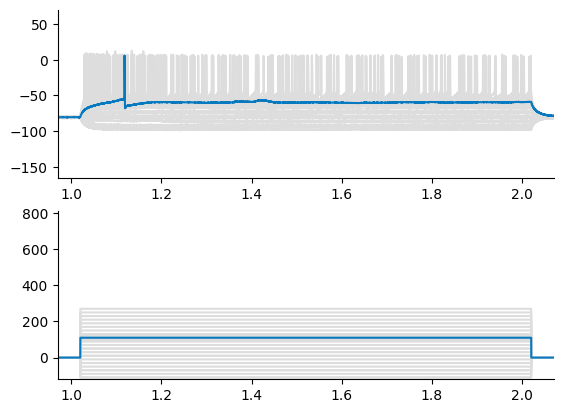

In [17]:
test_sweep_numbers = test_sweep_table[(test_sweep_table['stimulus_name']=='Long Square')&(
        test_sweep_table['clamp_mode']=='CurrentClamp')]['sweep_number'].tolist()
fig = plot_iclamp_sweep(test_data_set, test_sweep_numbers, 31, min_max_i=(-120, 810), min_max_v=(-165, 70))
plt.show()

Calculate IV ranges for plotting:

In [13]:
def get_iv_dataset(nwb):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dataset = create_ephys_data_set(nwb_file=nwb)
        drop_failed_sweeps(dataset)
    return dataset

def get_iv_range(nwb):
    dataset = get_iv_dataset(nwb)
    sweep_table = dataset.sweep_table
    iclamp_sweeps = sweep_table[(sweep_table['stimulus_name'] == 'Long Square') & (
            sweep_table['clamp_mode'] == 'CurrentClamp')]['sweep_number'].tolist()
    sweeps = dataset.sweep_set(iclamp_sweeps)
    i_ranges = [(min(i), max(i)) for i in sweeps.i]
    v_ranges = [(min(v), max(v)) for v in sweeps.v]
    min_is, max_is = zip(*i_ranges)
    min_vs, max_vs = zip(*v_ranges)
    return min(min_is), max(max_is), min(min_vs), max(max_vs)

In [14]:
iv_range_df = pd.DataFrame(((p, *get_iv_range(p)) for p in tqdm(electro_df['path'])),
                           columns=['path','min_i', 'max_i', 'min_v', 'max_v'])
iv_range_df.head()

  0%|          | 0/140 [00:00<?, ?it/s]

,path,min_i,max_i,min_v,max_v
0,nwb/sub-601462951_ses-601790945_icephys.nwb,-110.0,270.0,-98.500008,12.531251
1,nwb/sub-601462951_ses-601808619_icephys.nwb,-110.0,190.0,-91.281258,26.093752
2,nwb/sub-601462926_ses-602231628_icephys.nwb,-110.0,170.0,-158.656250,25.875002
3,nwb/sub-617297334_ses-626152964_icephys.nwb,-110.0,270.0,-86.031250,35.625004
4,nwb/sub-639390385_ses-639674215_icephys.nwb,-90.0,130.0,-89.562508,24.031252


In [15]:
iv_range_df.agg({'min_i': min, 'max_i':max, 'min_v':min,'max_v':max})

min_i   -110.000000
max_i    800.000000
min_v   -158.656250
max_v     62.000004
dtype: float32

Plot and save:

In [18]:
figs_path = Path('electro_figs_0724')
figs_path.mkdir(exist_ok=True)

In [21]:
for p in tqdm(electro_df['path'], total=electro_df.shape[0]):
    plot_nwb_trace(p, figs_path, min_max_i=(-120, 810), min_max_v=(-165, 70))

  0%|          | 0/140 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/32 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/28 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/29 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/30 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/20 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/36 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/23 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

In [22]:
electro_df['path'].map(lambda p: len([fp for fp in (figs_path/Path(p).stem).iterdir()])==0).sum()

0

In [17]:
figs_nm_path = Path('electro_figs_no_morpho')
figs_nm_path.mkdir(exist_ok=True)

In [18]:
for p in tqdm(electro_df_nm['path'], total=electro_df_nm.shape[0], desc='plot neuron'):
    plot_nwb_trace(p, figs_nm_path)

plot neuron:   0%|          | 0/1019 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/23 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/30 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/29 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/29 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/35 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/25 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/43 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/23 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/46 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/25 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/34 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/29 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/6 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/7 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/23 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/24 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/29 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/28 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/20 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/26 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/25 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/26 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/9 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/8 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/25 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/25 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/28 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/27 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/23 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/23 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/32 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/28 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/18 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/28 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/42 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/21 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/17 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/27 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/22 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/20 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/20 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/24 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/15 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/19 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/30 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/14 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/20 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/11 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/12 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/10 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/13 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
# electro_df_nm['path'].map(lambda p: not (figs_nm_path/Path(p).stem).exists()).sum()
electro_df_nm['path'].map(lambda p: len([fp for fp in (figs_nm_path/Path(p).stem).iterdir()])==0).sum()

0